# Learning tasks - RobotArm

# Overall analysis 

In [664]:
import pandas as pd 
from distances import preprocess, euclidean_v2
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

from scipy.stats import mannwhitneyu, ttest_ind
from scipy import stats

import ast

In [665]:
import warnings
warnings.filterwarnings('ignore')

In [666]:
df = pd.read_csv("data/ldw_2023_pilot_coding_tasks_outputs_processed_3.csv")

L1 = "P1M120"
L2 = "P1M123"
L3 = "P1M124"

robotarm_df = df[df['Activity Name'] == 'RobotArm']
robotarm = robotarm_df[robotarm_df['Activity ID'] == L2]

key_vector_l1 = "['ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,ra-world-shape ra-world-shapeA,', 'E,E,E,E,ra-world-shape ra-world-shapeA,false']"
key_vector_l2 = "['ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,ra-world-shape ra-world-shapeB,E,ra-world-shape ra-world-shapeA,E,', 'E,ra-world-shape ra-world-shapeB,E,ra-world-shape ra-world-shapeA,E,false']"
key_vector_l3 = "['ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'ra-world-shape ra-world-shapeA,E,E,E,E,', 'ra-world-shape ra-world-shapeA,ra-world-shape ra-world-shapeB,E,E,E,', 'ra-world-shape ra-world-shapeA,ra-world-shape ra-world-shapeB,E,E,E,false']"

initial_worldspace_l1 = "['ra-world-arm,E,E,E,E,', 'ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'ra-world-shape ra-world-shapeA,E,E,E,E,', 'ra-world-shape ra-world-shapeA,E,E,E,E,false']"
initial_worldspace_l2 = "['ra-world-arm,E,E,E,E,', 'ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,ra-world-shape ra-world-shapeB,E,E,', 'E,E,ra-world-shape ra-world-shapeA,E,E,', 'E,E,ra-world-shape ra-world-shapeA,E,E,', 'E,E,ra-world-shape ra-world-shapeB,E,E,false']"
initial_worldspace_l3 = "['ra-world-arm,E,E,E,E,', 'ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,ra-world-shape ra-world-shapeB,E,E,', 'E,ra-world-shape ra-world-shapeA,ra-world-shape ra-world-shapeA,E,E,', 'E,ra-world-shape ra-world-shapeA,ra-world-shape ra-world-shapeB,E,E,false']" 

#################################### TO CHANGE ! ######################################################

folder = "plots_error_evaluation/plots_l1_2dim"

robotarm = robotarm_df[robotarm_df['Activity ID'] == L1]

initial_worldspace = initial_worldspace_l1
key_vector = key_vector_l1

penalties = {'move1': 0.1, 'move2': 0.1, 'pickup1': 0.1, 'place1': 0.1}

initial_distance = euclidean_v2(initial_worldspace, key_vector, 0, 0, 0, 0, 0, penalties)

Count : 2


In [667]:
initial_length = robotarm.shape[0]
length = robotarm.shape[0]
print(f"Number of rows before filtering: {initial_length}")

Number of rows before filtering: 1967


### Cleaning the data

In [668]:
# remove rows where there is NaN value in the WorldSpace column
robotarm = robotarm.dropna(subset=['WorldSpace'])

print(f"Number of rows after filtering the NaN values: {robotarm.shape[0]}")
print(f"Number of rows removed: {length - robotarm.shape[0]}")
print(f"Percentage of rows removed: {100*(length - robotarm.shape[0])/length}%")

length = robotarm.shape[0]

Number of rows after filtering the NaN values: 1708
Number of rows removed: 259
Percentage of rows removed: 13.167259786476869%


In [669]:
# remove the rows where the WorldSpace contains "trial"
robotarm = robotarm[~robotarm['WorldSpace'].str.contains("trial")]

print(f"Number of rows after removing 'trial' (non-consistent worldspace): {robotarm.shape[0]}")
print(f"Number of rows removed: {length - robotarm.shape[0]}")
print(f"Percentage of rows removed: {100*(length - robotarm.shape[0])/length}%")

length = robotarm.shape[0]

Number of rows after removing 'trial' (non-consistent worldspace): 1708
Number of rows removed: 0
Percentage of rows removed: 0.0%


It may be the case that when data was collected, there was errors. 
One thing that I noticed is that in some cases, we have more elements than we should have, i.e. for the learning task 1, we should have a maximum of 2 As. If we have more, or also any B element, that means that the worldspace is not correct for the task, so the line should be removed in that case. 

In [670]:
# A bad worldspace is a worldspace which has more element than it should
def detect_longer_worldspace(v, goal_v): 
    v_matrix = preprocess(v)
    goal_matrix = preprocess(goal_v)
    
    more_elements = np.count_nonzero(v_matrix == 'A') > np.count_nonzero(goal_matrix == 'A') or np.count_nonzero(v_matrix == 'B') > np.count_nonzero(goal_matrix == 'B')   
    
    return more_elements

# worldspace which as no element at all (donc 30 E elements)
def detect_missing_worldspace(v, goal_v): 
    v_matrix = preprocess(v)
    goal_matrix = preprocess(goal_v)
    
    missing_A = np.count_nonzero(goal_matrix == 'A') - np.count_nonzero(v_matrix == 'A')
    missing_B = np.count_nonzero(goal_matrix == 'B') - np.count_nonzero(v_matrix == 'B')
    
    return missing_A > 1 or missing_B > 1

In [671]:
robotarm['longer_worldspace'] = robotarm.apply(lambda x: detect_longer_worldspace(x['WorldSpace'], key_vector), axis=1)

# remove rows where bad_worldspace is True
robotarm = robotarm[~robotarm['longer_worldspace']]

# remove the bad_worldspace column
robotarm = robotarm.drop(columns=['longer_worldspace'])

print(f"Number of rows after removing worldspace with more elements than it should have : {robotarm.shape[0]}")
print(f"Number of rows removed: {length - robotarm.shape[0]}")
print(f"Percentage of rows removed: {100*(length - robotarm.shape[0])/length}%")

length = robotarm.shape[0]

Number of rows after removing worldspace with more elements than it should have : 1708
Number of rows removed: 0
Percentage of rows removed: 0.0%


In [672]:
robotarm['missing_worldspace'] = robotarm.apply(lambda x: detect_missing_worldspace(x['WorldSpace'], key_vector), axis=1)

# remove rows where bad_worldspace is True
robotarm = robotarm[~robotarm['missing_worldspace']]

# remove the bad_worldspace column
robotarm = robotarm.drop(columns=['missing_worldspace'])

print(f"Number of rows after removing worldspace with more elements than it should have : {robotarm.shape[0]}")
print(f"Number of rows removed: {length - robotarm.shape[0]}")
print(f"Percentage of rows removed: {100*(length - robotarm.shape[0])/length}%")

length = robotarm.shape[0]

Number of rows after removing worldspace with more elements than it should have : 1708
Number of rows removed: 0
Percentage of rows removed: 0.0%


In [673]:
print(f"Number of rows after filtering: {robotarm.shape[0]}")
print(f"Number of rows removed from filtering the initial dataset: {initial_length - robotarm.shape[0]}")
print(f"Percentage of rows removed from filtering the initial dataset: {100*(initial_length - robotarm.shape[0])/initial_length}%")

Number of rows after filtering: 1708
Number of rows removed from filtering the initial dataset: 259
Percentage of rows removed from filtering the initial dataset: 13.167259786476869%


Sanity check to verify if the failing students do not overlap over the successful students (or vice-versa)

In [674]:
robotarm_grouped = robotarm.groupby('Student ID').apply(lambda x: 1 in x['WorldspaceScore'].values)

# separate the students into two groups
success_students = robotarm_grouped[robotarm_grouped == True].index
failure_students = robotarm_grouped[robotarm_grouped == False].index

set(success_students.intersection(failure_students)) == set()

# we can safely continue without separating the datasets

True

### Index the tentatives

In [675]:
robotarm = robotarm.groupby('Student ID', as_index=False).apply(lambda x: x.sort_values(by='timestamp')).reset_index(drop=True)
robotarm['index'] = robotarm.groupby('Student ID').cumcount()

### Selecting only useful informations

In [676]:
data = robotarm[["Student ID", "WorldSpace", "index"]]

# dictionnary to reassign index to the correct order, where index 0 becomes 1 and index 1 becomes 2
index_dict = {i: i+1 for i in range(len(data['index'].unique()))}

data['index'] = data['index'].apply(lambda x: index_dict[x])

### Adding initial vector as starting point 

In [677]:
initial_data = pd.DataFrame({'Student ID': data['Student ID'].unique(), 'WorldSpace': initial_worldspace, 'index': 0})
data = pd.concat([data, initial_data])

data = data.groupby('Student ID', as_index=False).apply(lambda x: x.sort_values(by='index')).reset_index(drop=True)

### Create column corresponding to percentage of activity completed

In [678]:
# create column max tentative which correspond to the last row column "index" for each student
data["nb_tentative"] = data.groupby('Student ID')['index'].transform('max')

In [679]:
data['pct_activity'] = data['index'] / data['nb_tentative']

In [680]:
nb_student = len(robotarm['Student ID'].unique())
print(f"Number of students: {nb_student}")

Number of students: 371


### Create column to indicate if the student made an error or not during the tentative

In [681]:
def detect_error(worldspace):
    worldspace = worldspace.replace("ra-world-shape ra-world-shapeA", "A")
    worldspace = worldspace.replace("ra-world-shape ra-world-shapeB", "B")
    worldspace = ast.literal_eval(worldspace)
    
    matrix = []
    for i in range(len(worldspace)):
        matrix.append(worldspace[i].split(','))
        
    return int(matrix[-1][-1] != 'false')

In [682]:
def detect_type_error(worldspace, type_error):
    worldspace = worldspace.replace("ra-world-shape ra-world-shapeA", "A")
    worldspace = worldspace.replace("ra-world-shape ra-world-shapeB", "B")
    worldspace = ast.literal_eval(worldspace)
    
    matrix = []
    for i in range(len(worldspace)):
        matrix.append(worldspace[i].split(','))
    
    
    if matrix[-1][-1] == type_error:
        return 1
    else :
        return 0

In [683]:
def detect_missing_element(v, goal_v): 
    
    v_matrix = preprocess(v)
    goal_matrix = preprocess(goal_v)
    
    initial_count_A = np.count_nonzero(v_matrix == 'A')
    initial_count_B = np.count_nonzero(v_matrix == 'B')

    goal_count_A = np.count_nonzero(goal_matrix == 'A')
    goal_count_B = np.count_nonzero(goal_matrix == 'B')
        
    error = initial_count_A != goal_count_A or initial_count_B != goal_count_B
    
    return int(error)

In [684]:
data['error'] = data['WorldSpace'].apply(lambda x: detect_error(x))

In [685]:
data['missing'] = data['WorldSpace'].apply(lambda x: detect_missing_element(x, key_vector))

In [686]:
for error in ['move1', 'move2', 'pickup1', 'place1']:
    data[error] = data['WorldSpace'].apply(lambda x: detect_type_error(x, error))

In [687]:
for x in ['error', 'missing', 'move1', 'move2', 'pickup1', 'place1']:
    data[f"nb_{x}"] = data.groupby('Student ID')[x].transform('sum')

### Add percentage columns 

In [688]:
for x in ['error', 'missing', 'move1', 'move2', 'pickup1', 'place1']:
    data[f'pct_{x}'] = data[f'nb_{x}'] / data['nb_tentative']

### Compute euclidean distance

In [689]:
for idx, row in data.iterrows():
    missing = row['missing']
    move1 = row['move1']
    move2 = row['move2']
    pickup1 = row['pickup1']
    place1 = row['place1']
    
    data.loc[idx, 'euclidean_distance'] = euclidean_v2(row['WorldSpace'], key_vector, move1, move2, 
                                                        place1, pickup1, missing, penalties)

Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 1
Count : 1
Count : 2
Count : 2
Count : 2
Count : 1
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 1
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 1
Count : 1
Count : 2
Count : 2
Count : 2
Count : 2
Count : 1
Count : 1
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 1
Count : 1
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2


### Separate the successful and failing students

In [690]:
data_success = data[data['Student ID'].isin(success_students)]
data_fail = data[data['Student ID'].isin(failure_students)]

print("Total number of students: ", len(data['Student ID'].unique()))
print("Number of students who succeeded: ", len(data_success['Student ID'].unique()))
print("Number of students who failed: ", len(data_fail['Student ID'].unique()))

Total number of students:  371
Number of students who succeeded:  273
Number of students who failed:  98


In [691]:
data_success['success'] = 1
data_fail['success'] = 0

data = pd.concat([data_success, data_fail])

In [692]:
# group by Student ID and compute the mean euclidean distance 
data_grouped_per_student = data.groupby('Student ID').agg({'euclidean_distance': 'mean', 'nb_tentative': 'max', 
                                                           'nb_error': 'max', 'nb_move1': 'max', 'nb_move2': 'max', 
                                                           'nb_pickup1': 'max', 'nb_place1': 'max', 'pct_error': 'max', 
                                                           'pct_move1': 'max', 'pct_move2': 'max', 'pct_pickup1': 'max', 
                                                           'pct_place1': 'max'})
data_grouped_per_student.columns = ['mean_euclidean_distance', 'nb_tentative', 'nb_error', 'nb_move1', 
                                    'nb_move2', 'nb_pickup1', 'nb_place1', 'pct_error', 'pct_move1', 
                                    'pct_move2', 'pct_pickup1', 'pct_place1']

data_grouped_per_student_success = data_grouped_per_student[data_grouped_per_student.index.isin(success_students)]
data_grouped_per_student_fail = data_grouped_per_student[data_grouped_per_student.index.isin(failure_students)]

data_grouped_per_student_success['success'] = 1
data_grouped_per_student_fail['success'] = 0

data_grouped_per_student = pd.concat([data_grouped_per_student_success, data_grouped_per_student_fail])

In [693]:
# sum of the column error over the length of the dataset
pct_error_success = data_success['error'].sum() / len(data_success)
pct_error_fail = data_fail['error'].sum() / len(data_fail)
pct_error_tot = data['error'].sum() / len(data)

print(f"Percentage of error for all the tentatives in successful students dataset: {pct_error_success:.2f}")
print(f"Percentage of error for all the tentatives in failing students dataset: {pct_error_fail:.2f}")
print(f"Percentage of error for all the tentatives in the whole dataset: {pct_error_tot:.2f}")

Percentage of error for all the tentatives in successful students dataset: 0.35
Percentage of error for all the tentatives in failing students dataset: 0.37
Percentage of error for all the tentatives in the whole dataset: 0.35


# Analysis 

### Euclidean distance

Sanity check !

In [694]:
data[data['euclidean_distance'] == 0]

Student ID                                         WorldSpace  index  \
4     AUS123001  ['ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E...      4   
9     AUS123073  ['ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E...      4   
14    AUS123217  ['ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E...      1   
16    AUS123361  ['E,E,E,E,ra-world-arm,', 'E,E,E,E,E,', 'E,E,E...      1   
33    AUS123433  ['ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E...      1   
...         ...                                                ...    ...   
2076   UK123025  ['E,E,E,E,ra-world-arm,', 'E,E,E,E,E,', 'E,E,E...      2   
2077   UK123025  ['E,E,E,E,ra-world-arm,', 'E,E,E,E,E,', 'E,E,E...      3   
12    AUS123109  ['E,E,E,E,ra-world-arm,', 'E,E,E,E,E,', 'E,E,E...      2   
584   AUS512377  ['E,E,E,E,ra-world-arm,', 'E,E,E,E,E,', 'E,E,E...      8   
1179  BGR751098  ['E,E,E,E,ra-world-arm,', 'E,E,E,E,E,', 'E,E,E...      5   

      nb_tentative  pct_activity  error  missing  move1  move2  pickup1  ...  \
4                4      1.000000      0        0      0      0        0  ...   
9                4      1.000000      0        0      0      0        0  ...   
14               1      1.000000      0        0      0      0        0  ...   
16               1      1.000000      0        0      0      0        0  ...   
33               2      0.500000      0        0      0      0        0  ...   
...            ...           ...    ...      ...    ...    ...      ...  ...   
2076             4      0.500000      0        0      0      0        0  ...   
2077             4      0.750000      0        0      0      0        0  ...   
12               2      1.000000      0        1      0      0        0  ...   
584              8      1.000000      0        1      0      0        0  ...   
1179             9      0.555556      0        1      0      0        0  ...   

      nb_pickup1  nb_place1  pct_error  pct_missing  pct_move1  pct_move2  \
4              0          0   0.250000     0.000000   0.250000        0.0   
9              0          0   0.750000     0.500000   0.750000        0.0   
14             0          0   0.000000     0.000000   0.000000        0.0   
16             0          0   0.000000     0.000000   0.000000        0.0   
33             0          0   0.500000     0.000000   0.500000        0.0   
...          ...        ...        ...          ...        ...        ...   
2076           1          0   0.250000     0.250000   0.000000        0.0   
2077           1          0   0.250000     0.250000   0.000000        0.0   
12             0          0   0.000000     0.500000   0.000000        0.0   
584            1          2   0.375000     0.375000   0.000000        0.0   
1179           3          1   0.666667     0.888889   0.222222        0.0   

      pct_pickup1  pct_place1  euclidean_distance  success  
4        0.000000    0.000000                 0.0        1  
9        0.000000    0.000000                 0.0        1  
14       0.000000    0.000000                 0.0        1  
16       0.000000    0.000000                 0.0        1  
33       0.000000    0.000000                 0.0        1  
...           ...         ...                 ...      ...  
2076     0.250000    0.000000                 0.0        1  
2077     0.250000    0.000000                 0.0        1  
12       0.000000    0.000000                 0.0        0  
584      0.125000    0.250000                 0.0        0  
1179     0.333333    0.111111                 0.0        0  

[355 rows x 25 columns]

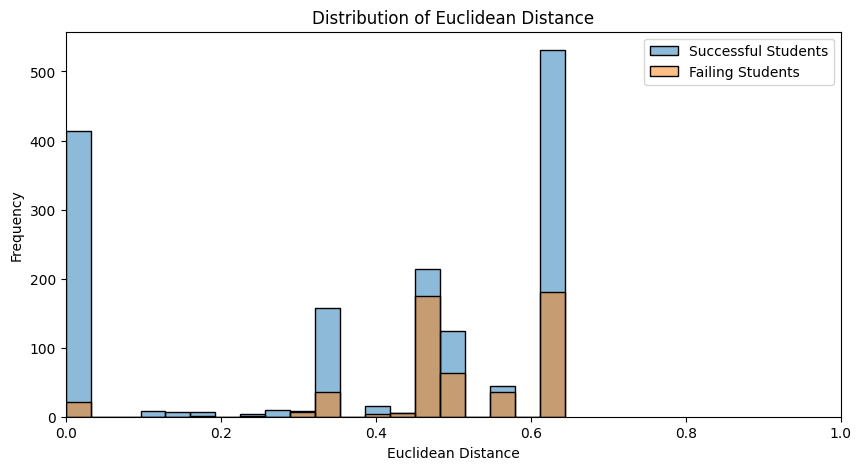

In [695]:
plt.figure(figsize=(10, 5))
sns.histplot(data_success['euclidean_distance'], bins=20, label='Successful Students', alpha=0.5)
sns.histplot(data_fail['euclidean_distance'], bins=20, label='Failing Students', alpha=0.5)
plt.xlim(0, 1)
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Distribution of Euclidean Distance')
plt.legend()
plt.savefig(f"{folder}/euclidean_distance.png")

plt.show()

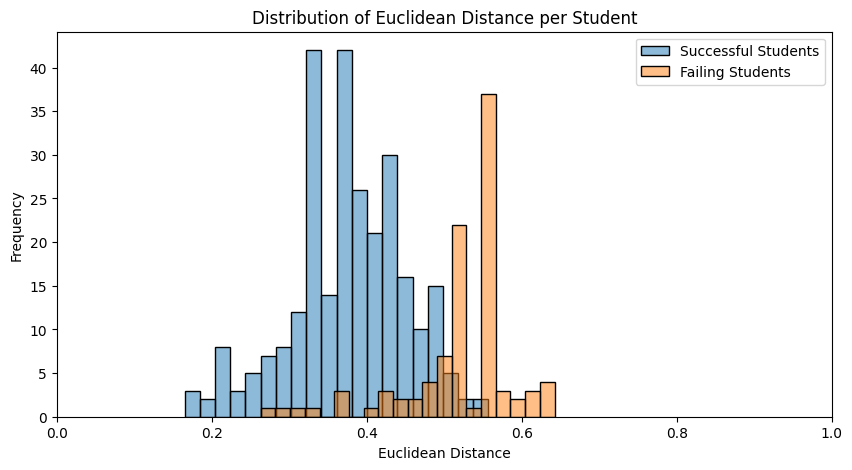

In [696]:
plt.figure(figsize=(10, 5))
sns.histplot(data_grouped_per_student_success['mean_euclidean_distance'], bins=20, label='Successful Students', alpha=0.5)
sns.histplot(data_grouped_per_student_fail['mean_euclidean_distance'], bins=20, label='Failing Students', alpha=0.5)
plt.xlim(0, 1)
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Distribution of Euclidean Distance per Student')
plt.legend()
plt.savefig(f"{folder}/euclidean_distance_per_student.png")

plt.show()

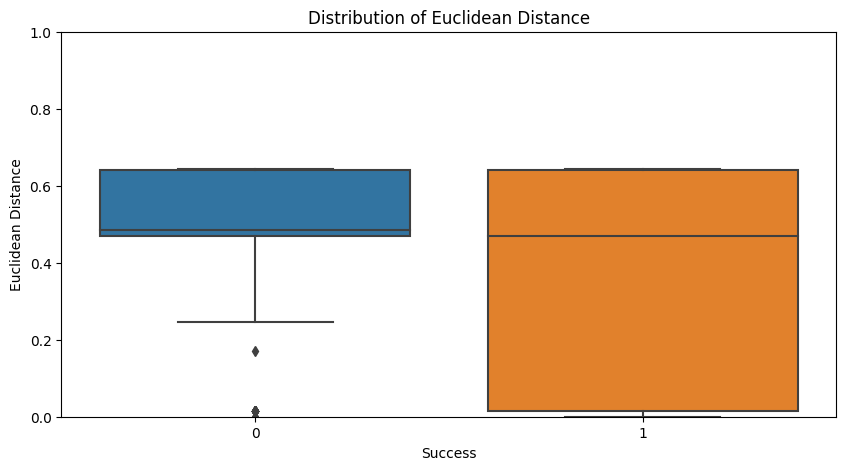

In [697]:
# Create box plots for the Euclidean distance
plt.figure(figsize=(10, 5))
sns.boxplot(x='success', y='euclidean_distance', data=data)
plt.ylim(0, 1)
plt.xlabel('Success')
plt.ylabel('Euclidean Distance')
plt.title('Distribution of Euclidean Distance')
plt.savefig(f"{folder}/boxplot_euclidean_distance.png")

plt.show()


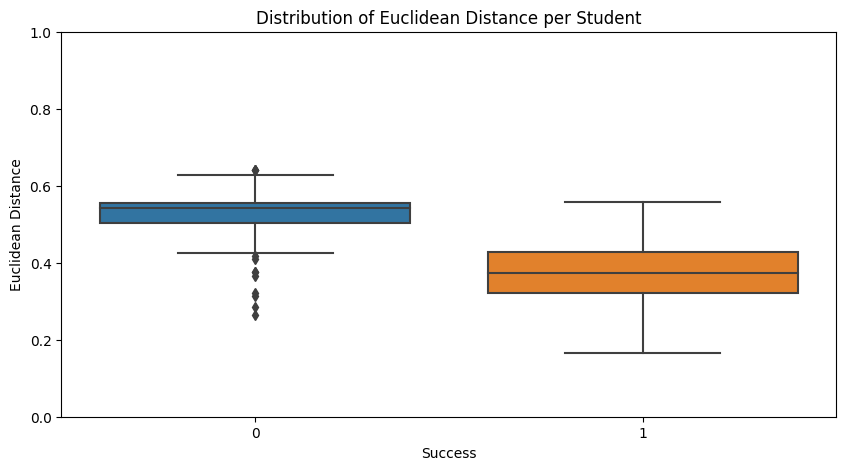

In [698]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='success', y='mean_euclidean_distance', data=data_grouped_per_student)
plt.ylim(0, 1)

plt.xlabel('Success')
plt.ylabel('Euclidean Distance')
plt.title('Distribution of Euclidean Distance per Student')

plt.savefig(f"{folder}/boxplot_euclidean_distance_per_student.png")

plt.show()

In [699]:
# Assuming 'euclidean_distance_successful' and 'euclidean_distance_failing' are arrays of Euclidean distances
statistic, p_value = mannwhitneyu(data_success['euclidean_distance'], data_fail['euclidean_distance'])

# Interpret the results
if p_value < 0.05:
    print("There is a significant difference between successful and failing students in terms of Euclidean distance (p < 0.05)")
else:
    print("There is no significant difference between successful and failing students in terms of Euclidean distance (p >= 0.05)")
    


There is a significant difference between successful and failing students in terms of Euclidean distance (p < 0.05)


### Observe the number of errors per students 

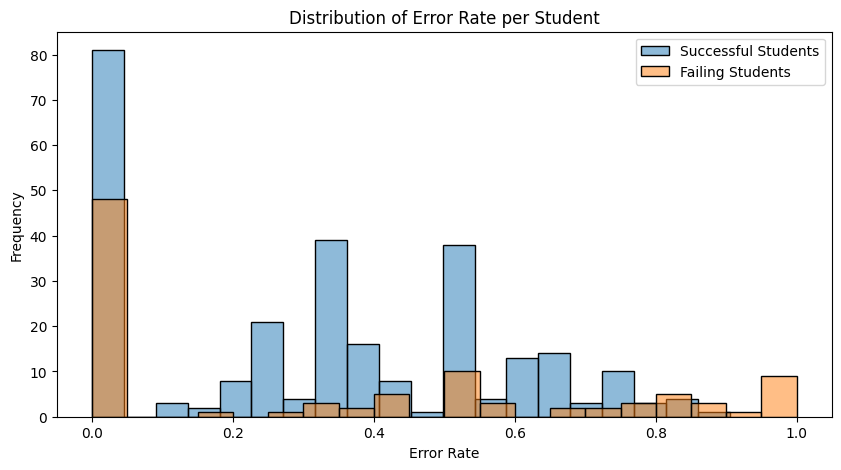

In [700]:
# plot distribution of percentage of error
plt.figure(figsize=(10, 5))

sns.histplot(data_grouped_per_student_success['pct_error'], bins=20, label='Successful Students', alpha=0.5)
sns.histplot(data_grouped_per_student_fail['pct_error'], bins=20, label='Failing Students', alpha=0.5)
plt.xlabel('Error Rate')
plt.ylabel('Frequency')
plt.title('Distribution of Error Rate per Student')
plt.legend()

plt.savefig(f"{folder}/error_rate_per_student.png")
plt.show()

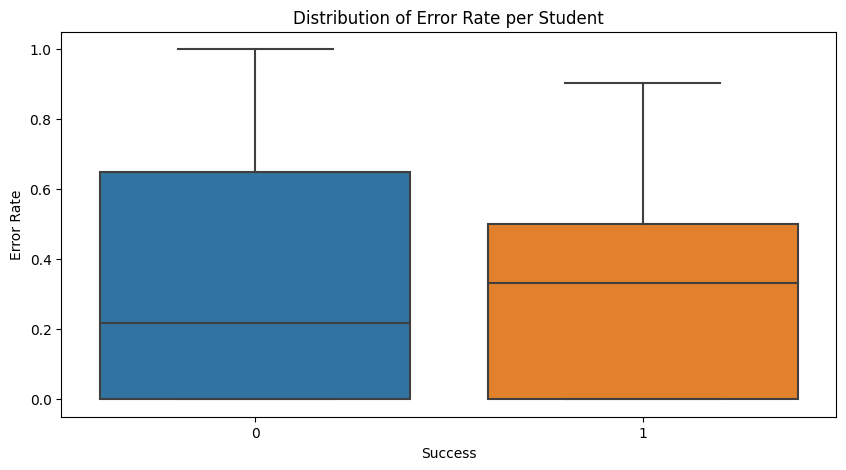

In [701]:
# Create box plots for the number of tentatives
plt.figure(figsize=(10, 5))
sns.boxplot(x='success', y='pct_error', data=data_grouped_per_student)

plt.xlabel('Success')
plt.ylabel('Error Rate')
plt.title('Distribution of Error Rate per Student')

plt.savefig(f"{folder}/boxplot_error_rate_per_student.png")
plt.show()

### Euclidean distance between successive tantatives<>

In [702]:
for idx, row in data.iterrows(): 
    if row['index'] == 0: 
        data.loc[idx, 'delta_successive'] = 0
    else: 
        data.loc[idx, 'delta_successive'] = euclidean_v2(data.loc[idx, 'WorldSpace'], data.loc[idx-1, 'WorldSpace'], 
                                          data.loc[idx, 'move1'], data.loc[idx, 'move2'], data.loc[idx, 'place1'], 
                                          data.loc[idx, 'pickup1'], data.loc[idx, 'missing'], penalties)

Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 1
Count : 1
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 1
Count : 1
Count : 2
Count : 2
Count : 2
Count : 2
Count : 1
Count : 1
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 1
Count : 1
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 1
Count : 2
Count : 1
Count : 2
Count : 2
Count : 2
Count : 1
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 1
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 1
Count : 1
Count : 2
Count : 2
Count : 2
Count : 1
Count : 2
Count : 1
Count : 2
Count : 2
Count : 2
Count : 2
Count : 1
Count : 2
Count : 2
Count : 2
Count : 2


## Students that do an error

* How many students do an error 
* What is their euclidean distribution 
* Does the distribution between students that do not an error and those that do an error change ? 
* And their trajectory ? 

In [703]:
students_error = data[data['error'] == 1]['Student ID'].unique()
students_error_success = data_success[data_success['error'] == 1]['Student ID'].unique()
students_error_fail = data_fail[data_fail['error'] == 1]['Student ID'].unique()

print(f"Number of students with at least one error: {len(students_error)}")
print(f"Number of successful students with at least one error: {len(students_error_success)}")
print(f"Number of failing students with at least one error: {len(students_error_fail)}")

tot_students = len(data['Student ID'].unique())
tot_students_success = len(data_success['Student ID'].unique())
tot_students_fail = len(data_fail['Student ID'].unique())

print(f"Total number of students: {tot_students}")
print(f"Total number of successful students: {tot_students_success}")
print(f"Total number of failing students: {tot_students_fail}")

pct_students_error = len(students_error) / tot_students
pct_students_error_success = len(students_error_success) / tot_students_success
pct_students_error_fail = len(students_error_fail) / tot_students_fail

print(f"Percentage of students with at least one error: {pct_students_error:.2f}")
print(f"Percentage of successful students with at least one error: {pct_students_error_success:.2f}")
print(f"Percentage of failing students with at least one error: {pct_students_error_fail:.2f}")

Number of students with at least one error: 242
Number of successful students with at least one error: 192
Number of failing students with at least one error: 50
Total number of students: 371
Total number of successful students: 273
Total number of failing students: 98
Percentage of students with at least one error: 0.65
Percentage of successful students with at least one error: 0.70
Percentage of failing students with at least one error: 0.51


In [704]:
data_grouped_per_student_success_error = data_grouped_per_student_success[data_grouped_per_student_success.index.isin(students_error_success)]
data_grouped_per_student_fail_error = data_grouped_per_student_fail[data_grouped_per_student_fail.index.isin(students_error_fail)]

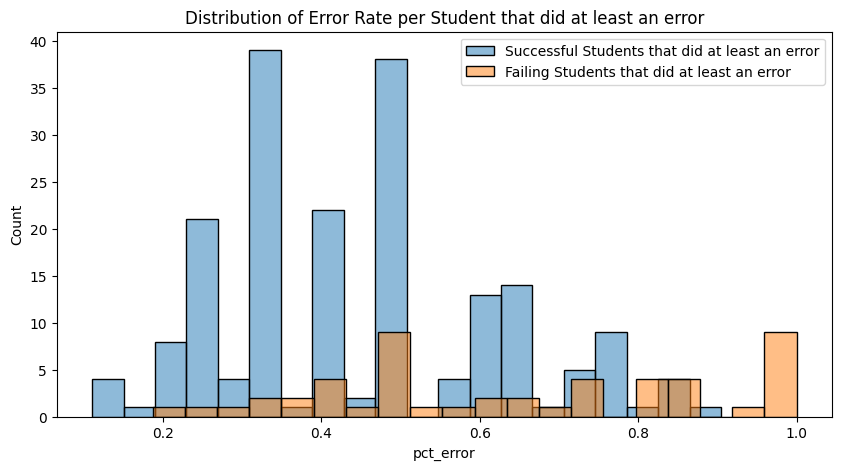

In [705]:
# plot distribution of percentage of error of successful students and failing students
plt.figure(figsize=(10, 5))

sns.histplot(data_grouped_per_student_success_error['pct_error'], bins=20, label='Successful Students that did at least an error', alpha=0.5)
sns.histplot(data_grouped_per_student_fail_error['pct_error'], bins=20, label='Failing Students that did at least an error', alpha=0.5)
plt.legend()
plt.title('Distribution of Error Rate per Student that did at least an error')
plt.savefig(f"{folder}/error_distribution_students_error.png")

In [706]:
data_grouped_per_student_success_error.describe()

mean_euclidean_distance  nb_tentative    nb_error    nb_move1  \
count               192.000000    192.000000  192.000000  192.000000   
mean                  0.391206      5.828125    2.817708    1.182292   
std                   0.075998      3.357673    2.623514    1.229267   
min                   0.164885      2.000000    1.000000    0.000000   
25%                   0.350551      3.750000    1.000000    0.000000   
50%                   0.398995      5.000000    2.000000    1.000000   
75%                   0.443123      7.000000    3.000000    2.000000   
max                   0.556820     22.000000   19.000000    8.000000   

       nb_move2  nb_pickup1   nb_place1   pct_error   pct_move1  pct_move2  \
count     192.0  192.000000  192.000000  192.000000  192.000000      192.0   
mean        0.0    0.578125    1.057292    0.450960    0.210635        0.0   
std         0.0    1.015142    1.706731    0.174628    0.178128        0.0   
min         0.0    0.000000    0.000000    0.111111    0.000000        0.0   
25%         0.0    0.000000    0.000000    0.333333    0.000000        0.0   
50%         0.0    0.000000    1.000000    0.428571    0.211111        0.0   
75%         0.0    1.000000    1.000000    0.578571    0.333333        0.0   
max         0.0    6.000000   12.000000    0.904762    0.750000        0.0   

       pct_pickup1  pct_place1  success  
count   192.000000  192.000000    192.0  
mean      0.092531    0.147794      1.0  
std       0.146280    0.175238      0.0  
min       0.000000    0.000000      1.0  
25%       0.000000    0.000000      1.0  
50%       0.000000    0.071429      1.0  
75%       0.166667    0.250000      1.0  
max       0.666667    0.714286      1.0

In [707]:
data_grouped_per_student_fail_error.describe()

mean_euclidean_distance  nb_tentative   nb_error   nb_move1  nb_move2  \
count                50.000000     50.000000  50.000000  50.000000      50.0   
mean                  0.508256      6.400000   3.920000   1.200000       0.0   
std                   0.090206      4.776644   3.269151   1.525297       0.0   
min                   0.263094      1.000000   1.000000   0.000000       0.0   
25%                   0.456471      3.000000   1.250000   0.000000       0.0   
50%                   0.523002      5.500000   3.000000   1.000000       0.0   
75%                   0.564030      8.000000   5.000000   2.000000       0.0   
max                   0.642117     23.000000  16.000000   6.000000       0.0   

       nb_pickup1  nb_place1  pct_error  pct_move1  pct_move2  pct_pickup1  \
count   50.000000  50.000000  50.000000  50.000000       50.0    50.000000   
mean     0.860000   1.860000   0.654763   0.173412        0.0     0.144522   
std      1.399854   1.761377   0.242118   0.216379        0.0     0.239889   
min      0.000000   0.000000   0.187500   0.000000        0.0     0.000000   
25%      0.000000   1.000000   0.500000   0.000000        0.0     0.000000   
50%      0.000000   1.000000   0.633333   0.088462        0.0     0.000000   
75%      1.000000   2.000000   0.853383   0.285714        0.0     0.200000   
max      7.000000   8.000000   1.000000   0.750000        0.0     1.000000   

       pct_place1  success  
count   50.000000     50.0  
mean     0.336829      0.0  
std      0.281645      0.0  
min      0.000000      0.0  
25%      0.168478      0.0  
50%      0.250000      0.0  
75%      0.480263      0.0  
max      1.000000      0.0

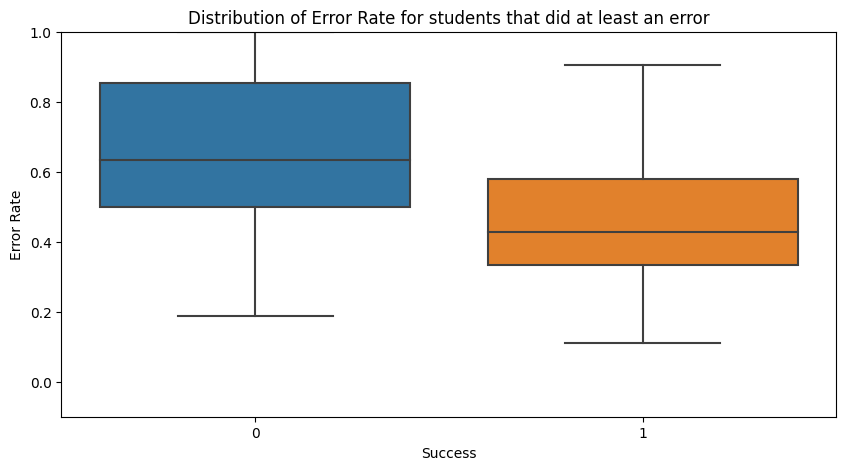

In [708]:
# box plt of the percentage of error for successful students and failing students that did at least an error
plt.figure(figsize=(10, 5))

sns.boxplot(x='success', y='pct_error', data=pd.concat([data_grouped_per_student_success_error, data_grouped_per_student_fail_error]))
plt.ylim(-0.1, 1)
plt.xlabel('Success')
plt.ylabel('Error Rate')
plt.title('Distribution of Error Rate for students that did at least an error')
plt.savefig(f"{folder}/boxplot_error_rate_students_error.png")

In [709]:
studdents_no_error = data[data['nb_error'] == 0]['Student ID'].unique()
studdents_no_error_success = data_success[data_success['nb_error'] == 0]['Student ID'].unique()
studdents_no_error_fail = data_fail[data_fail['nb_error'] == 0]['Student ID'].unique()

In [710]:
data_grouped_per_student_success_no_error = data_grouped_per_student_success[data_grouped_per_student_success.index.isin(studdents_no_error_success)]
data_grouped_per_student_fail_no_error = data_grouped_per_student_fail[data_grouped_per_student_fail.index.isin(studdents_no_error_fail)]

In [711]:
data_grouped_per_student_success_no_error.describe()

mean_euclidean_distance  nb_tentative  nb_error  nb_move1  nb_move2  \
count                81.000000     81.000000      81.0      81.0      81.0   
mean                  0.332902      1.950617       0.0       0.0       0.0   
std                   0.051879      1.059496       0.0       0.0       0.0   
min                   0.214640      1.000000       0.0       0.0       0.0   
25%                   0.321960      1.000000       0.0       0.0       0.0   
50%                   0.321960      2.000000       0.0       0.0       0.0   
75%                   0.370814      2.000000       0.0       0.0       0.0   
max                   0.472366      5.000000       0.0       0.0       0.0   

       nb_pickup1  nb_place1  pct_error  pct_move1  pct_move2  pct_pickup1  \
count        81.0       81.0       81.0       81.0       81.0         81.0   
mean          0.0        0.0        0.0        0.0        0.0          0.0   
std           0.0        0.0        0.0        0.0        0.0          0.0   
min           0.0        0.0        0.0        0.0        0.0          0.0   
25%           0.0        0.0        0.0        0.0        0.0          0.0   
50%           0.0        0.0        0.0        0.0        0.0          0.0   
75%           0.0        0.0        0.0        0.0        0.0          0.0   
max           0.0        0.0        0.0        0.0        0.0          0.0   

       pct_place1  success  
count        81.0     81.0  
mean          0.0      1.0  
std           0.0      0.0  
min           0.0      1.0  
25%           0.0      1.0  
50%           0.0      1.0  
75%           0.0      1.0  
max           0.0      1.0

In [712]:
data_grouped_per_student_fail_no_error.describe()

mean_euclidean_distance  nb_tentative  nb_error  nb_move1  nb_move2  \
count                48.000000     48.000000      48.0      48.0      48.0   
mean                  0.536262      2.312500       0.0       0.0       0.0   
std                   0.039560      2.626836       0.0       0.0       0.0   
min                   0.321960      1.000000       0.0       0.0       0.0   
25%                   0.526988      1.000000       0.0       0.0       0.0   
50%                   0.556221      1.000000       0.0       0.0       0.0   
75%                   0.556221      2.000000       0.0       0.0       0.0   
max                   0.579046     14.000000       0.0       0.0       0.0   

       nb_pickup1  nb_place1  pct_error  pct_move1  pct_move2  pct_pickup1  \
count        48.0       48.0       48.0       48.0       48.0         48.0   
mean          0.0        0.0        0.0        0.0        0.0          0.0   
std           0.0        0.0        0.0        0.0        0.0          0.0   
min           0.0        0.0        0.0        0.0        0.0          0.0   
25%           0.0        0.0        0.0        0.0        0.0          0.0   
50%           0.0        0.0        0.0        0.0        0.0          0.0   
75%           0.0        0.0        0.0        0.0        0.0          0.0   
max           0.0        0.0        0.0        0.0        0.0          0.0   

       pct_place1  success  
count        48.0     48.0  
mean          0.0      0.0  
std           0.0      0.0  
min           0.0      0.0  
25%           0.0      0.0  
50%           0.0      0.0  
75%           0.0      0.0  
max           0.0      0.0

In [713]:
set(students_error_fail).intersection(set(studdents_no_error_fail))

set()

In [714]:
set(students_error_success).intersection(set(studdents_no_error_success))

set()

In [715]:
data_fail_error = data[data['Student ID'].isin(students_error_fail)]
data_success_error = data[data['Student ID'].isin(students_error_success)]

data_fail_no_error = data[data['Student ID'].isin(studdents_no_error_fail)]
data_success_no_error = data[data['Student ID'].isin(studdents_no_error_success)]

In [716]:
data_error = pd.concat([data_fail_error, data_success_error])
data_no_error = pd.concat([data_fail_no_error, data_success_no_error])

In [717]:
data_grouped_per_student_error = pd.concat([data_grouped_per_student_fail_error, data_grouped_per_student_success_error])
data_grouped_per_student_no_error = pd.concat([data_grouped_per_student_fail_no_error, data_grouped_per_student_success_no_error])

In [718]:
data_error['has_error'] = 1
data_no_error['has_error'] = 0

In [719]:
data_grouped_per_student_error['has_error'] = 1
data_grouped_per_student_no_error['has_error'] = 0

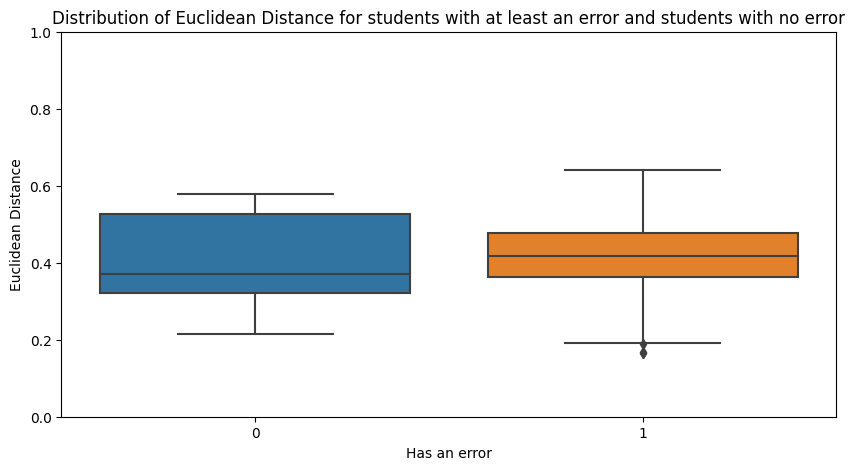

In [720]:
# boxplot of euclidean distance for students with at least an error and students with no error
plt.figure(figsize=(10, 5))

sns.boxplot(x='has_error', y='mean_euclidean_distance', data=pd.concat([data_grouped_per_student_error, data_grouped_per_student_no_error]))
plt.ylim(0, 1)
plt.xlabel('Has an error')
plt.ylabel('Euclidean Distance')
plt.title('Distribution of Euclidean Distance for students with at least an error and students with no error')
plt.savefig(f"{folder}/boxplot_euclidean_distance_error_no_error.png")

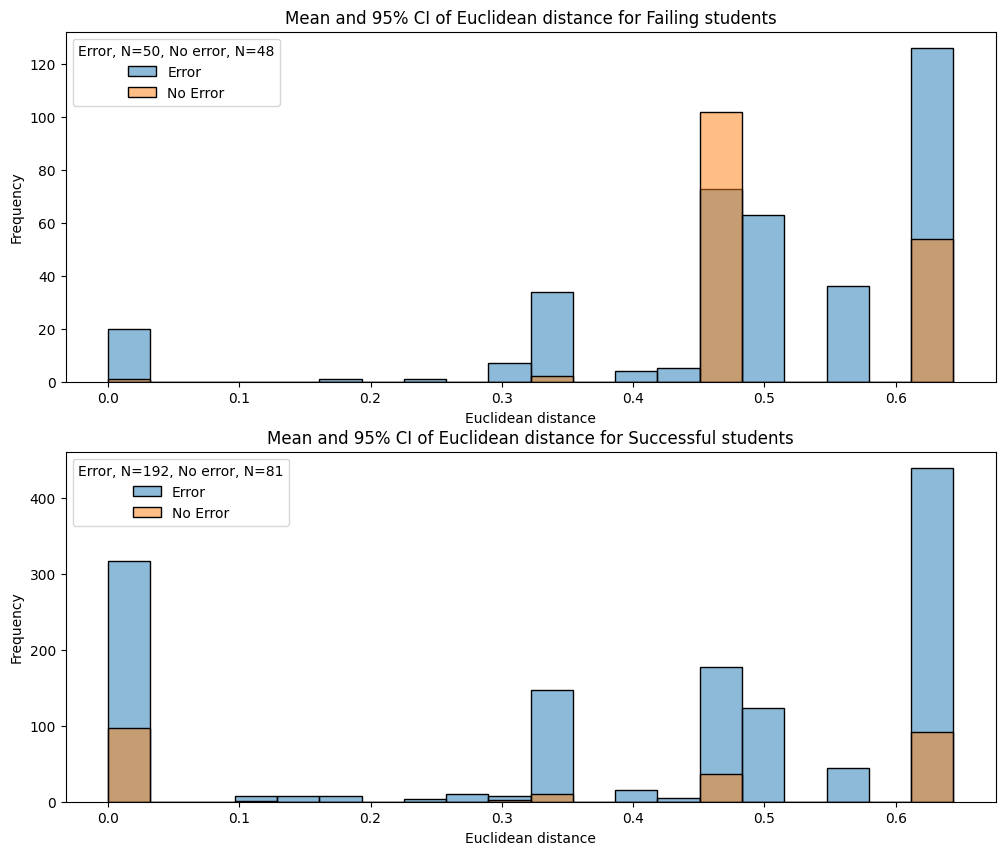

In [721]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,10))

sns.histplot(data_fail_error['euclidean_distance'], bins=20, label='Error', alpha=0.5, ax=ax[0])
sns.histplot(data_fail_no_error['euclidean_distance'], bins=20, label='No Error', alpha=0.5, ax=ax[0])

nb_fail_students_error = len(data_fail_error[data_fail_error['success'] == 0]['Student ID'].unique())
nb_fail_students_no_error = len(data_fail_no_error[data_fail_no_error['success'] == 0]['Student ID'].unique())

ax[0].set_xlabel('Euclidean distance')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Mean and 95% CI of Euclidean distance for Failing students')
ax[0].legend(title=f"Error, N={nb_fail_students_error}, No error, N={nb_fail_students_no_error}")

sns.histplot(data_success_error['euclidean_distance'], bins=20, label='Error', alpha=0.5, ax=ax[1])
sns.histplot(data_success_no_error['euclidean_distance'], bins=20, label='No Error', alpha=0.5, ax=ax[1])

nb_success_students_error = len(data_success_error[data_success_error['success'] == 1]['Student ID'].unique())
nb_success_students_no_error = len(data_success_no_error[data_success_no_error['success'] == 1]['Student ID'].unique())

ax[1].set_xlabel('Euclidean distance')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Mean and 95% CI of Euclidean distance for Successful students')
ax[1].legend(title=f"Error, N={nb_success_students_error}, No error, N={nb_success_students_no_error}")
plt.savefig(f"{folder}/hist_euclidean_distance_error_no_error.png")

In [722]:
data_grouped_per_student_fail_error['has_error'] = 1
data_grouped_per_student_fail_no_error['has_error'] = 0 

data_grouped_per_student_success_error['has_error'] = 1
data_grouped_per_student_success_no_error['has_error'] = 0

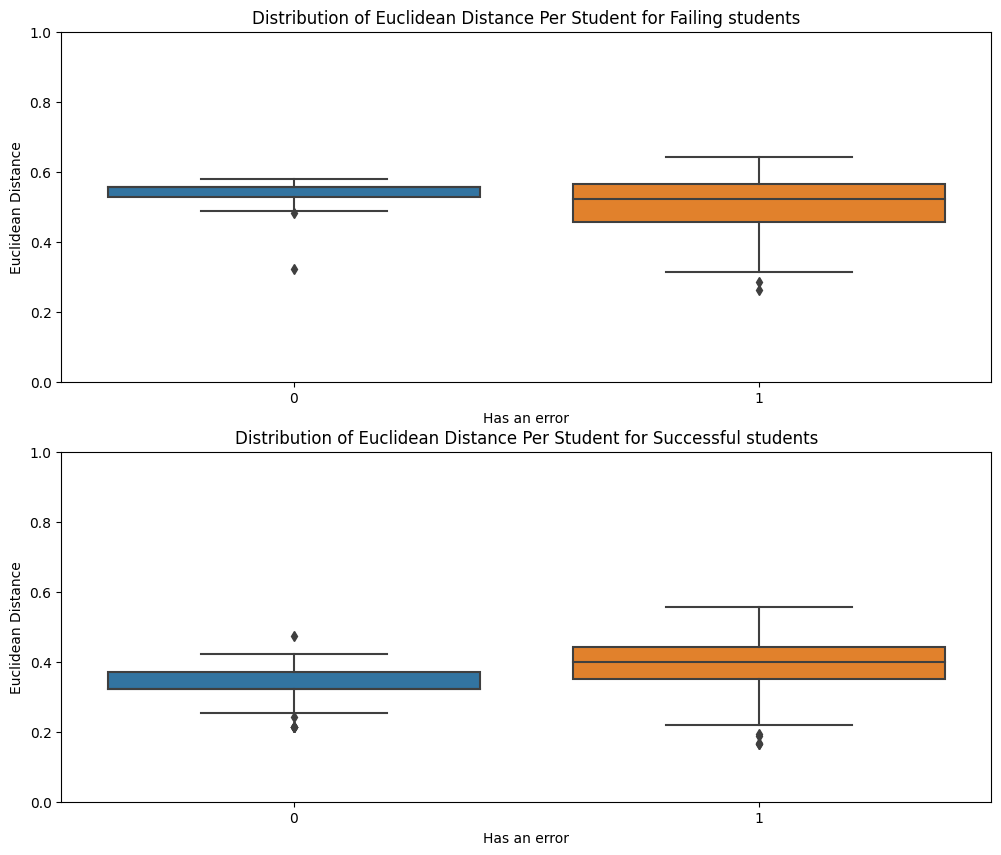

In [723]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,10))

sns.boxplot(x='has_error', y='mean_euclidean_distance', data=pd.concat([data_grouped_per_student_fail_error, data_grouped_per_student_fail_no_error]), ax=ax[0])
ax[0].set_ylim(0, 1)
ax[0].set_xlabel('Has an error')
ax[0].set_ylabel('Euclidean Distance')
ax[0].set_title('Distribution of Euclidean Distance Per Student for Failing students')

sns.boxplot(x='has_error', y='mean_euclidean_distance', data=pd.concat([data_grouped_per_student_success_error, data_grouped_per_student_success_no_error]), ax=ax[1])
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Has an error')
ax[1].set_ylabel('Euclidean Distance')
ax[1].set_title('Distribution of Euclidean Distance Per Student for Successful students')

plt.savefig(f"{folder}/boxplot_euclidean_distance_per_student_error_no_error.png")

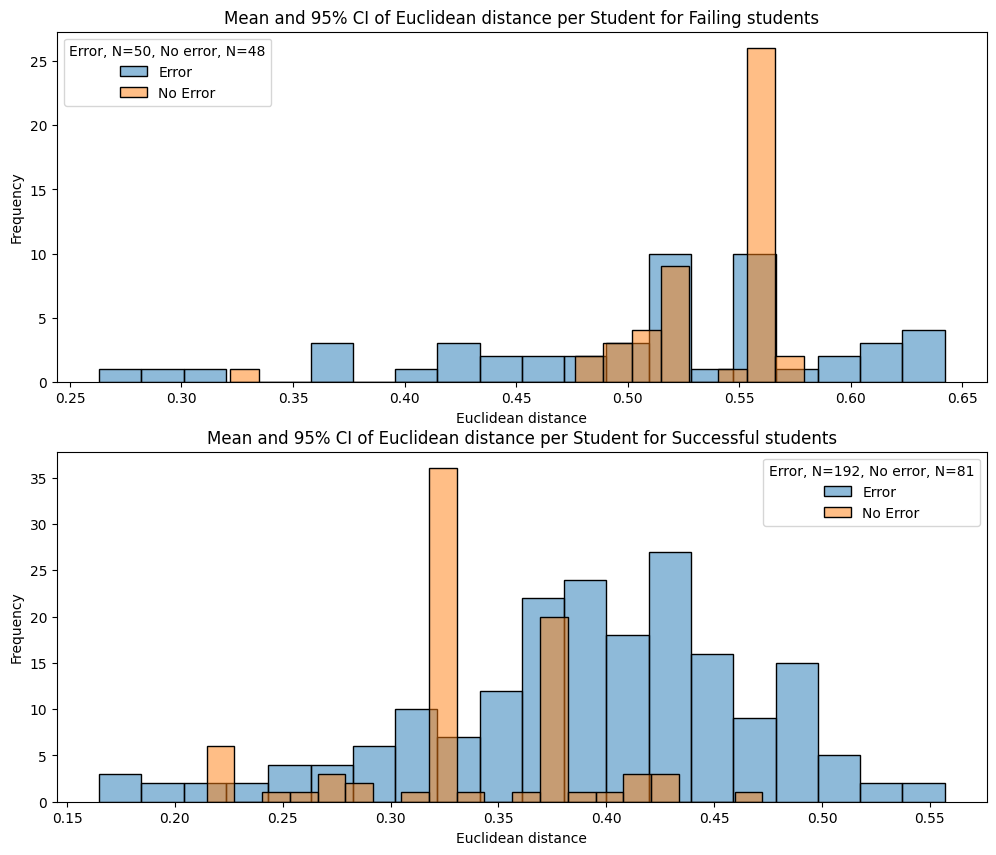

In [724]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,10))

sns.histplot(data_grouped_per_student_fail_error['mean_euclidean_distance'], bins=20, label='Error', alpha=0.5, ax=ax[0])
sns.histplot(data_grouped_per_student_fail_no_error['mean_euclidean_distance'], bins=20, label='No Error', alpha=0.5, ax=ax[0])

ax[0].set_xlabel('Euclidean distance')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Mean and 95% CI of Euclidean distance per Student for Failing students')
ax[0].legend(title=f"Error, N={nb_fail_students_error}, No error, N={nb_fail_students_no_error}")

sns.histplot(data_grouped_per_student_success_error['mean_euclidean_distance'], bins=20, label='Error', alpha=0.5, ax=ax[1])
sns.histplot(data_grouped_per_student_success_no_error['mean_euclidean_distance'], bins=20, label='No Error', alpha=0.5, ax=ax[1])

ax[1].set_xlabel('Euclidean distance')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Mean and 95% CI of Euclidean distance per Student for Successful students')
ax[1].legend(title=f"Error, N={nb_success_students_error}, No error, N={nb_success_students_no_error}")

plt.savefig(f"{folder}/hist_euclidean_distance_per_student_error_no_error.png")

In [725]:
data_error_filtered = data_error[data_error['nb_tentative'] <= 10]
data_no_error_filtered = data_no_error[data_no_error['nb_tentative'] <= 10]

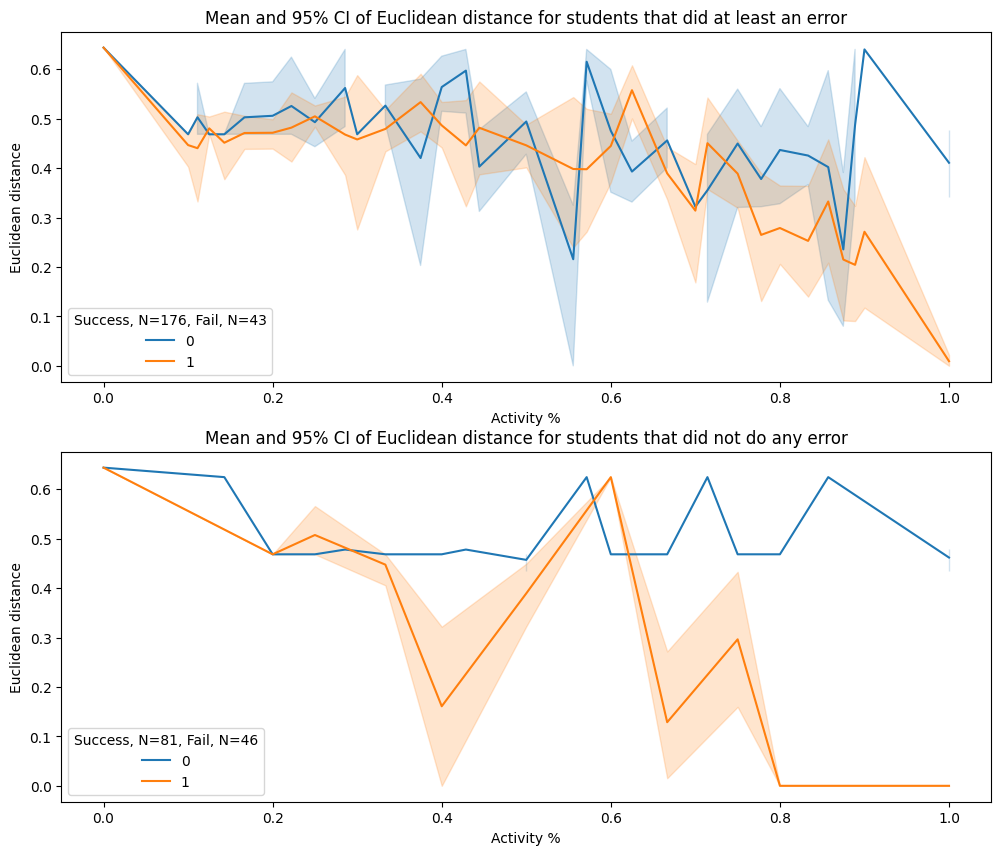

In [726]:
# change size of the figure
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

sns.lineplot(data=data_error_filtered, y=f'euclidean_distance', x='pct_activity', hue="success",
                     err_style="band", errorbar ='ci', estimator=np.mean, ci=95, ax=ax[0])
nb_succes_students_error = len(data_error_filtered[data_error_filtered['success'] == 1]['Student ID'].unique())
nb_fail_students_error = len(data_error_filtered[data_error_filtered['success'] == 0]['Student ID'].unique())

ax[0].set_xlabel('Activity %')
ax[0].set_ylabel('Euclidean distance')
ax[0].set_title('Mean and 95% CI of Euclidean distance for students that did at least an error')
ax[0].legend(title=f"Success, N={nb_succes_students_error}, Fail, N={nb_fail_students_error}")

sns.lineplot(data=data_no_error_filtered, y=f'euclidean_distance', x='pct_activity', hue="success", 
                        err_style="band", errorbar ='ci', estimator=np.mean, ci=95, ax=ax[1])
nb_success_student_no_error = len(data_no_error_filtered[data_no_error_filtered['success'] == 1]['Student ID'].unique())
nb_fail_student_no_error = len(data_no_error_filtered[data_no_error_filtered['success'] == 0]['Student ID'].unique())

ax[1].set_xlabel('Activity %')
ax[1].set_ylabel('Euclidean distance')
ax[1].set_title('Mean and 95% CI of Euclidean distance for students that did not do any error')
ax[1].legend(title=f"Success, N={nb_success_student_no_error}, Fail, N={nb_fail_student_no_error}")

plt.savefig(f"{folder}/lineplot_euclidean_distance_error_no_error_act_pct.png")
plt.show()

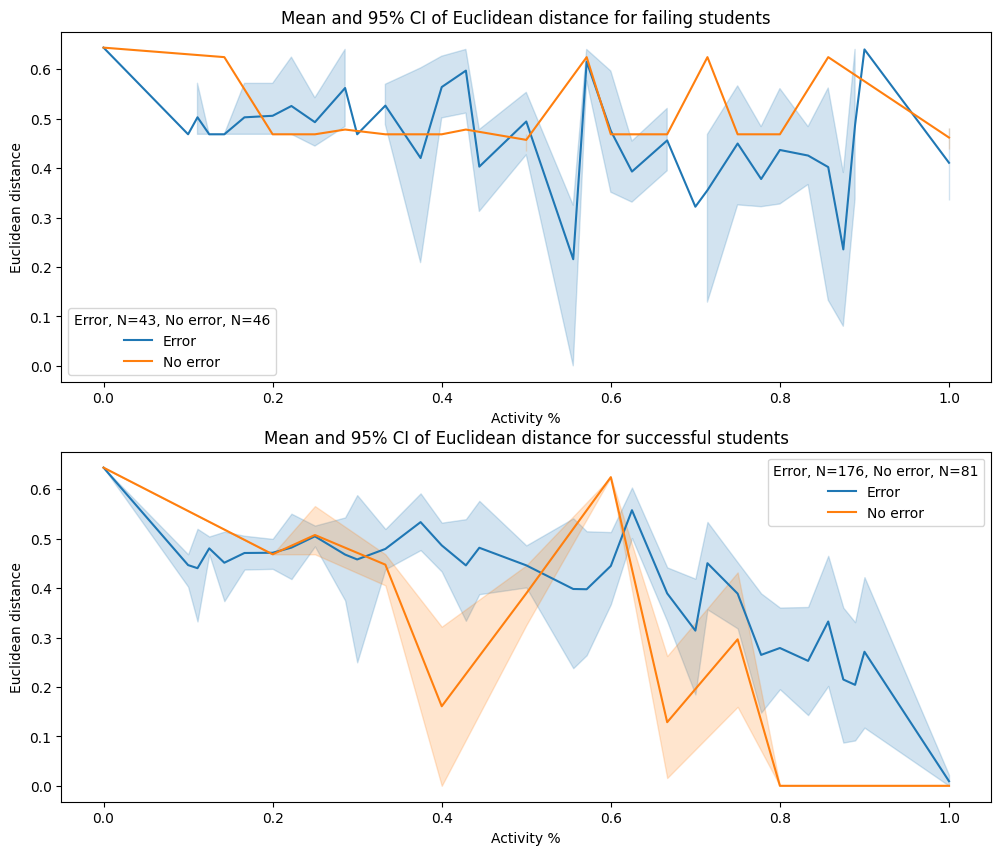

In [727]:
data_fail_error_filtered = data_fail_error[data_fail_error['nb_tentative'] <= 10]
data_fail_no_error_filtered = data_fail_no_error[data_fail_no_error['nb_tentative'] <= 10]

data_success_error_filtered = data_success_error[data_success_error['nb_tentative'] <= 10]
data_success_no_error_filtered = data_success_no_error[data_success_no_error['nb_tentative'] <= 10]

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

sns.lineplot(data=data_fail_error_filtered, y=f'euclidean_distance', x='pct_activity',
                     err_style="band", errorbar ='ci', estimator=np.mean, ci=95, ax=ax[0], label='Error')
sns.lineplot(data=data_fail_no_error_filtered, y=f'euclidean_distance', x='pct_activity', 
                        err_style="band", errorbar ='ci', estimator=np.mean, ci=95, ax=ax[0], label='No error')

nb_success_students_error = len(data_error_filtered[data_error_filtered['success'] == 1]['Student ID'].unique())
nb_fail_students_error = len(data_error_filtered[data_error_filtered['success'] == 0]['Student ID'].unique())

nb_success_students_no_error = len(data_no_error_filtered[data_no_error_filtered['success'] == 1]['Student ID'].unique())
nb_fail_students_no_error = len(data_no_error_filtered[data_no_error_filtered['success'] == 0]['Student ID'].unique())


ax[0].set_xlabel('Activity %')
ax[0].set_ylabel('Euclidean distance')
ax[0].set_title('Mean and 95% CI of Euclidean distance for failing students')
ax[0].legend(title=f"Error, N={nb_fail_students_error}, No error, N={nb_fail_students_no_error}")

sns.lineplot(data=data_success_error_filtered, y=f'euclidean_distance', x='pct_activity', 
                        err_style="band", errorbar ='ci', estimator=np.mean, ci=95, ax=ax[1], label='Error')
sns.lineplot(data=data_success_no_error_filtered, y=f'euclidean_distance', x='pct_activity',
                        err_style="band", errorbar ='ci', estimator=np.mean, ci=95, ax=ax[1], label='No error')

ax[1].set_xlabel('Activity %')
ax[1].set_ylabel('Euclidean distance')
ax[1].set_title('Mean and 95% CI of Euclidean distance for successful students')
ax[1].legend(title=f"Error, N={nb_success_students_error}, No error, N={nb_success_students_no_error}")

plt.savefig(f"{folder}/lineplot_euclidean_distance_error_no_error_act_pct_fail_success.png")
plt.show()

In [728]:
data = pd.concat([data_error, data_no_error])

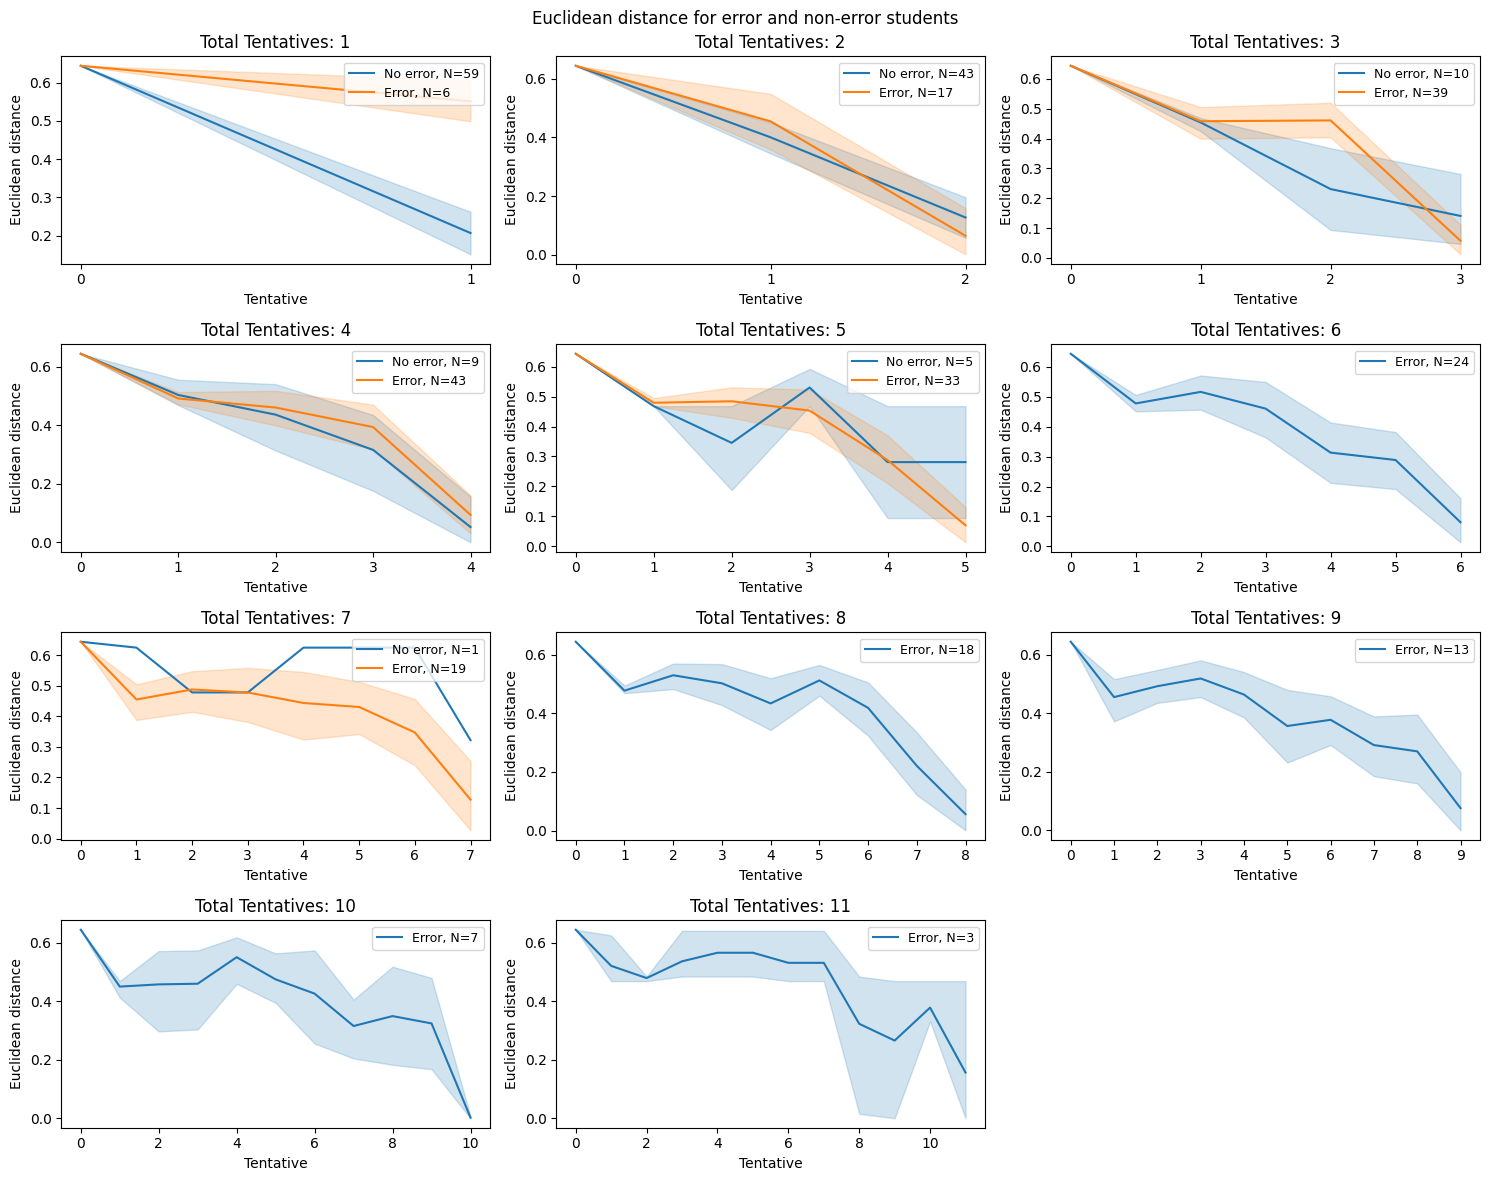

In [729]:
tot_tentatives = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

fig, axs = plt.subplots(4, 3, figsize=(15, 12))

for i, ax in enumerate(axs.flat):
    if i < len(tot_tentatives):
        grouped_data = data[data['nb_tentative'] == tot_tentatives[i]]
        
        # count number of failing and successful students
        nb_error_student = len(data_error[data_error['nb_tentative'] == tot_tentatives[i]]['Student ID'].unique())
        nb_no_error_student = len(data_no_error[data_no_error['nb_tentative'] == tot_tentatives[i]]['Student ID'].unique())

        sns.lineplot(data=grouped_data, y=f'euclidean_distance', x='index', hue="has_error",
                     err_style="band", errorbar ='ci', estimator=np.mean, ci=95, ax=ax, legend=True)
        
        #ax.set_ylim(0, 1)
        ax.set_title(f"Total Tentatives: {tot_tentatives[i]}")
        ax.set_xlabel("Tentative")
        ax.set_ylabel("Euclidean distance")
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        
        handles, labels = ax.get_legend_handles_labels()
        new_labels = []
        for label in labels:
            if label == '0':
                new_labels.append(f"No error, N={nb_no_error_student}")
            else:
                new_labels.append(f"Error, N={nb_error_student}")
        ax.legend(handles, new_labels, loc='upper right', fontsize=9)
        
    else:
        ax.axis('off')

plt.suptitle("Euclidean distance for error and non-error students")
plt.tight_layout()
plt.savefig(f"{folder}/lineplot_euclidean_distance_error_no_error_tentatives_multi.png")
plt.show()

In [730]:
data_fail_error['has_error'] = 1
data_fail_no_error['has_error'] = 0

In [731]:
data_fail = pd.concat([data_fail_error, data_fail_no_error])

In [732]:
data_success_error['has_error'] = 1
data_success_no_error['has_error'] = 0

In [733]:
data_success = pd.concat([data_success_error, data_success_no_error])

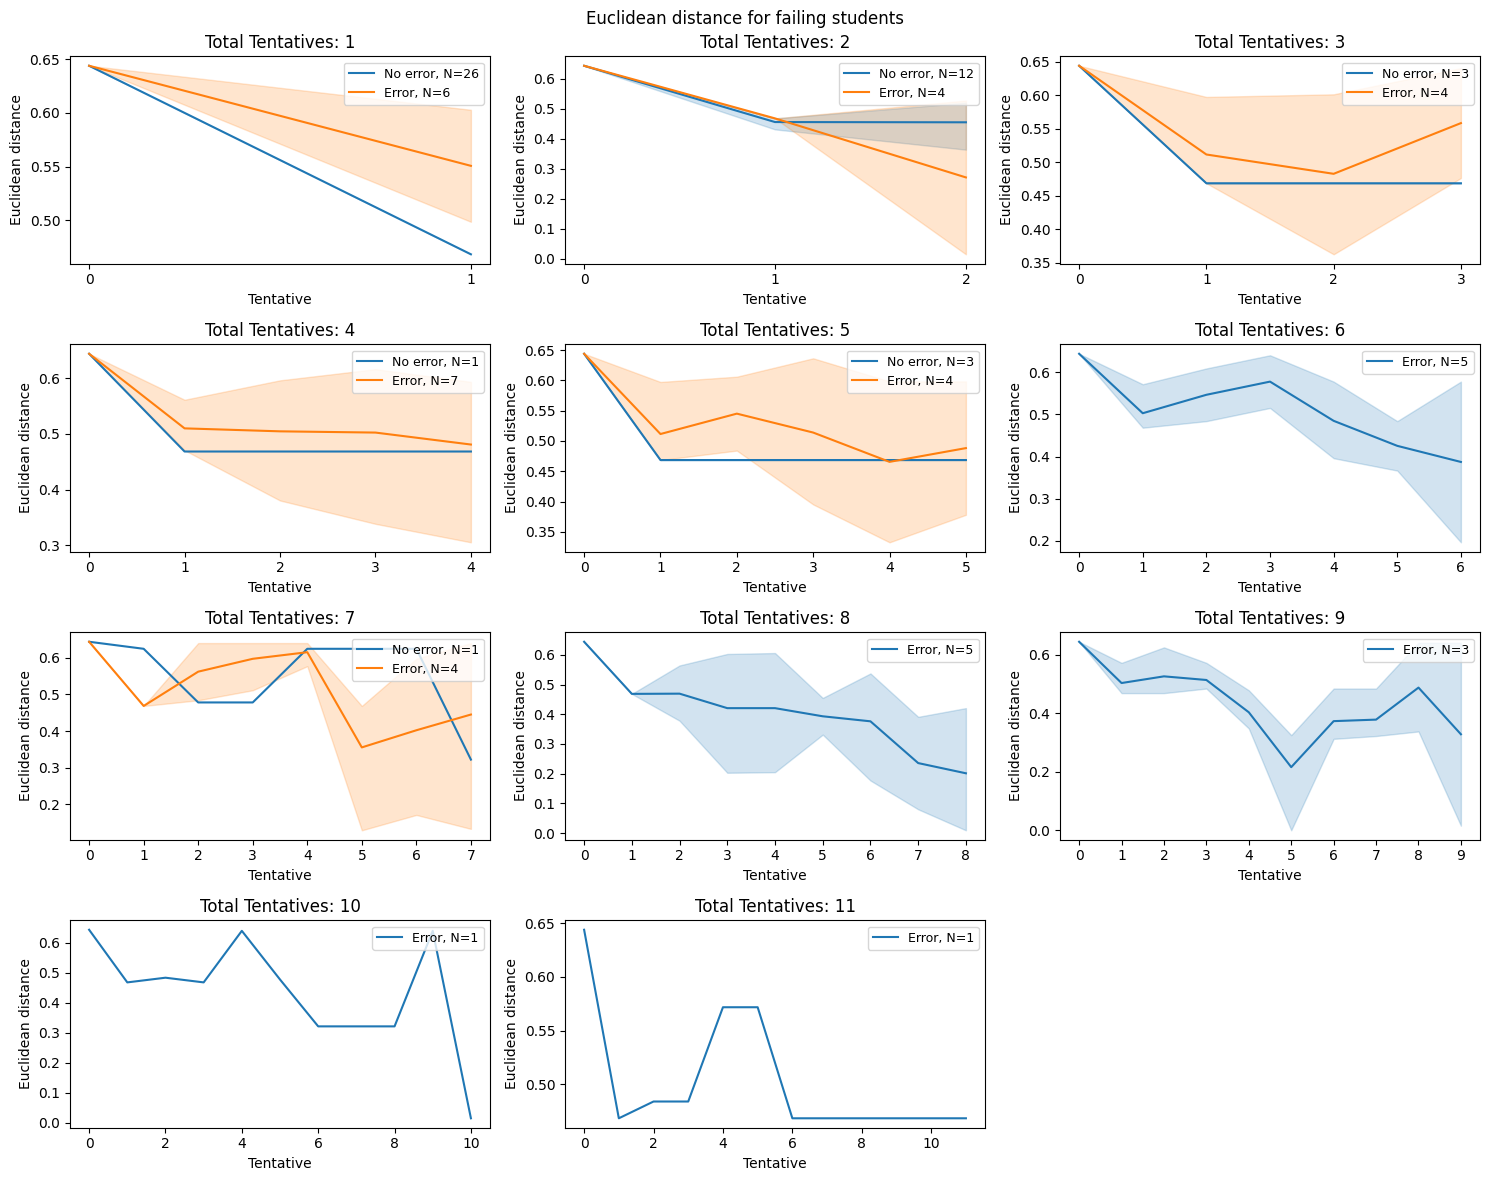

In [734]:
tot_tentatives = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

fig, axs = plt.subplots(4, 3, figsize=(15, 12))

for i, ax in enumerate(axs.flat):
    if i < len(tot_tentatives):
        grouped_data_fail = data_fail[data_fail['nb_tentative'] == tot_tentatives[i]]
        
        # count number of failing and successful students
        nb_fail_error_student = len(data_fail_error[data_fail_error['nb_tentative'] == tot_tentatives[i]]['Student ID'].unique())
        nb_fail_no_error_student = len(data_fail_no_error[data_fail_no_error['nb_tentative'] == tot_tentatives[i]]['Student ID'].unique())

        sns.lineplot(data=grouped_data_fail, y=f'euclidean_distance', x='index', hue="has_error",
                     err_style="band", errorbar ='ci', estimator=np.mean, ci=95, ax=ax, legend=True)
        
        #ax.set_ylim(0, 1)
        ax.set_title(f"Total Tentatives: {tot_tentatives[i]}")
        ax.set_xlabel("Tentative")
        ax.set_ylabel("Euclidean distance")
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        
        handles, labels = ax.get_legend_handles_labels()
        new_labels = []
        for label in labels:
            if label == '0':
                new_labels.append(f"No error, N={nb_fail_no_error_student}")
            else:
                new_labels.append(f"Error, N={nb_fail_error_student}")
        ax.legend(handles, new_labels, loc='upper right', fontsize=9)
        
    else:
        ax.axis('off')

plt.suptitle("Euclidean distance for failing students")
plt.tight_layout()
plt.savefig(f"{folder}/lineplot_euclidean_distance_error_no_error_tentatives_fail_multi.png")
plt.show()

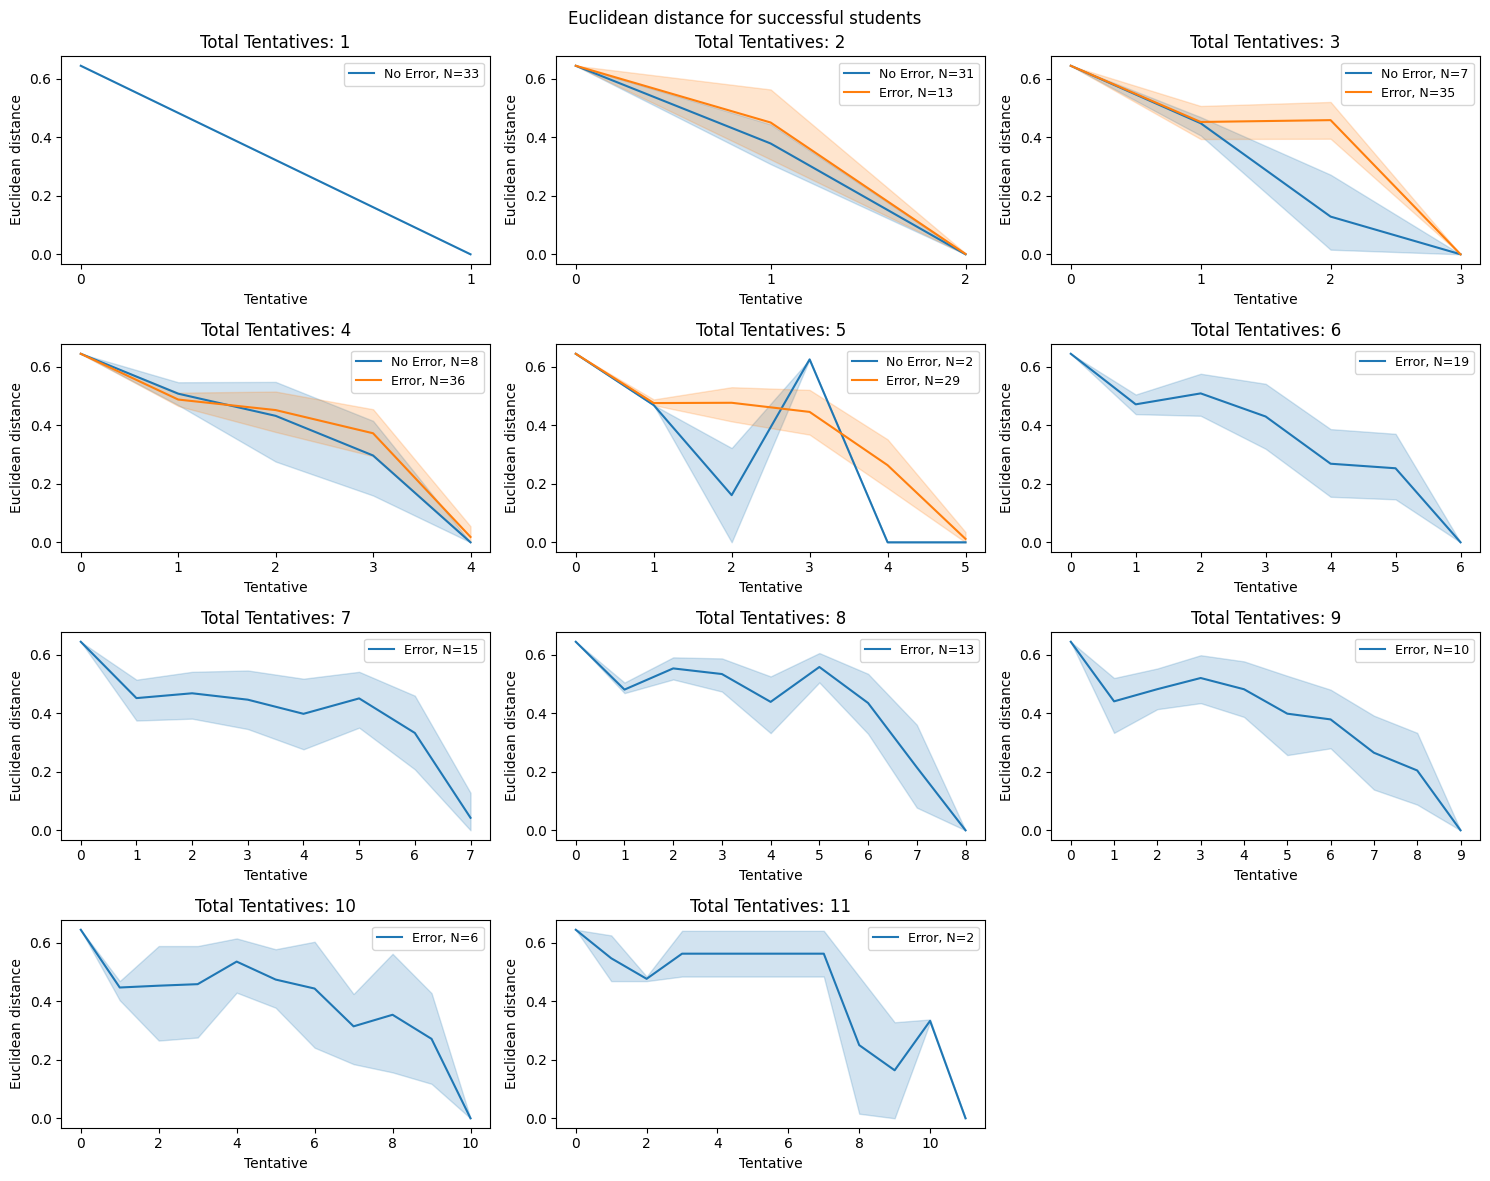

In [735]:
tot_tentatives = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

fig, axs = plt.subplots(4, 3, figsize=(15, 12))

for i, ax in enumerate(axs.flat):
    if i < len(tot_tentatives):
        grouped_data_success = data_success[data_success['nb_tentative'] == tot_tentatives[i]]
        
        # count number of failing and successful students
        nb_success_error_student = len(data_success_error[data_success_error['nb_tentative'] == tot_tentatives[i]]['Student ID'].unique())
        nb_success_no_error_student = len(data_success_no_error[data_success_no_error['nb_tentative'] == tot_tentatives[i]]['Student ID'].unique())

        sns.lineplot(data=grouped_data_success, y=f'euclidean_distance', x='index', hue="has_error",
                     err_style="band", errorbar ='ci', estimator=np.mean, ci=95, ax=ax, legend=True)
        
        #ax.set_ylim(0, 1)
        ax.set_title(f"Total Tentatives: {tot_tentatives[i]}")
        ax.set_xlabel("Tentative")
        ax.set_ylabel("Euclidean distance")
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        
        handles, labels = ax.get_legend_handles_labels()
        new_labels = []
        for label in labels:
            if label == '0':
                new_labels.append(f"No Error, N={nb_success_no_error_student}")
            else:
                new_labels.append(f"Error, N={nb_success_error_student}")
        ax.legend(handles, new_labels, loc='upper right', fontsize=9)
        
    else:
        ax.axis('off')

plt.suptitle("Euclidean distance for successful students")
plt.tight_layout()
plt.savefig(f"{folder}/lineplot_euclidean_distance_error_no_error_tentatives_success_multi.png")
plt.show()

### Statistical tests

In [736]:
# Assuming 'tentatives_successful' and 'tentatives_failing' are arrays of number of tentatives
statistic, p_value = mannwhitneyu(data_grouped_per_student_success_error['mean_euclidean_distance'], data_grouped_per_student_success_no_error['mean_euclidean_distance'])

# Interpret the results
if p_value < 0.05:
    print("There is a significant difference between successful students that did an error or no error at all (p < 0.05)")
else:
    print("There is no significant difference between successful students that did an error or no error at all (p >= 0.05)")


There is a significant difference between successful students that did an error or no error at all (p < 0.05)


In [737]:
# Assuming 'tentatives_successful' and 'tentatives_failing' are arrays of number of tentatives
statistic, p_value = mannwhitneyu(data_grouped_per_student_fail_error['mean_euclidean_distance'], data_grouped_per_student_fail_no_error['mean_euclidean_distance'])

# Interpret the results
if p_value < 0.05:
    print("There is a significant difference between failing students that did an error or no error at all (p < 0.05)")
else:
    print("There is no significant difference between failing students that did an error or no error at all (p >= 0.05)")


There is no significant difference between failing students that did an error or no error at all (p >= 0.05)


## 2 dimension analysis 

* The idea is to display a distribution of errors at each step 
* This will indicate how the euclidean distance changes, with respect to errors 
* Do the same with respect to cases 

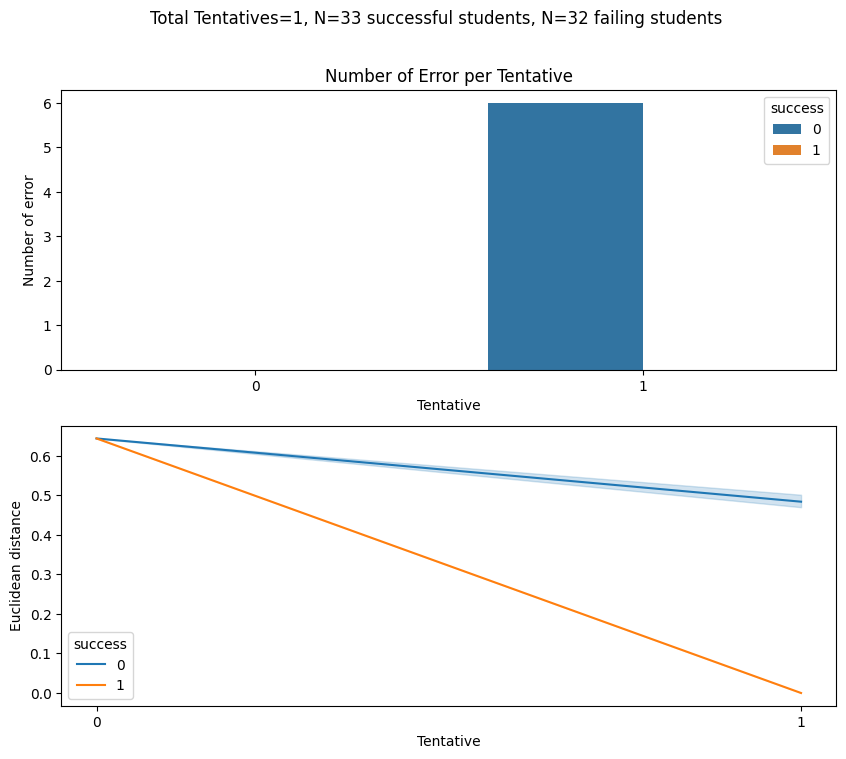

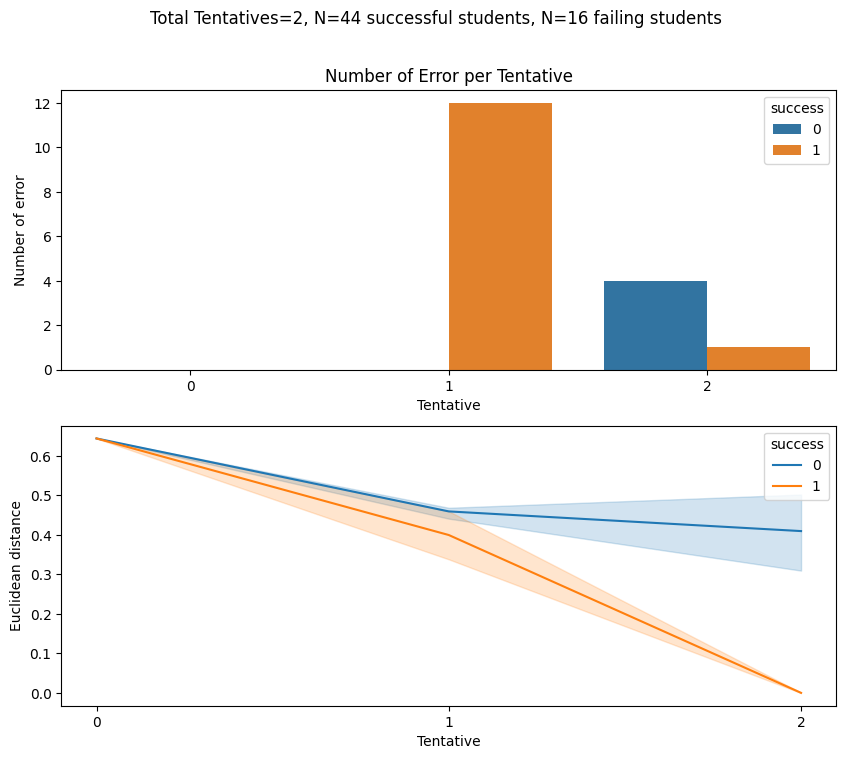

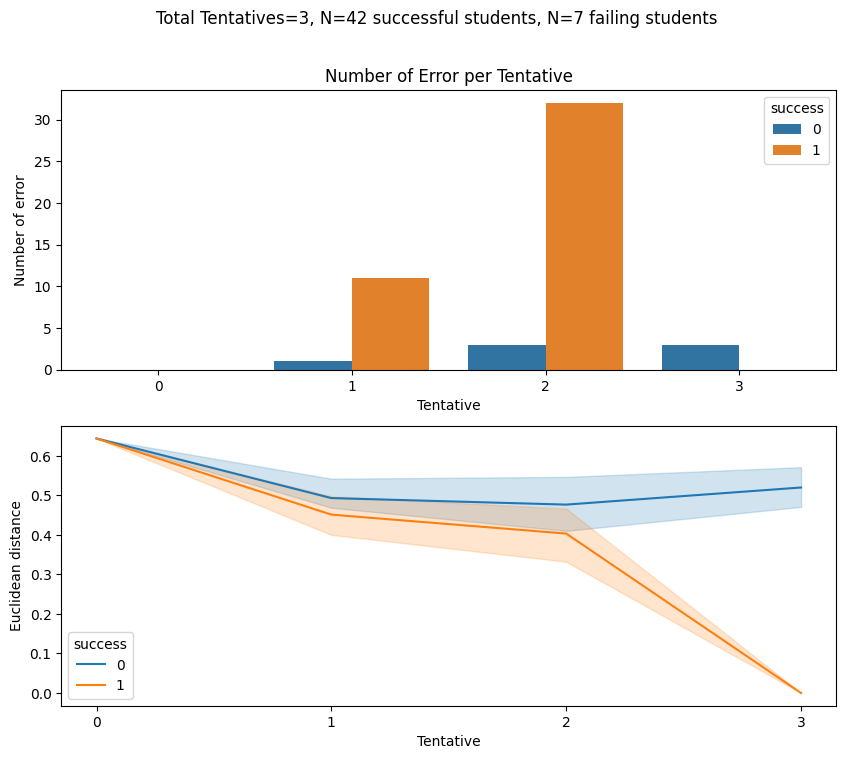

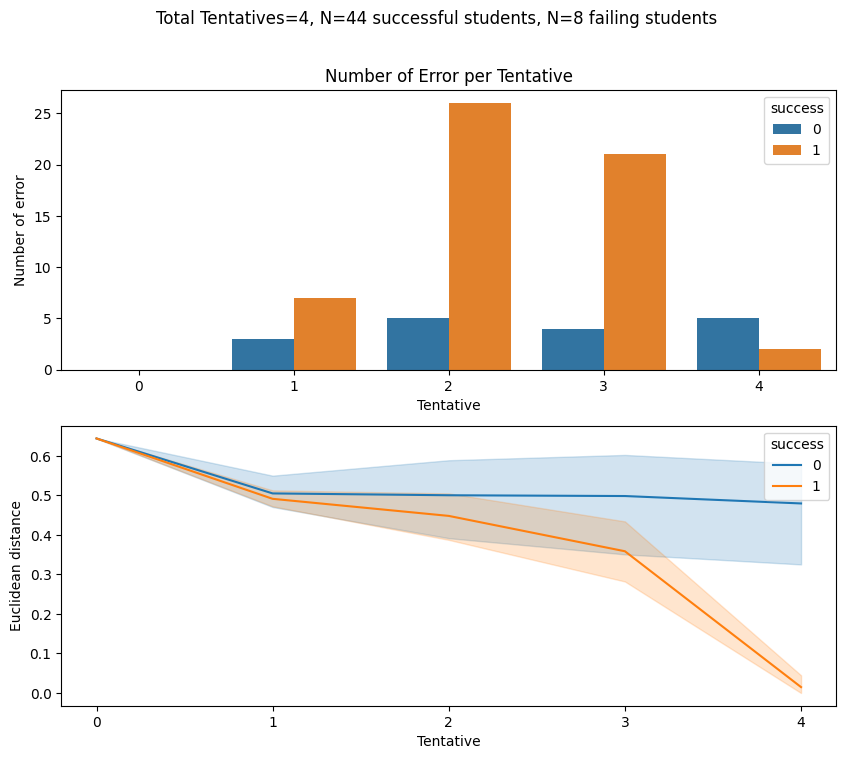

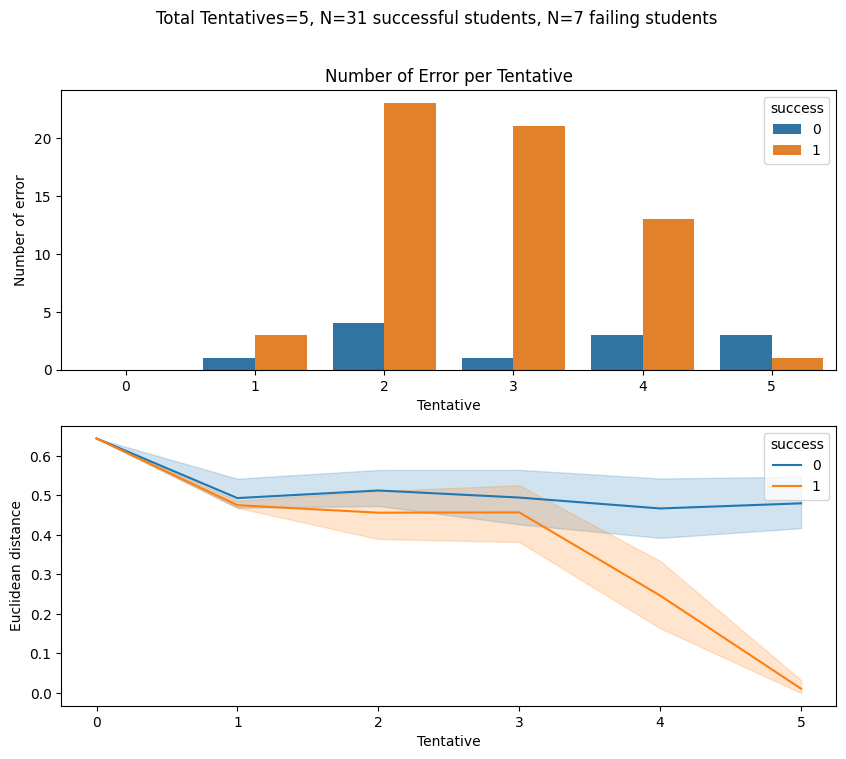

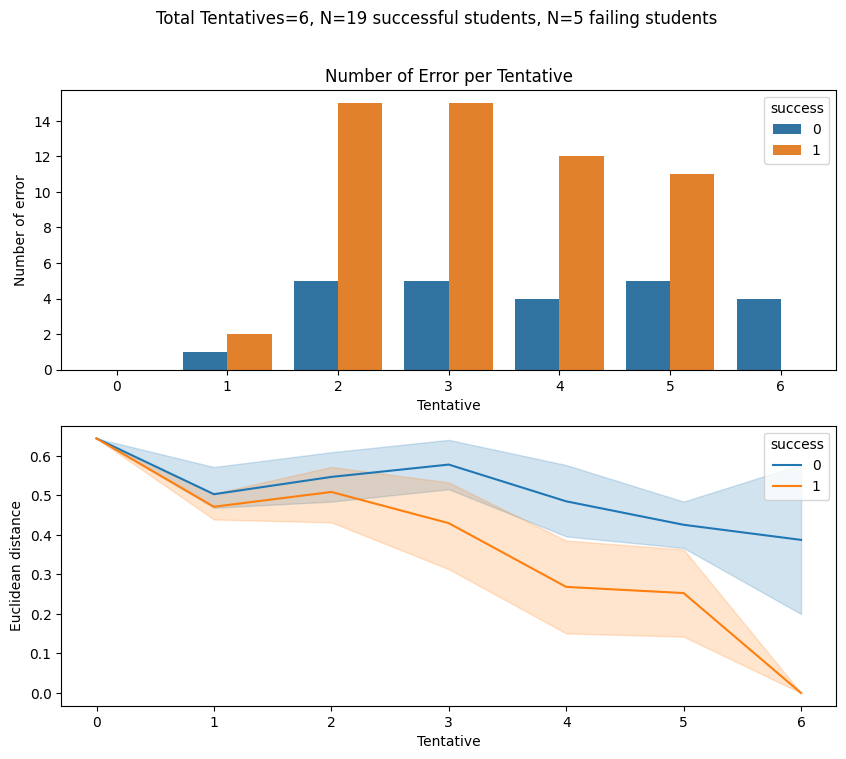

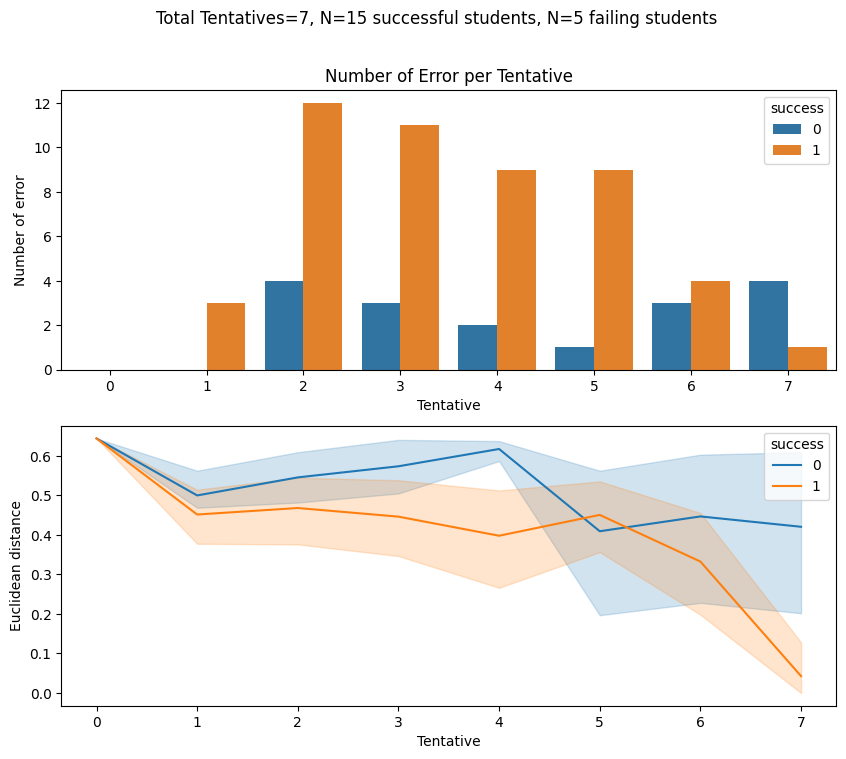

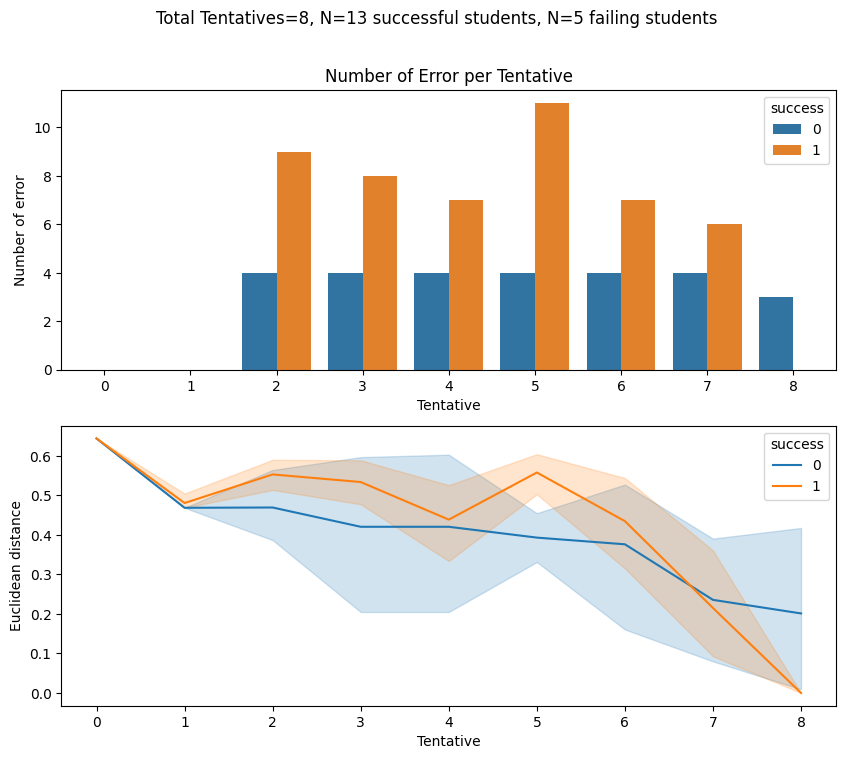

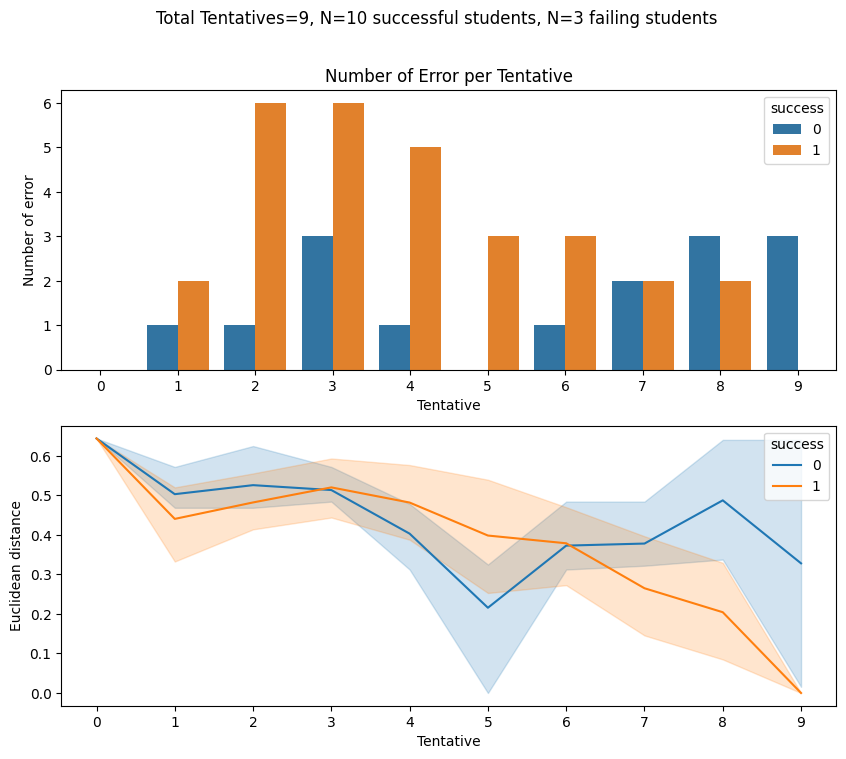

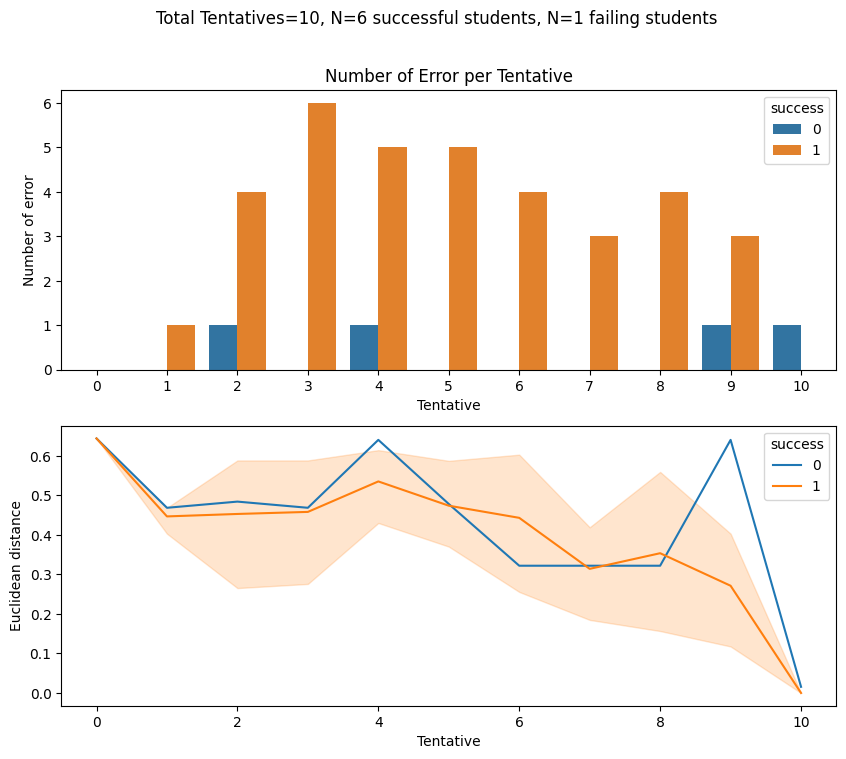

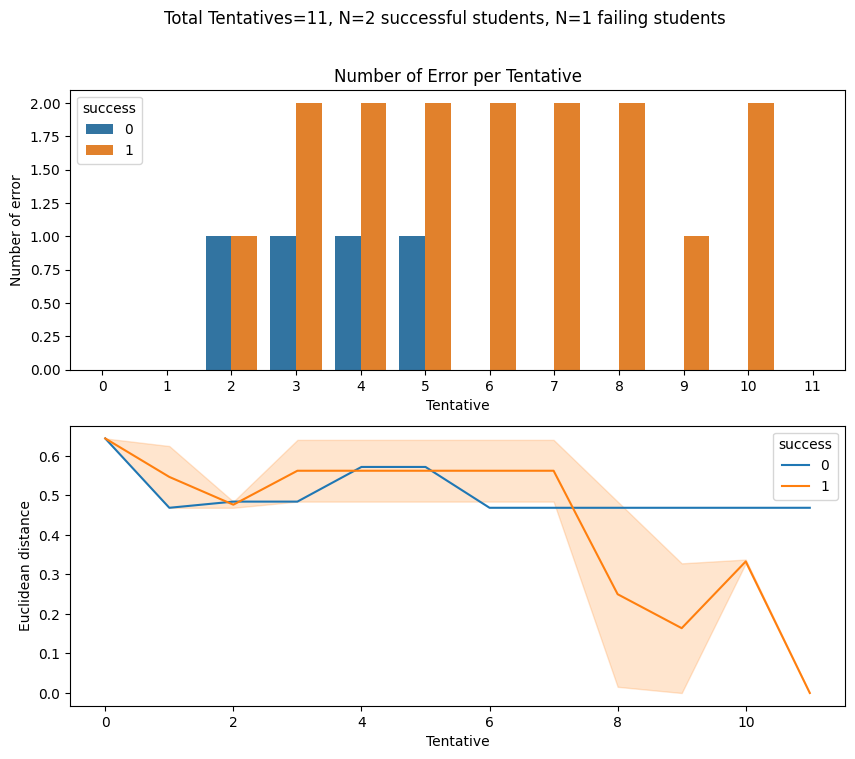

In [738]:
tot_tentatives = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

for i in range(len(tot_tentatives)):
    grouped_data = data[data['nb_tentative'] == tot_tentatives[i]]
    
    count_error_per_tentative_success = grouped_data[grouped_data['success'] == 1].groupby('index').agg({'error': 'sum'}).reset_index()
    count_error_per_tentative_fail = grouped_data[grouped_data['success'] == 0].groupby('index').agg({'error': 'sum'}).reset_index()

    count_error_per_tentative_success['success'] = 1
    count_error_per_tentative_fail['success'] = 0

    count_error_per_tentative = pd.concat([count_error_per_tentative_success, count_error_per_tentative_fail])
    
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))
    
    sns.barplot(x='index', y='error', hue='success', data=count_error_per_tentative, ax=axs[0])
    axs[0].set_xlabel('Tentative')
    axs[0].set_ylabel('Number of error')
    axs[0].set_title('Number of Error per Tentative')
    
    nb_success_student = len(grouped_data[grouped_data['success'] == 1]['Student ID'].unique())
    nb_failing_student = len(grouped_data[grouped_data['success'] == 0]['Student ID'].unique())

    sns.lineplot(data=grouped_data, y=f'euclidean_distance', x='index', hue="success",
                    err_style="band", errorbar ='ci', estimator=np.mean, ci=95, ax=axs[1], legend=True)
    
    #ax.set_ylim(0, 1)
    #axs[0].set_title(f"Total Tentatives: {tot_tentatives[i]}")
    axs[1].set_xlabel("Tentative")
    axs[1].set_ylabel("Euclidean distance")
    axs[1].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    
        
    plt.suptitle(f"Total Tentatives={tot_tentatives[i]}, N={nb_success_student} successful students, N={nb_failing_student} failing students")
    plt.savefig(f"{folder}/barplot_error_euclidean_tentative_{tot_tentatives[i]}.png")
    plt.show()
    

## Let's observe the cases

* CASE 1: Error with missing element
* CASE 2: Error with non missing element
* CASE 3: No error but missing element

In [739]:
for idx, row in data.iterrows():
    if row['error'] == 1 and row['missing'] == 1: 
        data.loc[idx, 'case1'] = 1
    else:
        data.loc[idx, 'case1'] = 0
        
    if row['error'] == 1 and row['missing'] == 0:
        data.loc[idx, 'case2'] = 1
    else:
        data.loc[idx, 'case2'] = 0
        
    if row['error'] == 0 and row['missing'] == 1:
        data.loc[idx, 'case3'] = 1
    else:
        data.loc[idx, 'case3'] = 0

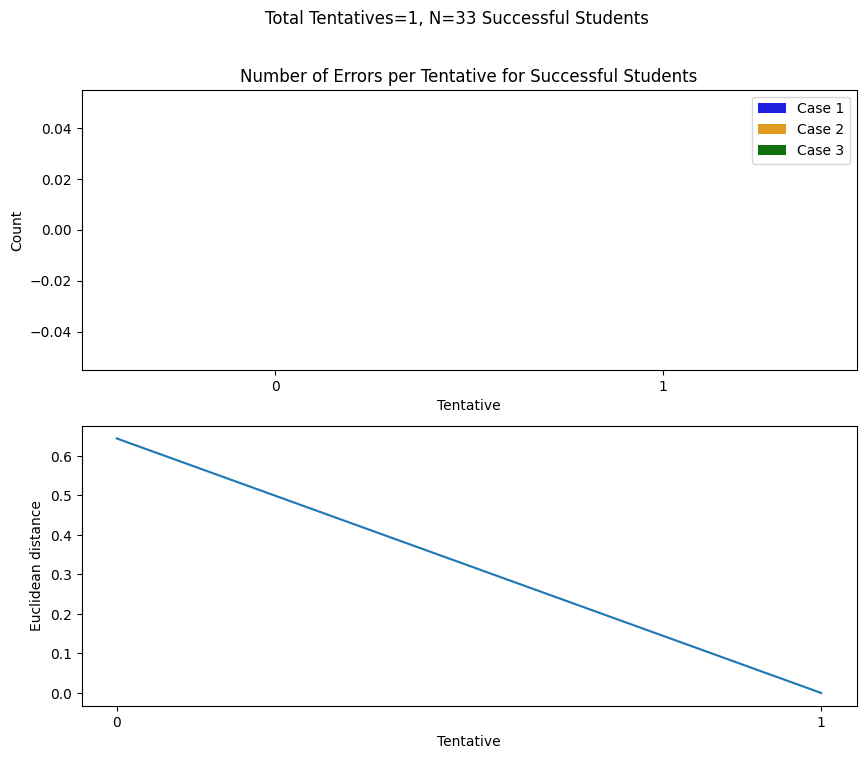

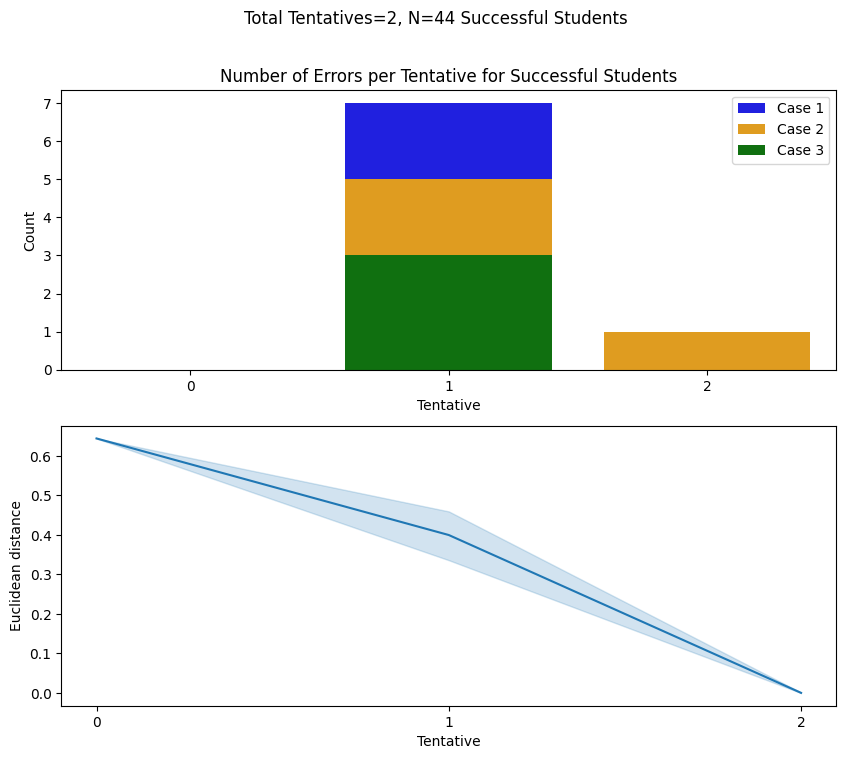

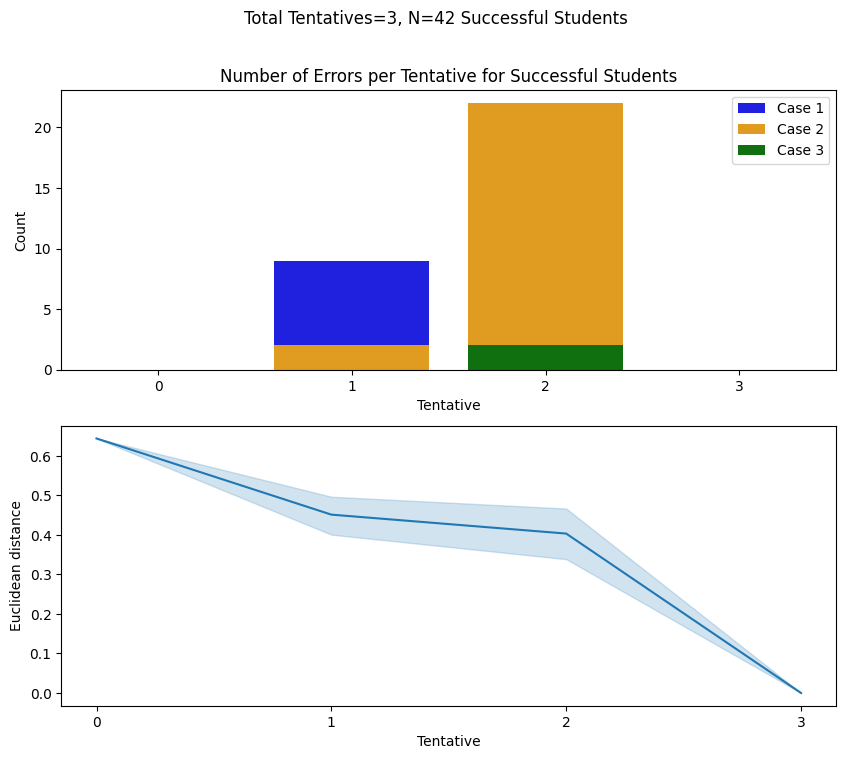

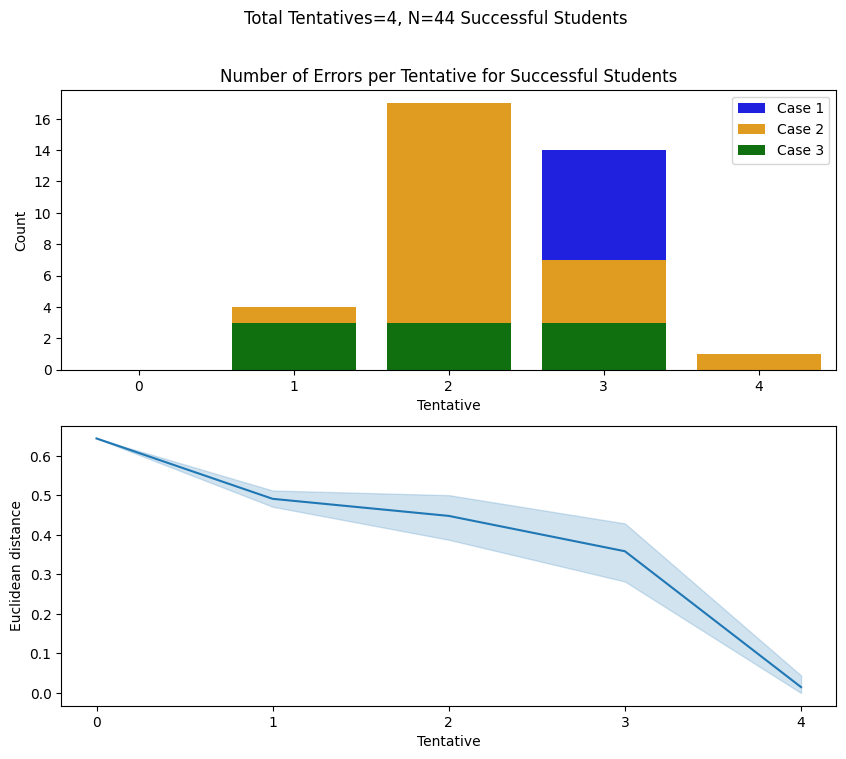

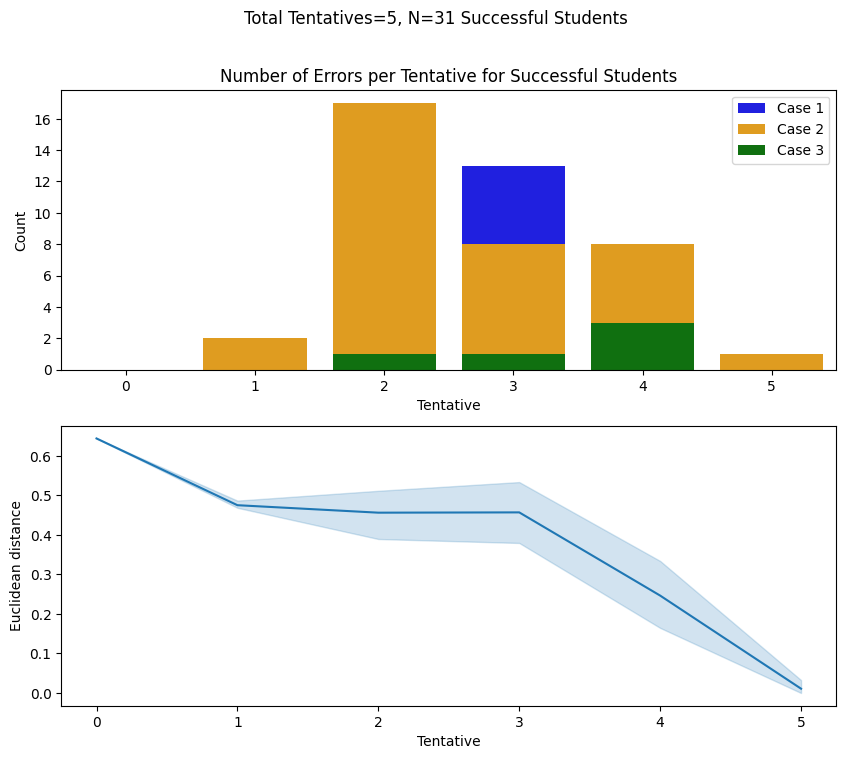

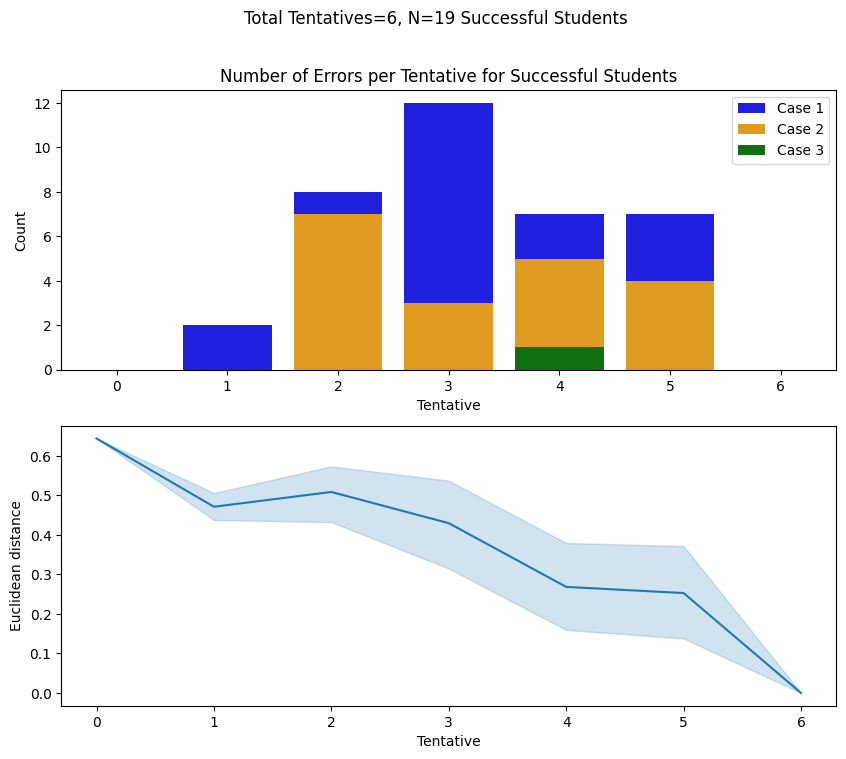

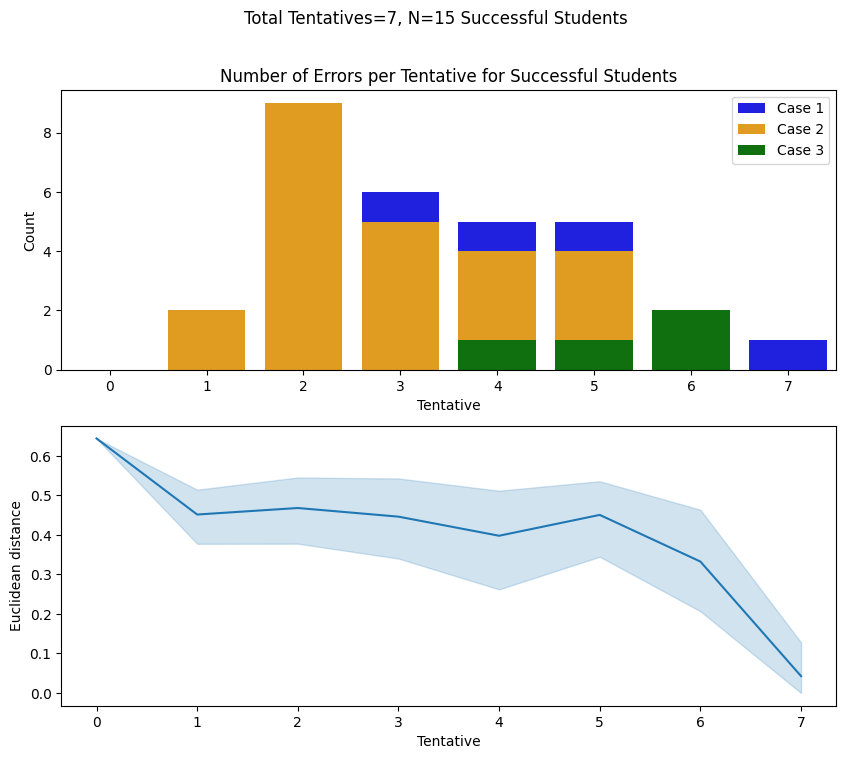

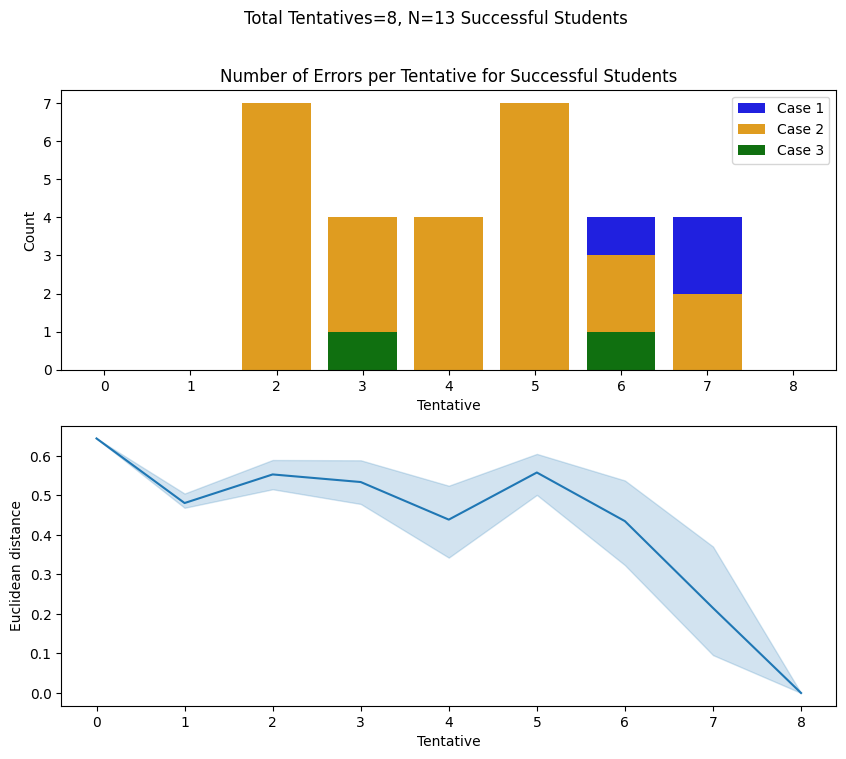

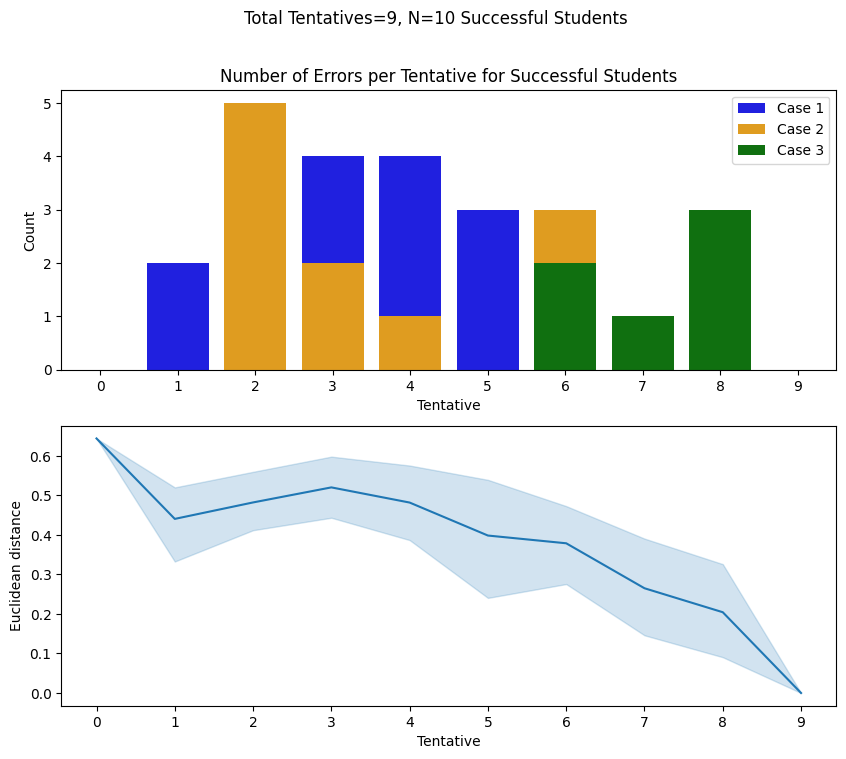

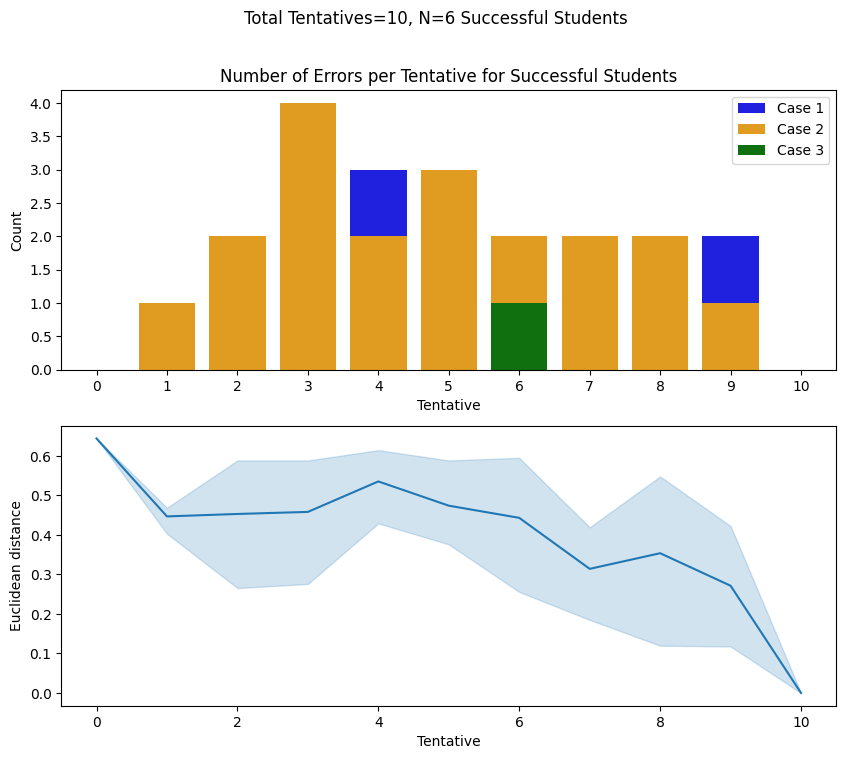

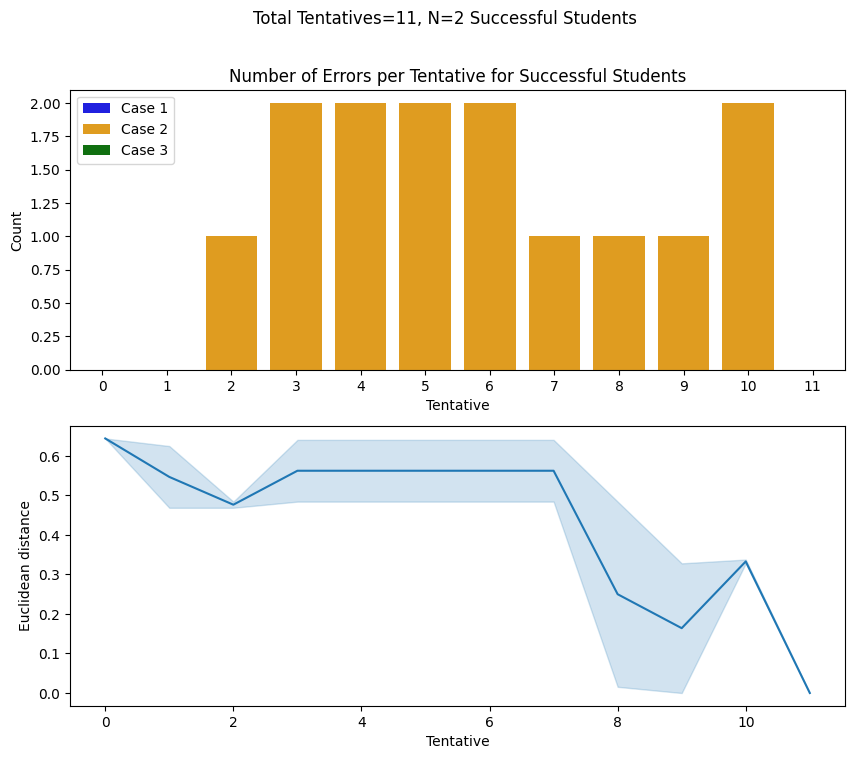

In [740]:
tot_tentatives = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

for i in range(len(tot_tentatives)):
    grouped_data = data[data['nb_tentative'] == tot_tentatives[i]]
    
    count_error_per_tentative_success = grouped_data[grouped_data['success'] == 1].groupby('index').agg({'case1': 'sum', 'case2': 'sum', 'case3':'sum'}).reset_index()
    count_error_per_tentative_fail = grouped_data[grouped_data['success'] == 0].groupby('index').agg({'case1': 'sum', 'case2': 'sum', 'case3':'sum'}).reset_index()

    count_error_per_tentative_success['success'] = 1
    count_error_per_tentative_fail['success'] = 0

    count_error_per_tentative = pd.concat([count_error_per_tentative_success, count_error_per_tentative_fail])
    
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))
    
    sns.barplot(x='index', y='case1', data=count_error_per_tentative_success, color='blue', label='Case 1', ax=axs[0])
    sns.barplot(x='index', y='case2', data=count_error_per_tentative_success, color='orange', label='Case 2', ax=axs[0])
    sns.barplot(x='index', y='case3', data=count_error_per_tentative_success, color='green', label='Case 3', ax=axs[0])
    
    axs[0].set_xlabel('Tentative')
    axs[0].set_ylabel('Count')
    axs[0].legend()
    axs[0].set_title('Number of Errors per Tentative for Successful Students')
    
    nb_success_student = len(grouped_data[grouped_data['success'] == 1]['Student ID'].unique())
    nb_failing_student = len(grouped_data[grouped_data['success'] == 0]['Student ID'].unique())

    sns.lineplot(data=grouped_data[grouped_data['success'] == 1], y=f'euclidean_distance', x='index',
                    err_style="band", errorbar ='ci', estimator=np.mean, ci=95, ax=axs[1], legend=True)
    
    #ax.set_ylim(0, 1)
    #axs[0].set_title(f"Total Tentatives: {tot_tentatives[i]}")
    axs[1].set_xlabel("Tentative")
    axs[1].set_ylabel("Euclidean distance")
    axs[1].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    
        
    plt.suptitle(f"Total Tentatives={tot_tentatives[i]}, N={nb_success_student} Successful Students")
    plt.savefig(f"{folder}/barplot_error_cases_euclidean_tentative_{tot_tentatives[i]}_success.png")
    plt.show()
    

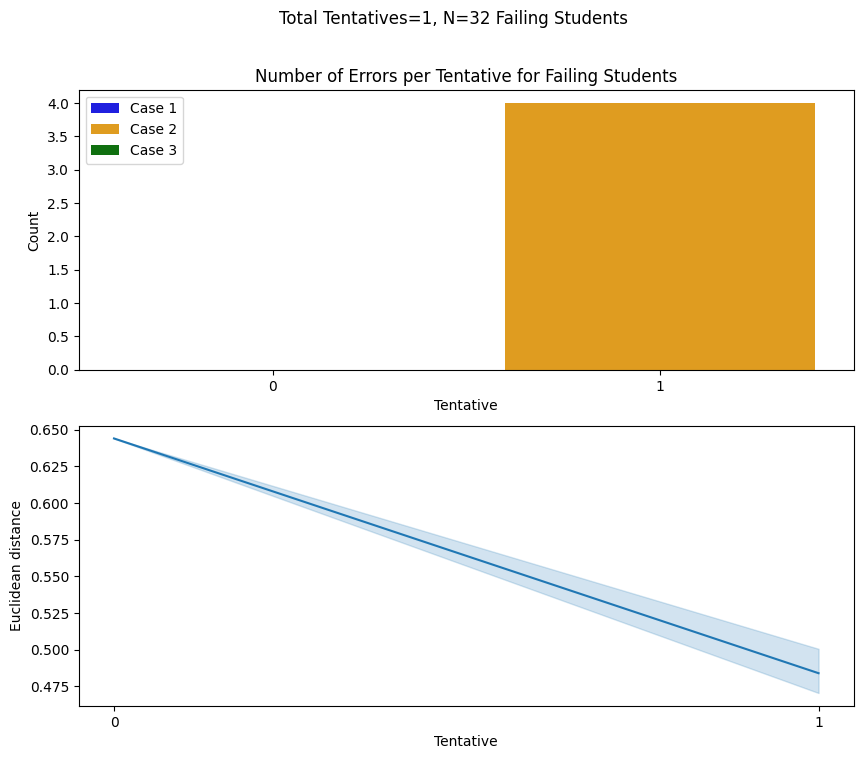

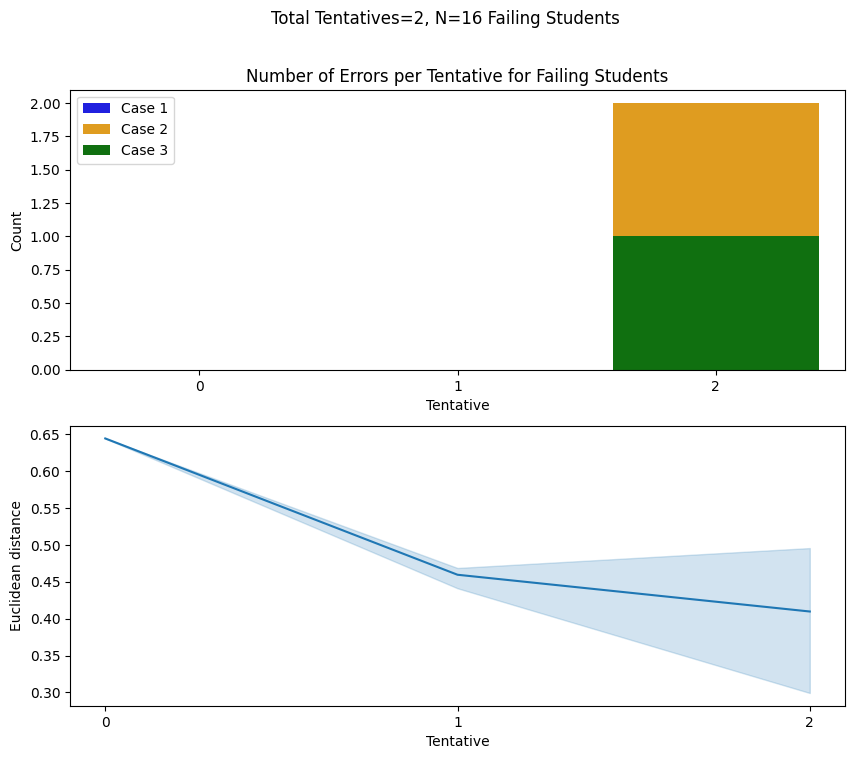

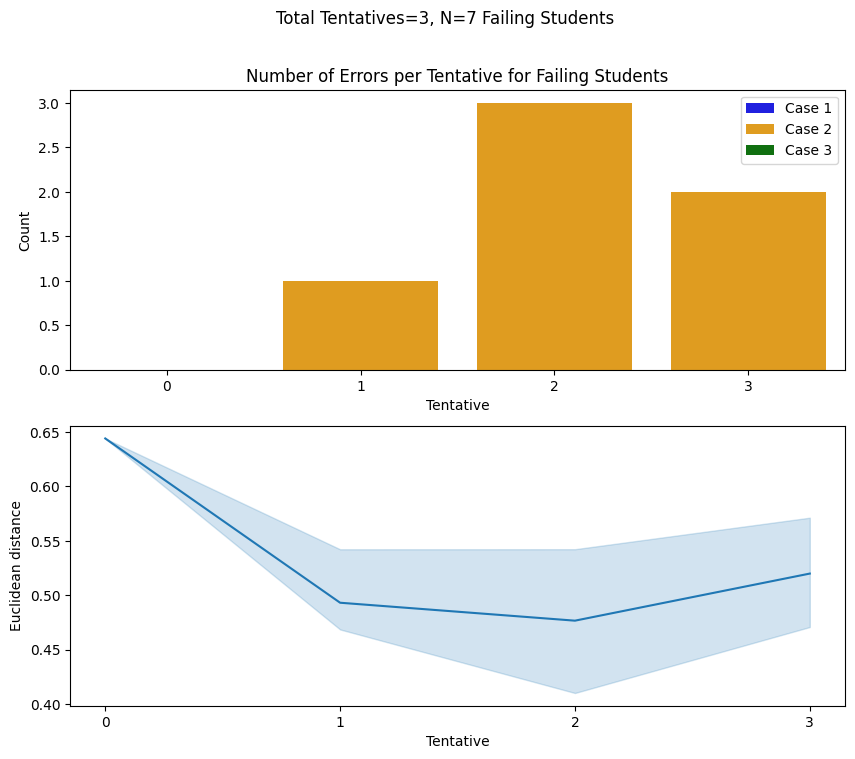

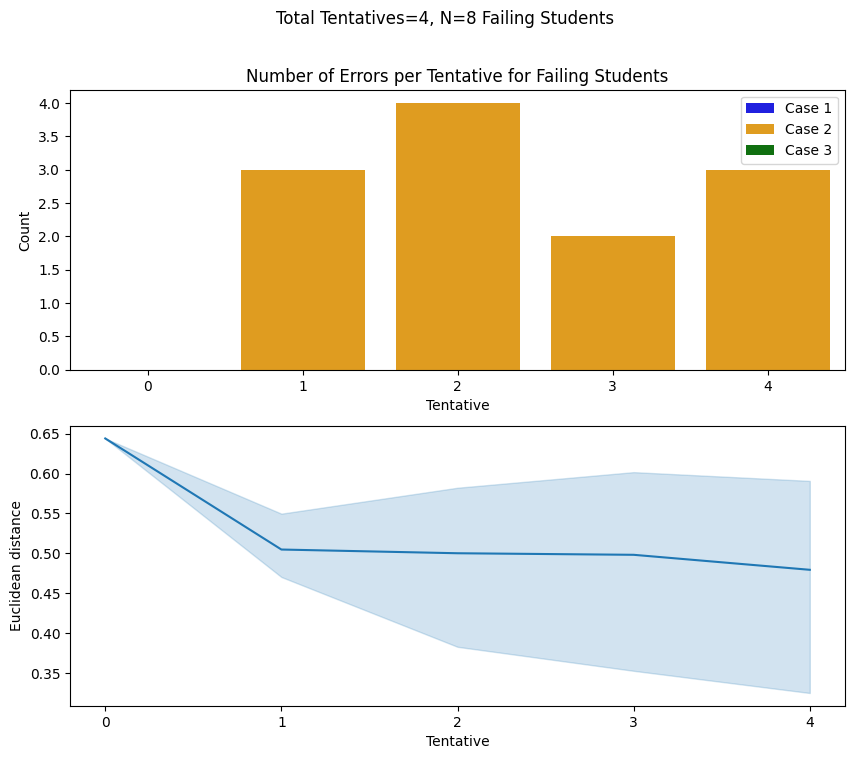

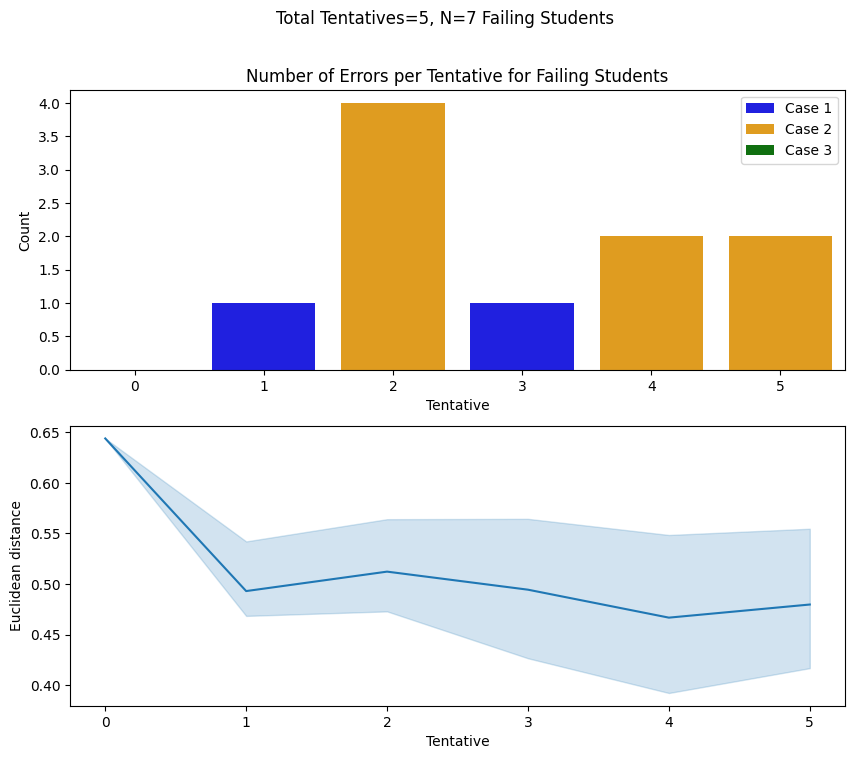

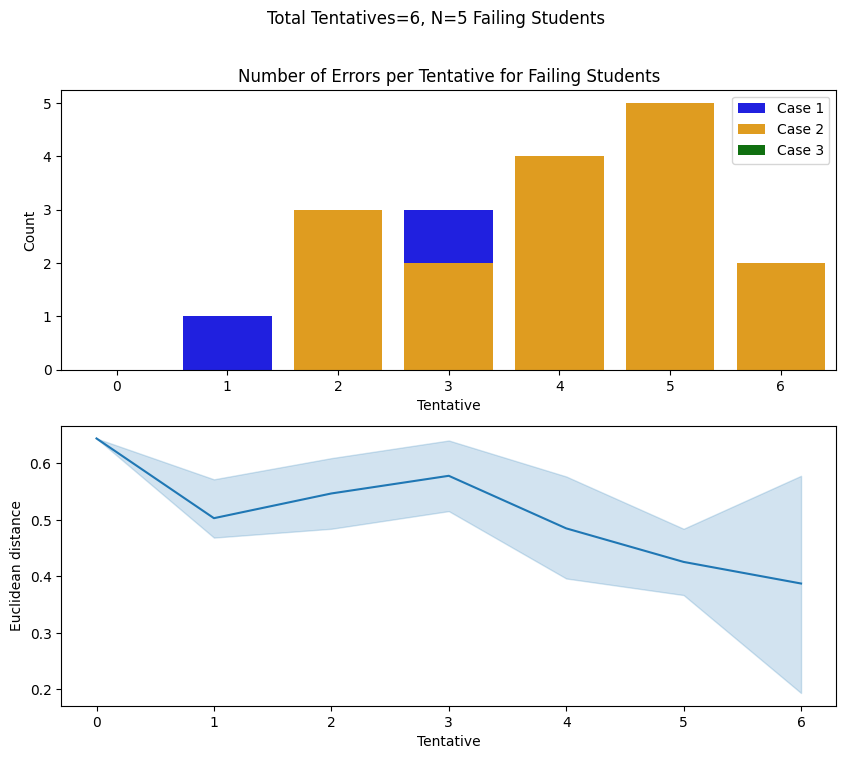

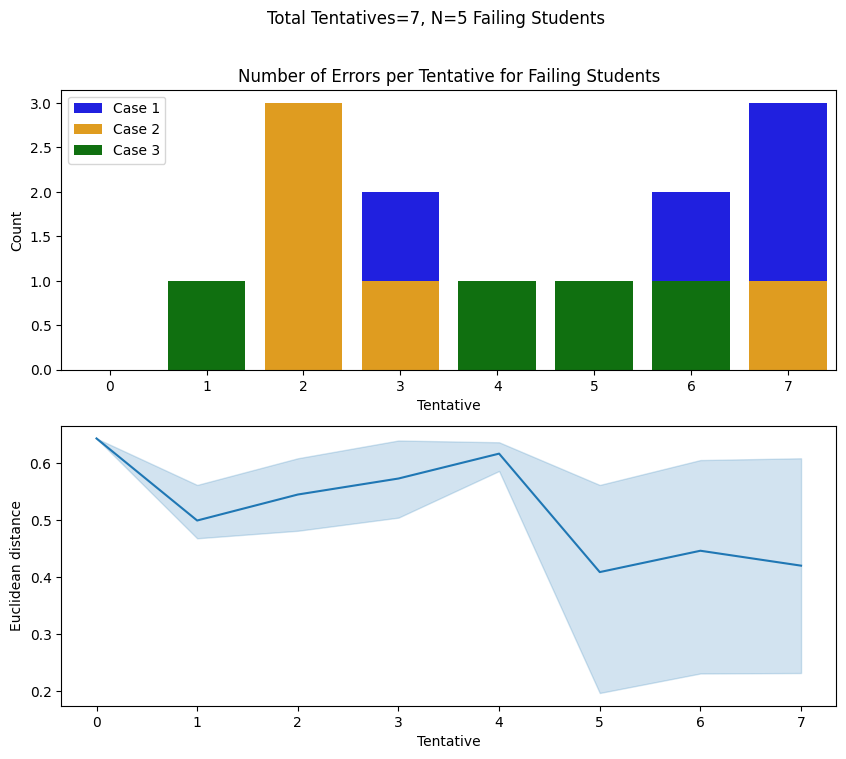

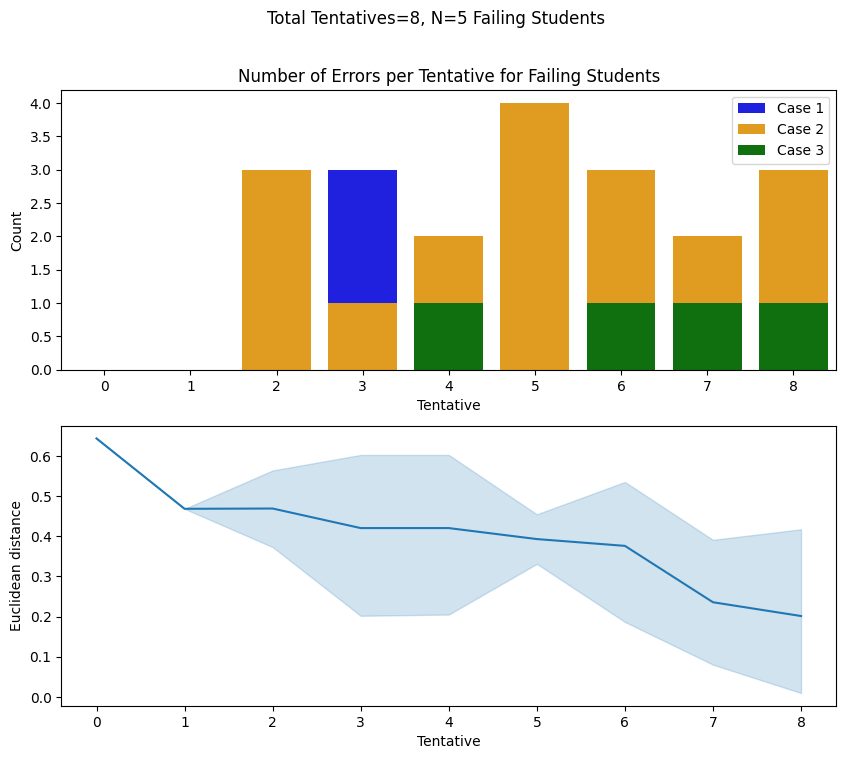

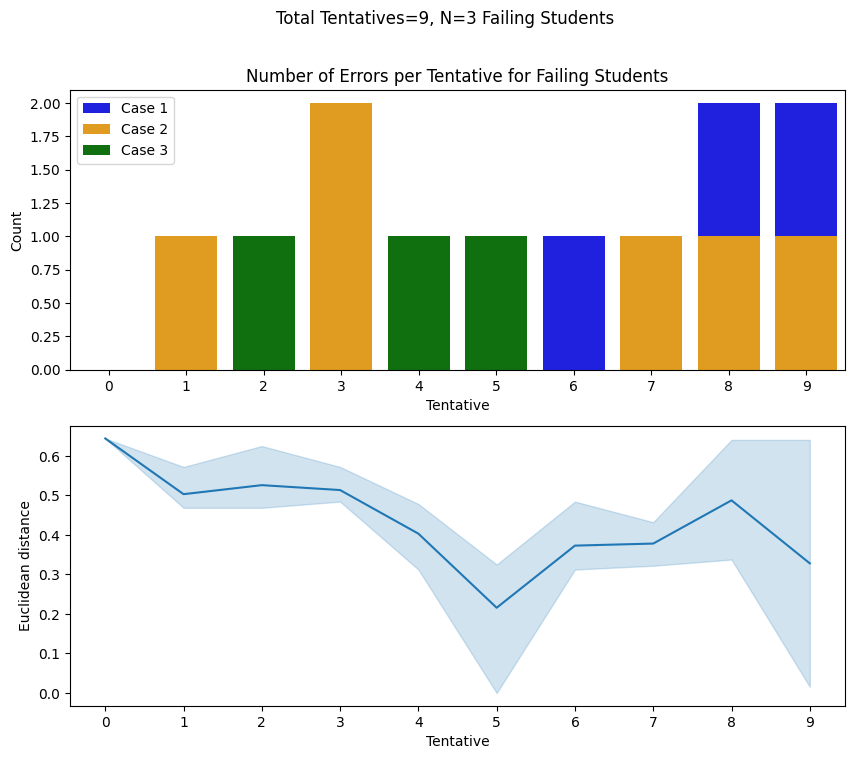

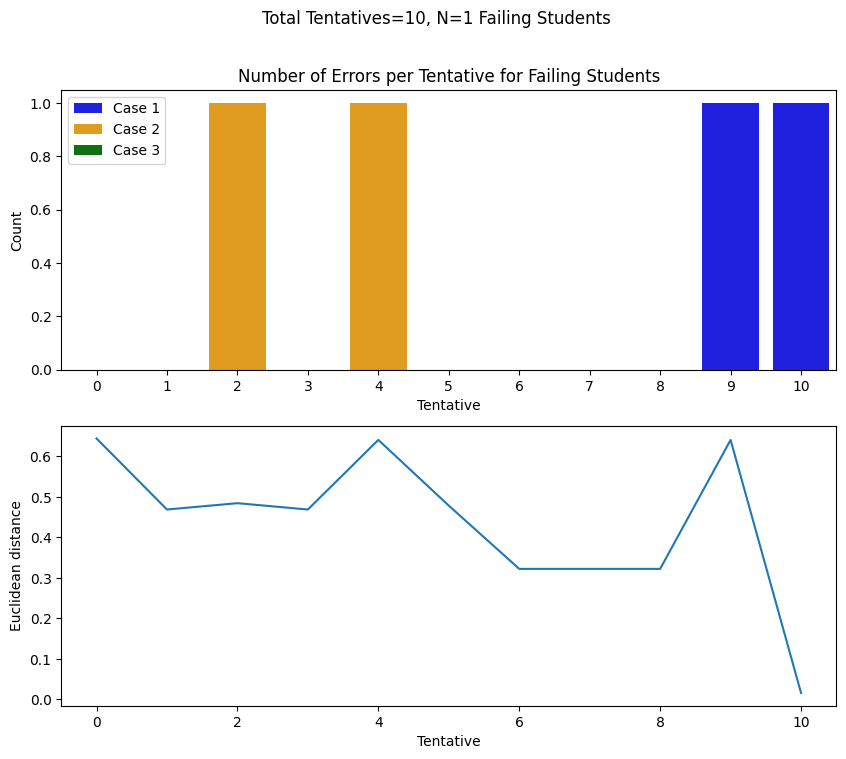

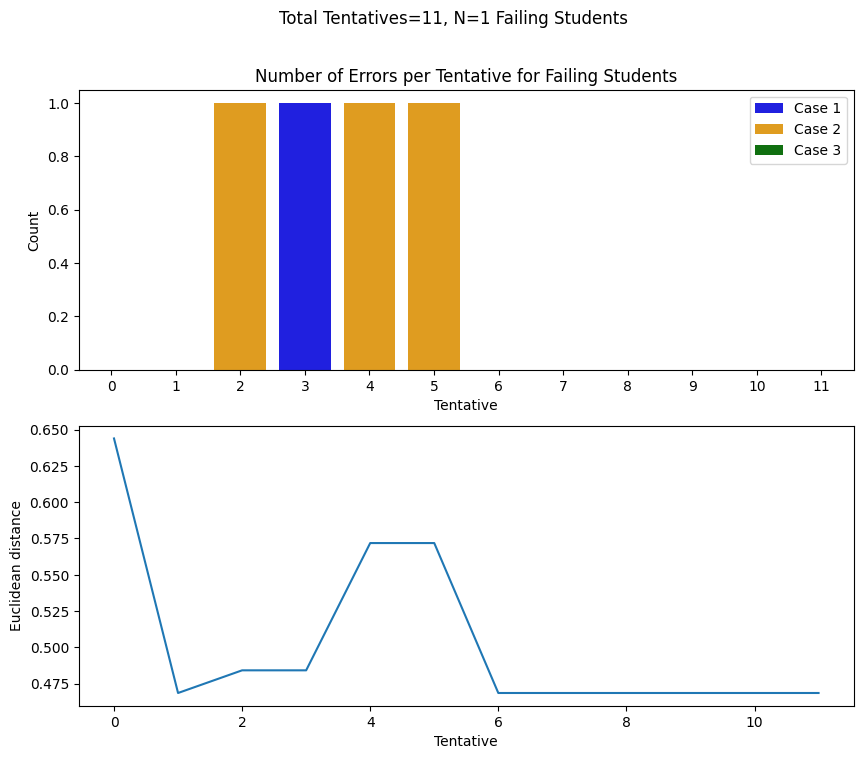

In [741]:
tot_tentatives = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

for i in range(len(tot_tentatives)):
    grouped_data = data[data['nb_tentative'] == tot_tentatives[i]]
    
    count_error_per_tentative_success = grouped_data[grouped_data['success'] == 1].groupby('index').agg({'case1': 'sum', 'case2': 'sum', 'case3':'sum'}).reset_index()
    count_error_per_tentative_fail = grouped_data[grouped_data['success'] == 0].groupby('index').agg({'case1': 'sum', 'case2': 'sum', 'case3':'sum'}).reset_index()

    count_error_per_tentative_success['success'] = 1
    count_error_per_tentative_fail['success'] = 0

    count_error_per_tentative = pd.concat([count_error_per_tentative_success, count_error_per_tentative_fail])
    
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))
    
    sns.barplot(x='index', y='case1', data=count_error_per_tentative_fail, color='blue', label='Case 1', ax=axs[0])
    sns.barplot(x='index', y='case2', data=count_error_per_tentative_fail, color='orange', label='Case 2', ax=axs[0])
    sns.barplot(x='index', y='case3', data=count_error_per_tentative_fail, color='green', label='Case 3', ax=axs[0])
    
    axs[0].set_xlabel('Tentative')
    axs[0].set_ylabel('Count')
    axs[0].legend()
    axs[0].set_title('Number of Errors per Tentative for Failing Students')
    
    nb_success_student = len(grouped_data[grouped_data['success'] == 1]['Student ID'].unique())
    nb_failing_student = len(grouped_data[grouped_data['success'] == 0]['Student ID'].unique())

    sns.lineplot(data=grouped_data[grouped_data['success'] == 0], y=f'euclidean_distance', x='index',
                    err_style="band", errorbar ='ci', estimator=np.mean, ci=95, ax=axs[1], legend=True)
    
    #ax.set_ylim(0, 1)
    #axs[0].set_title(f"Total Tentatives: {tot_tentatives[i]}")
    axs[1].set_xlabel("Tentative")
    axs[1].set_ylabel("Euclidean distance")
    axs[1].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    
        
    plt.suptitle(f"Total Tentatives={tot_tentatives[i]}, N={nb_failing_student} Failing Students")
    plt.savefig(f"{folder}/barplot_error_cases_euclidean_tentative_{tot_tentatives[i]}_fail.png")
    plt.show()
    

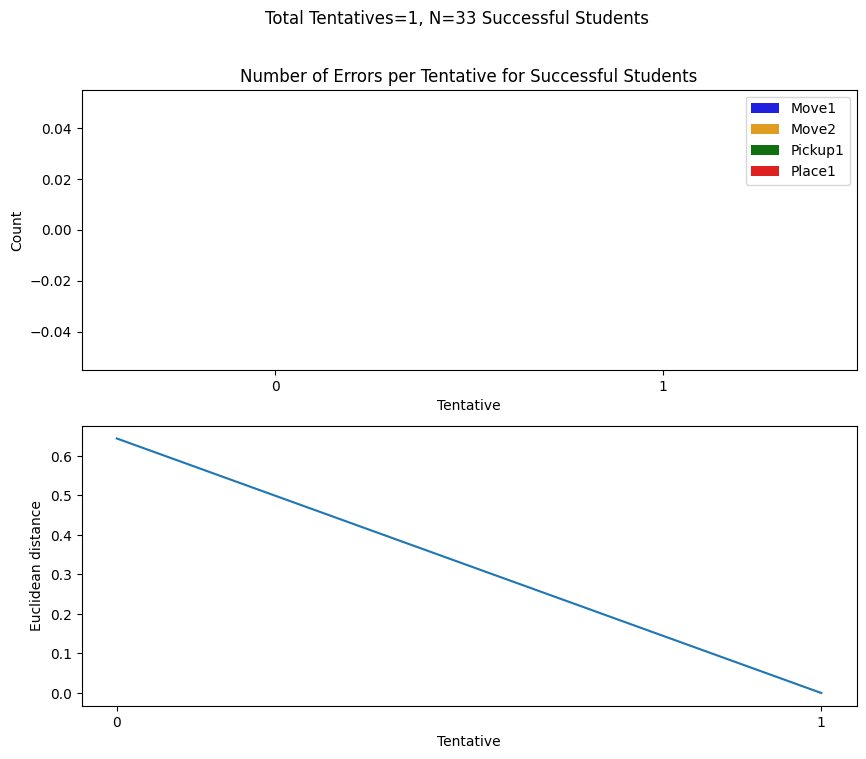

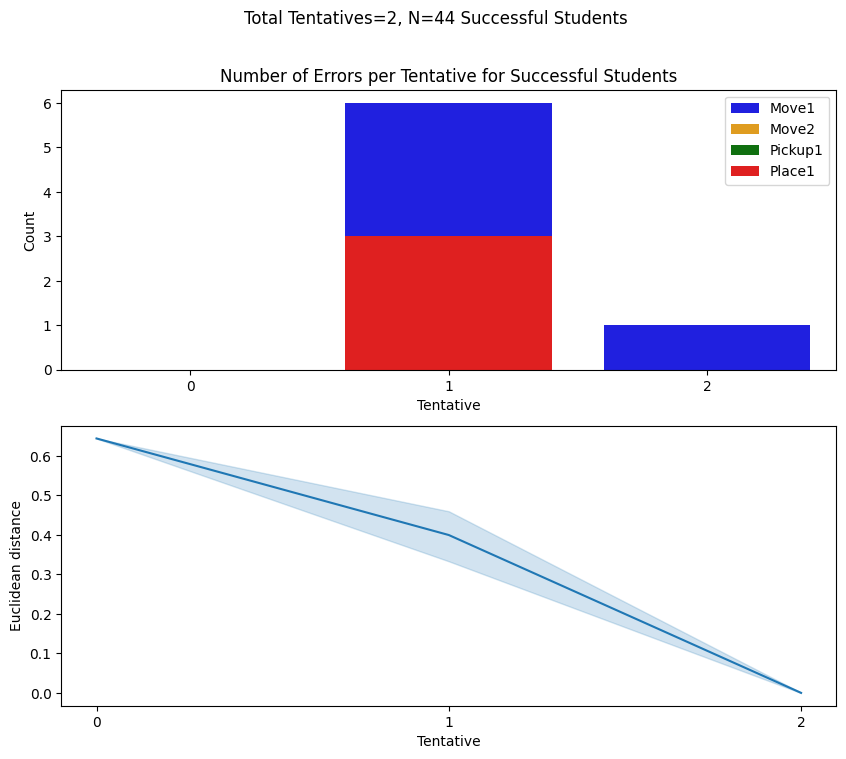

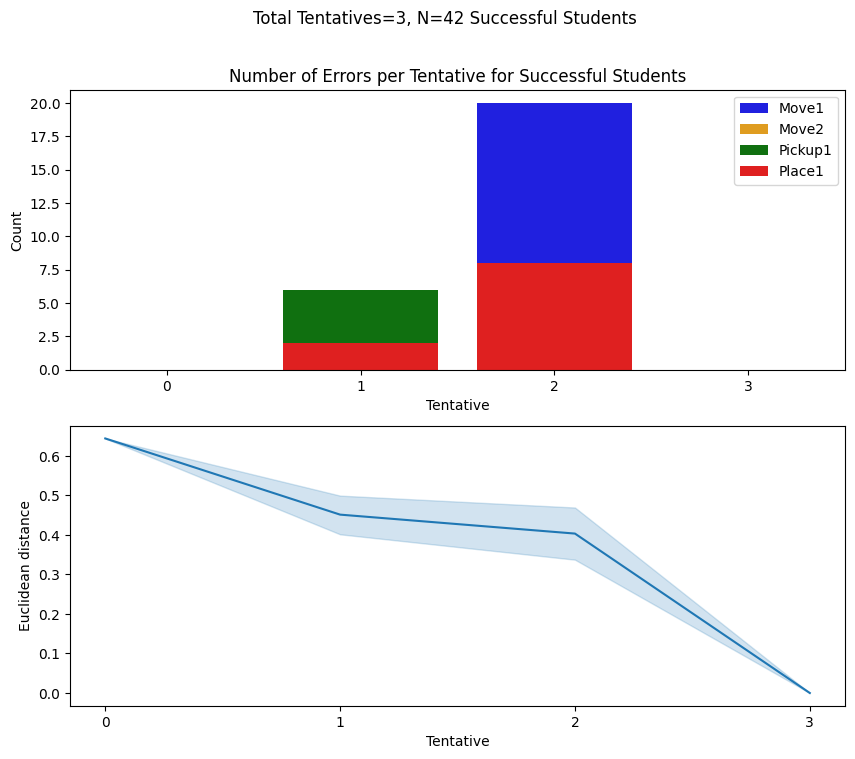

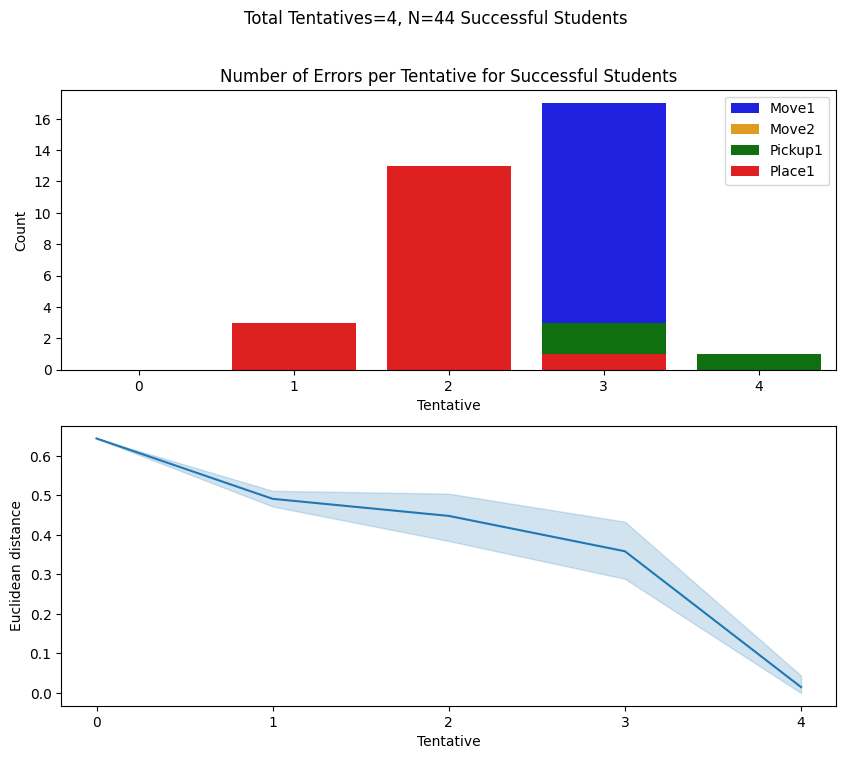

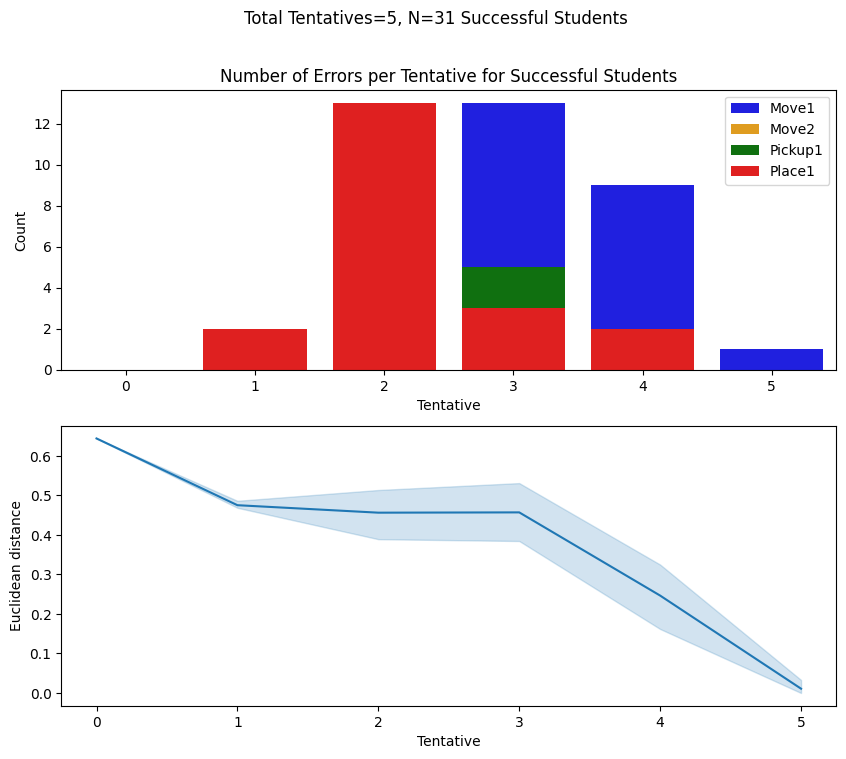

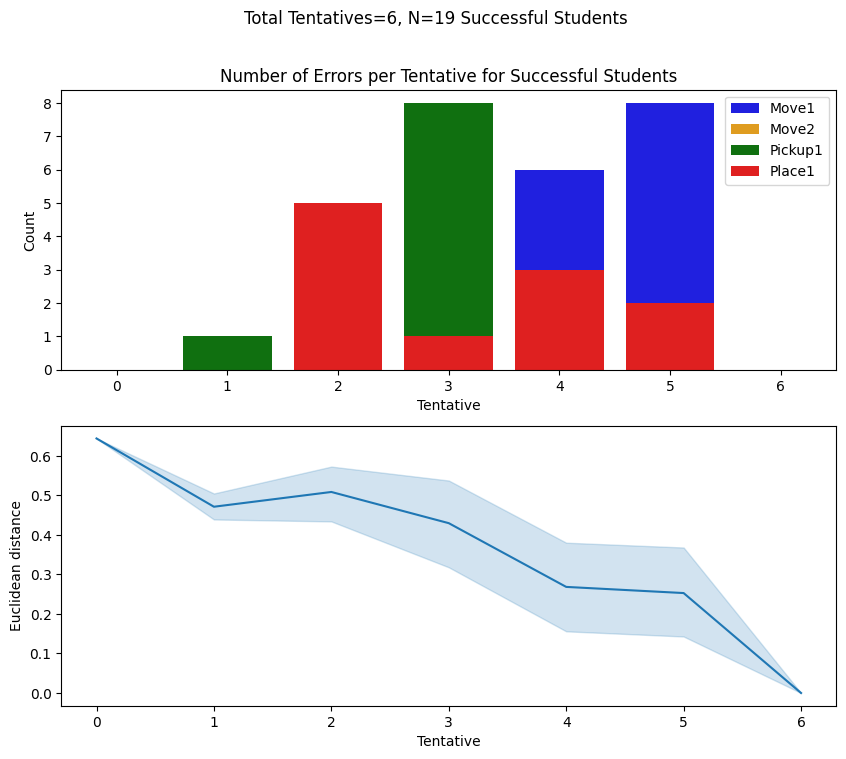

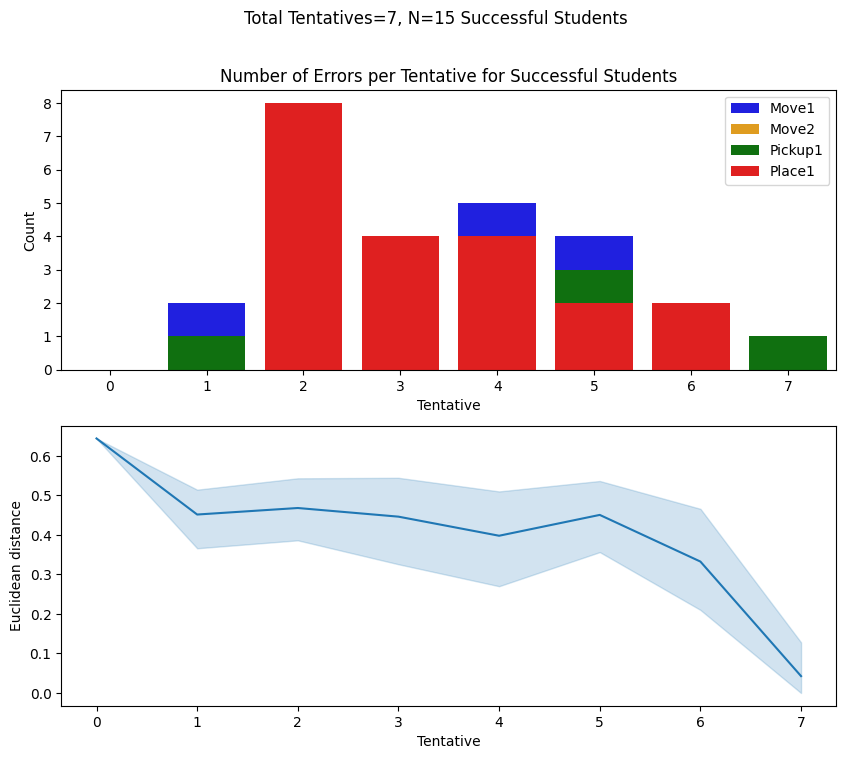

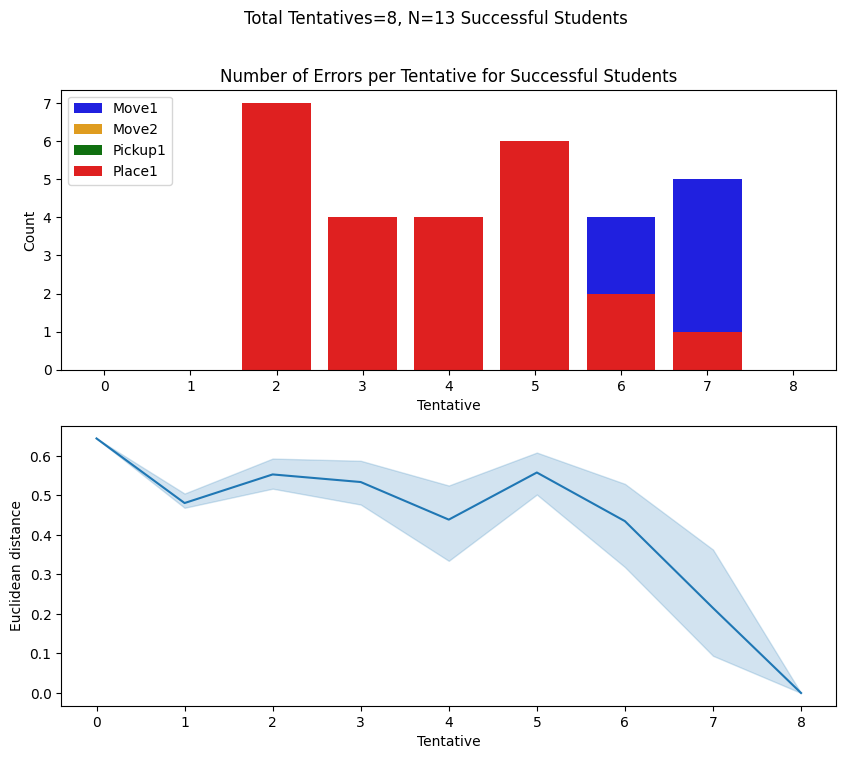

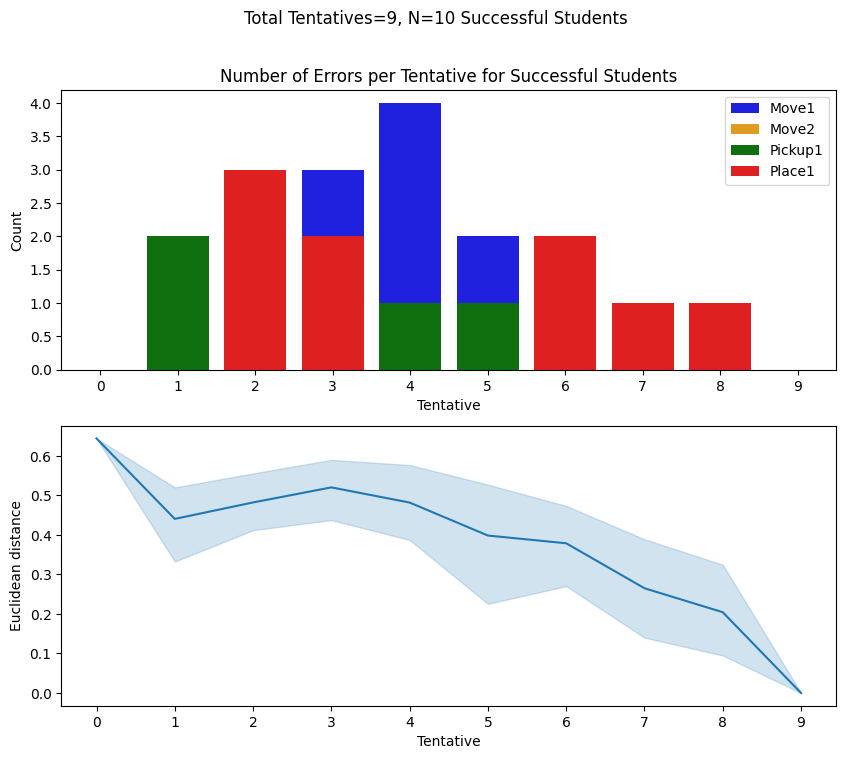

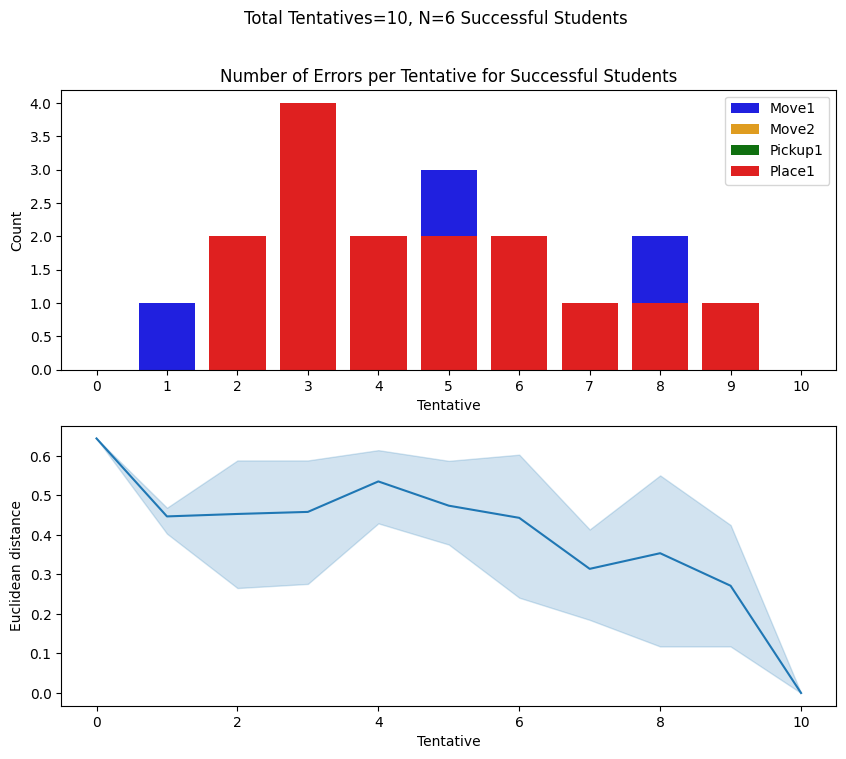

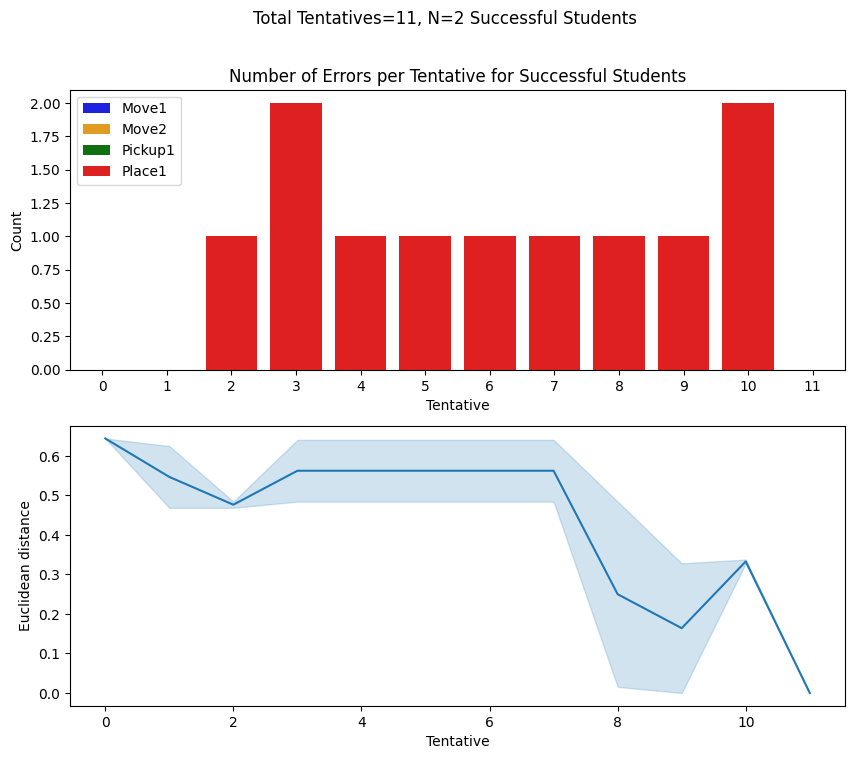

In [742]:
tot_tentatives = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

for i in range(len(tot_tentatives)):
    grouped_data = data[data['nb_tentative'] == tot_tentatives[i]]
    
    count_error_per_tentative_success = grouped_data[grouped_data['success'] == 1].groupby('index').agg({'move1': 'sum', 'move2': 'sum', 'pickup1':'sum', 'place1': 'sum'}).reset_index()
    count_error_per_tentative_fail = grouped_data[grouped_data['success'] == 0].groupby('index').agg({'move1': 'sum', 'move2': 'sum', 'pickup1':'sum', 'place1': 'sum'}).reset_index()

    count_error_per_tentative_success['success'] = 1
    count_error_per_tentative_fail['success'] = 0

    count_error_per_tentative = pd.concat([count_error_per_tentative_success, count_error_per_tentative_fail])
    
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))
    
    sns.barplot(x='index', y='move1', data=count_error_per_tentative_success, color='blue', label='Move1', ax=axs[0])
    sns.barplot(x='index', y='move2', data=count_error_per_tentative_success, color='orange', label='Move2', ax=axs[0])
    sns.barplot(x='index', y='pickup1', data=count_error_per_tentative_success, color='green', label='Pickup1', ax=axs[0])
    sns.barplot(x='index', y='place1', data=count_error_per_tentative_success, color='red', label='Place1', ax=axs[0])
    
    axs[0].set_xlabel('Tentative')
    axs[0].set_ylabel('Count')
    axs[0].legend()
    axs[0].set_title('Number of Errors per Tentative for Successful Students')
    
    nb_success_student = len(grouped_data[grouped_data['success'] == 1]['Student ID'].unique())
    nb_failing_student = len(grouped_data[grouped_data['success'] == 0]['Student ID'].unique())

    sns.lineplot(data=grouped_data[grouped_data['success'] == 1], y=f'euclidean_distance', x='index',
                    err_style="band", errorbar ='ci', estimator=np.mean, ci=95, ax=axs[1], legend=True)
    
    #ax.set_ylim(0, 1)
    #axs[0].set_title(f"Total Tentatives: {tot_tentatives[i]}")
    axs[1].set_xlabel("Tentative")
    axs[1].set_ylabel("Euclidean distance")
    axs[1].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    
    plt.suptitle(f"Total Tentatives={tot_tentatives[i]}, N={nb_success_student} Successful Students")
    plt.savefig(f"{folder}/barplot_error_actions_euclidean_tentative_{tot_tentatives[i]}_success.png")
    plt.show()
    

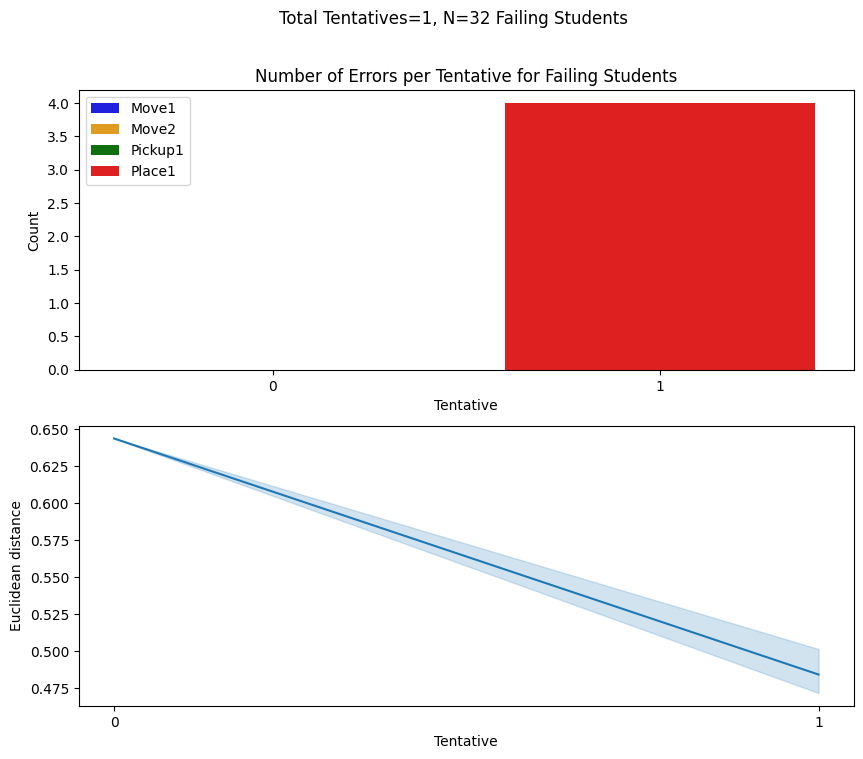

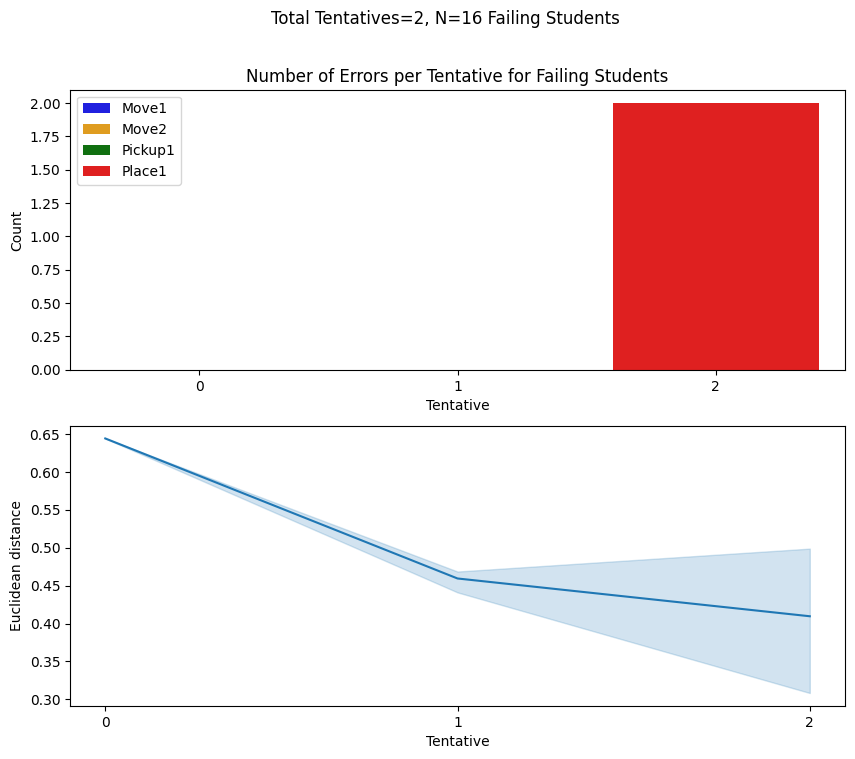

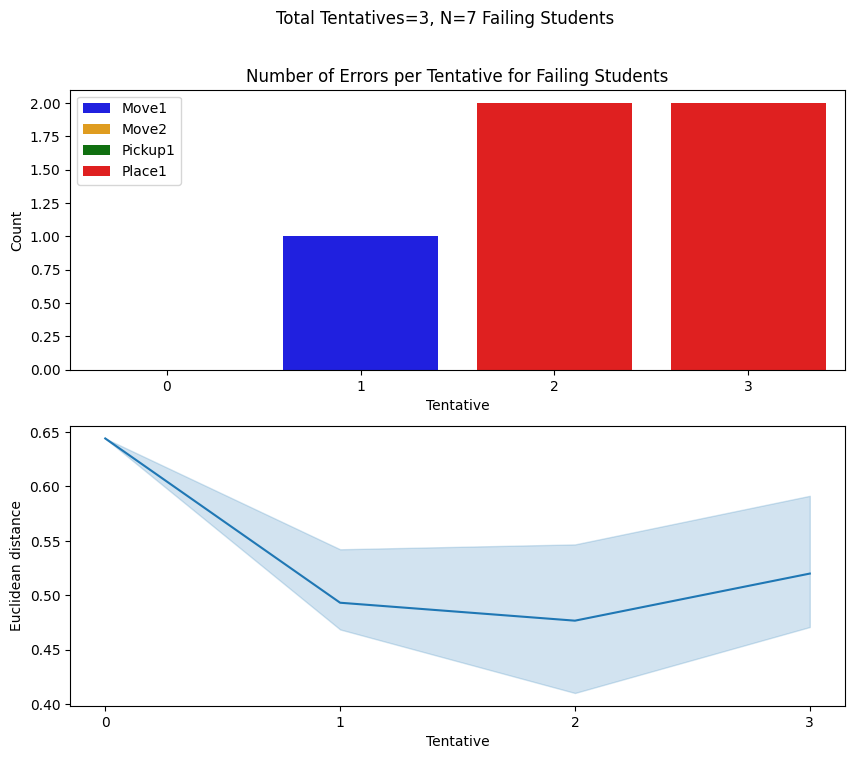

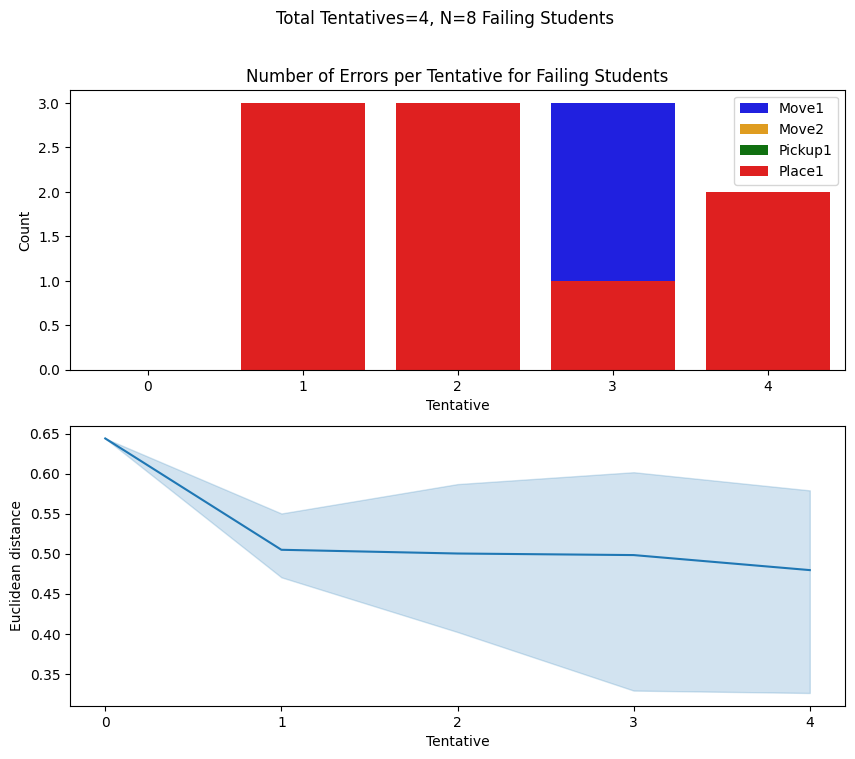

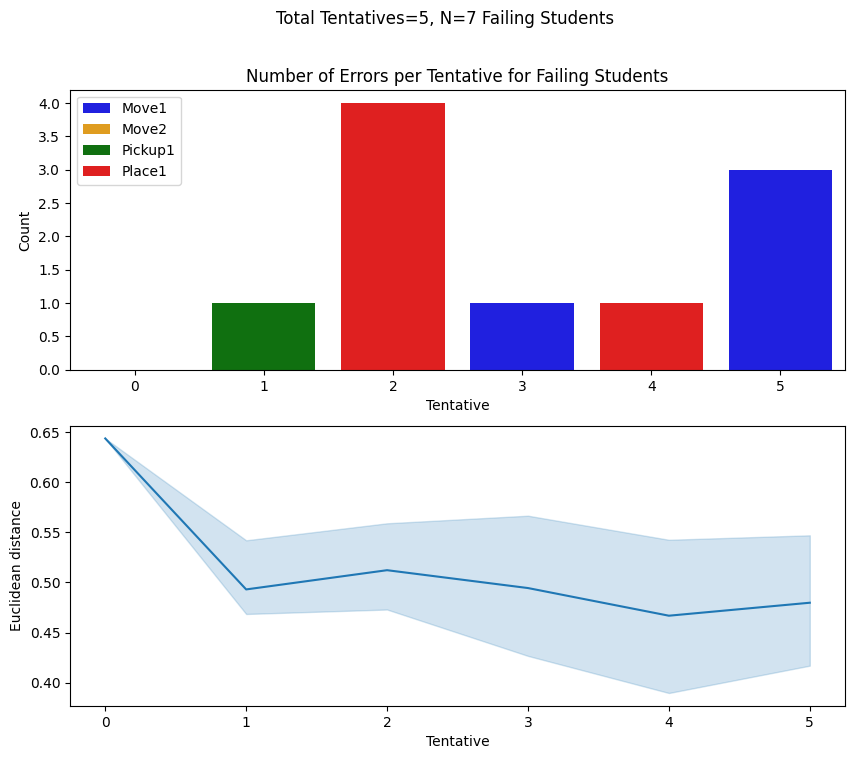

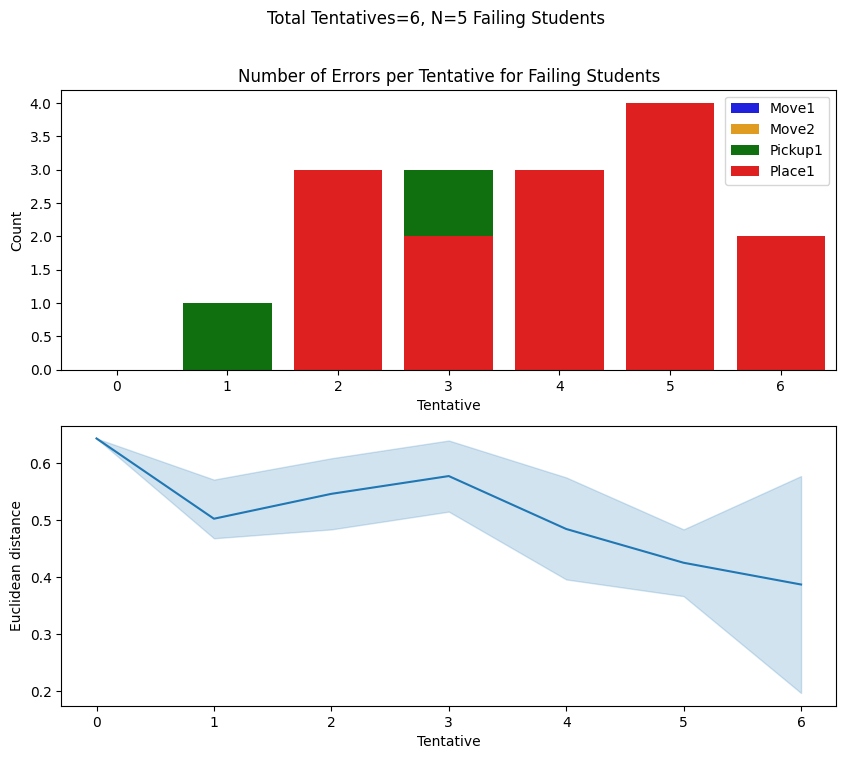

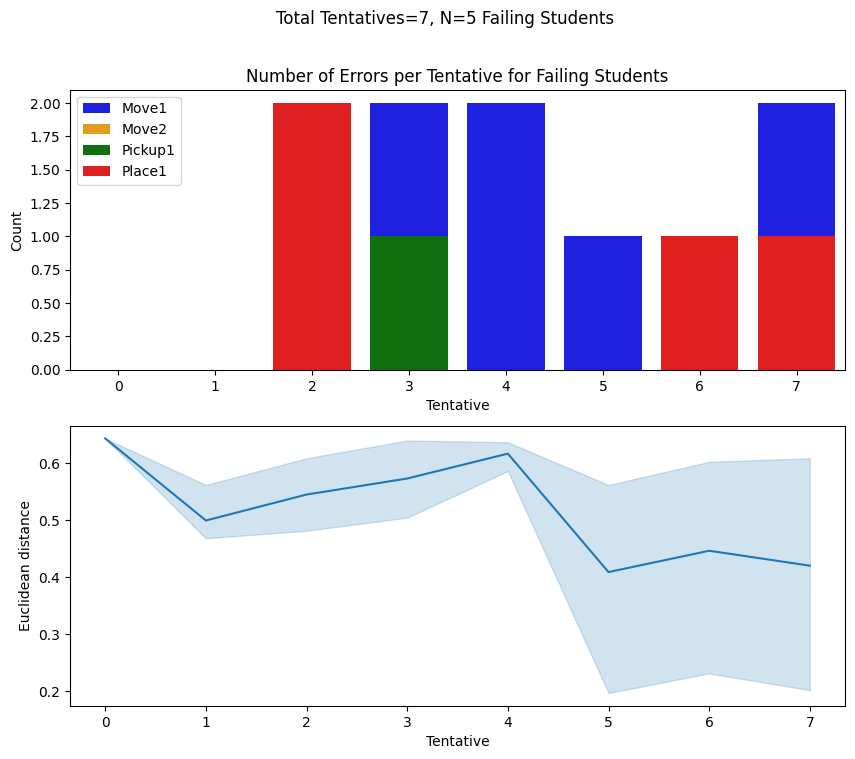

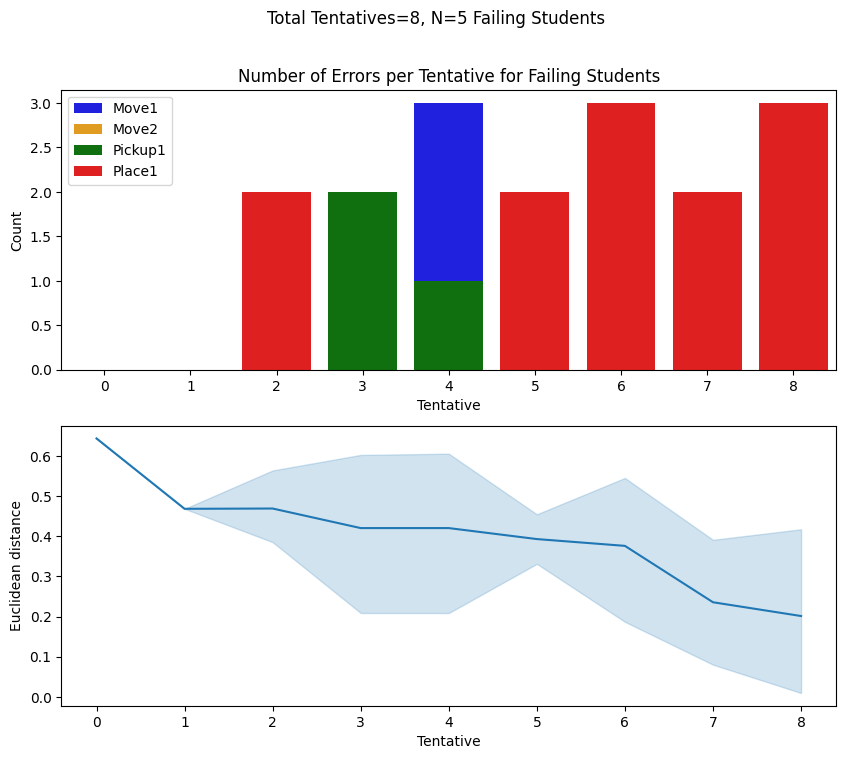

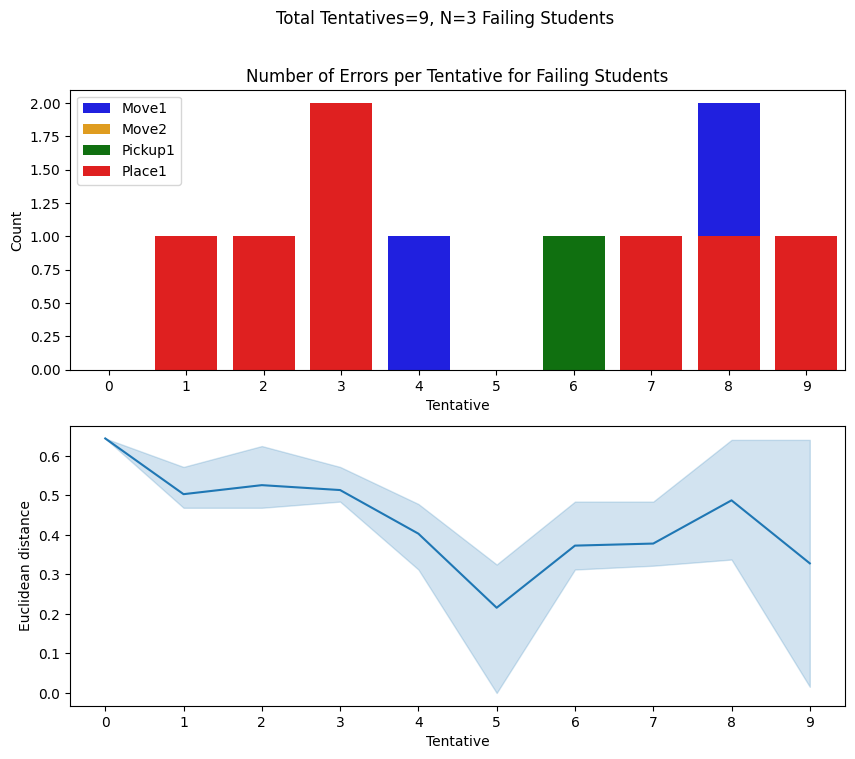

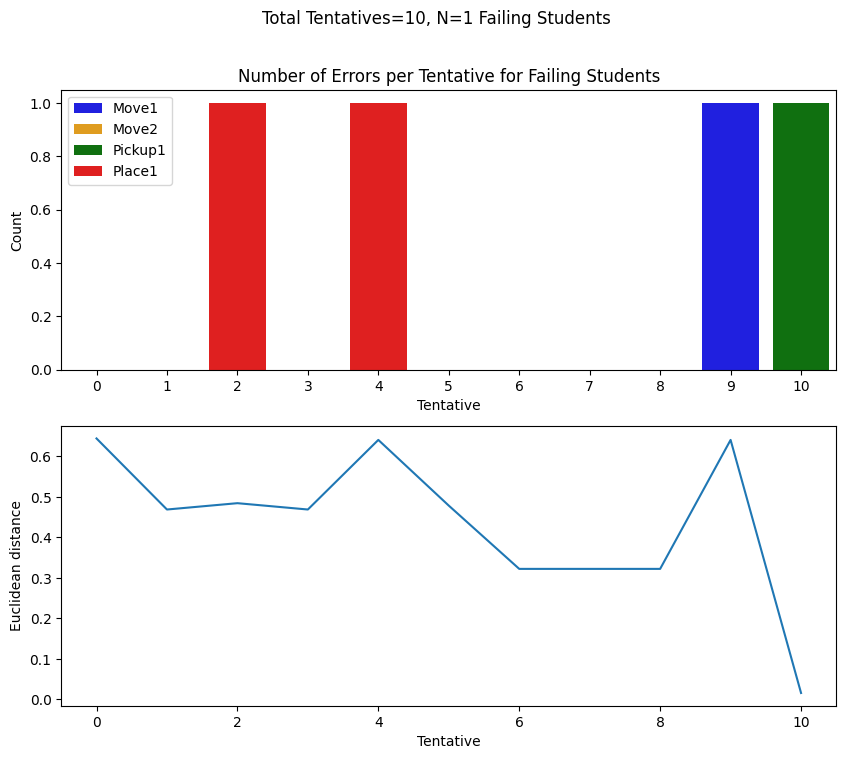

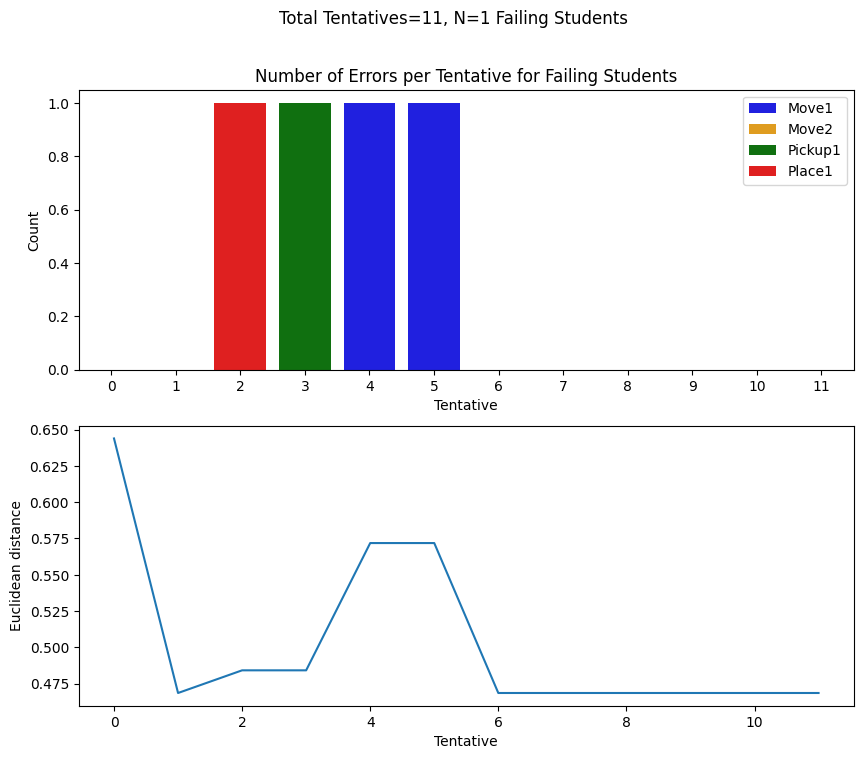

In [743]:
tot_tentatives = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

for i in range(len(tot_tentatives)):
    grouped_data = data[data['nb_tentative'] == tot_tentatives[i]]
    
    count_error_per_tentative_success = grouped_data[grouped_data['success'] == 1].groupby('index').agg({'move1': 'sum', 'move2': 'sum', 'pickup1':'sum', 'place1': 'sum'}).reset_index()
    count_error_per_tentative_fail = grouped_data[grouped_data['success'] == 0].groupby('index').agg({'move1': 'sum', 'move2': 'sum', 'pickup1':'sum', 'place1': 'sum'}).reset_index()

    count_error_per_tentative_success['success'] = 1
    count_error_per_tentative_fail['success'] = 0

    count_error_per_tentative = pd.concat([count_error_per_tentative_success, count_error_per_tentative_fail])
    
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))
    
    sns.barplot(x='index', y='move1', data=count_error_per_tentative_fail, color='blue', label='Move1', ax=axs[0])
    sns.barplot(x='index', y='move2', data=count_error_per_tentative_fail, color='orange', label='Move2', ax=axs[0])
    sns.barplot(x='index', y='pickup1', data=count_error_per_tentative_fail, color='green', label='Pickup1', ax=axs[0])
    sns.barplot(x='index', y='place1', data=count_error_per_tentative_fail, color='red', label='Place1', ax=axs[0])
    
    axs[0].set_xlabel('Tentative')
    axs[0].set_ylabel('Count')
    axs[0].legend()
    axs[0].set_title('Number of Errors per Tentative for Failing Students')
    
    nb_success_student = len(grouped_data[grouped_data['success'] == 1]['Student ID'].unique())
    nb_failing_student = len(grouped_data[grouped_data['success'] == 0]['Student ID'].unique())

    sns.lineplot(data=grouped_data[grouped_data['success'] == 0], y=f'euclidean_distance', x='index',
                    err_style="band", errorbar ='ci', estimator=np.mean, ci=95, ax=axs[1], legend=True)
    
    #ax.set_ylim(0, 1)
    #axs[0].set_title(f"Total Tentatives: {tot_tentatives[i]}")
    axs[1].set_xlabel("Tentative")
    axs[1].set_ylabel("Euclidean distance")
    axs[1].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    
        
    plt.suptitle(f"Total Tentatives={tot_tentatives[i]}, N={nb_failing_student} Failing Students")
    plt.savefig(f"{folder}/barplot_error_actions_euclidean_tentative_{tot_tentatives[i]}_fail.png")
    plt.show()
    

## Let's observe now what happens with successive distances

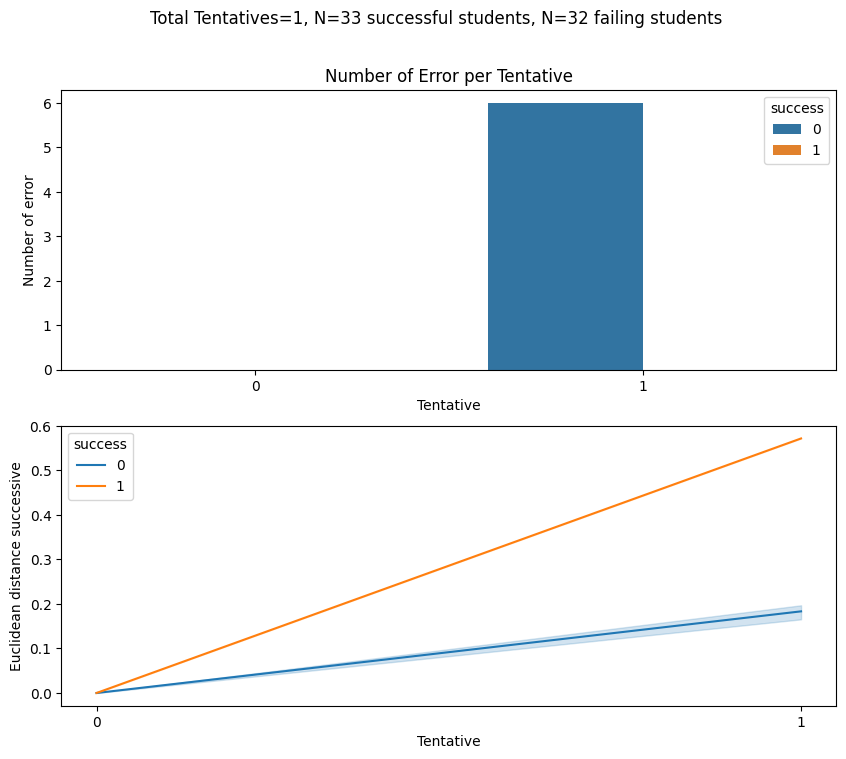

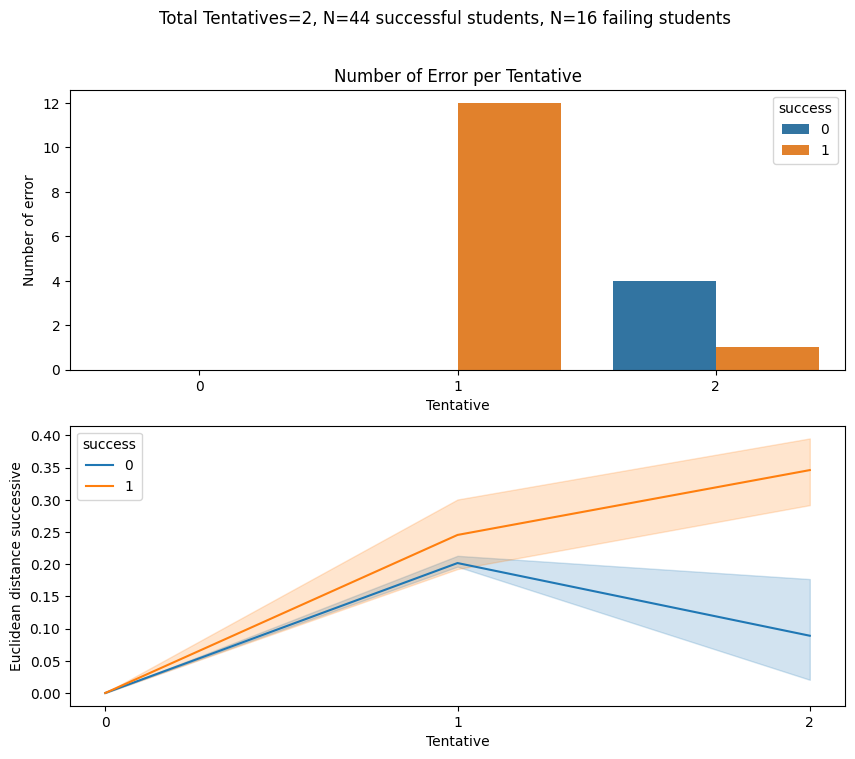

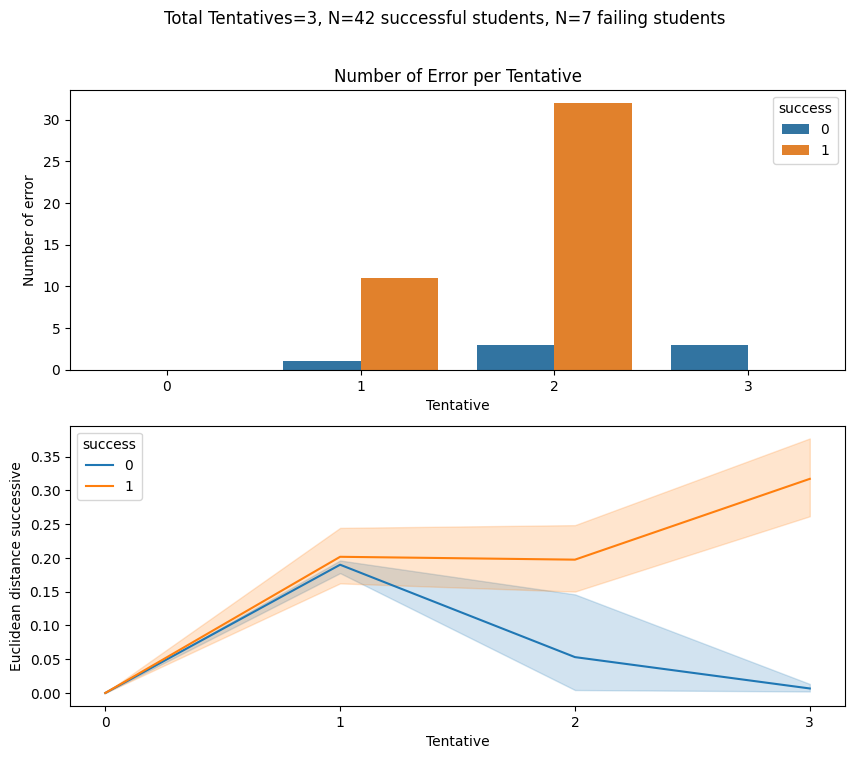

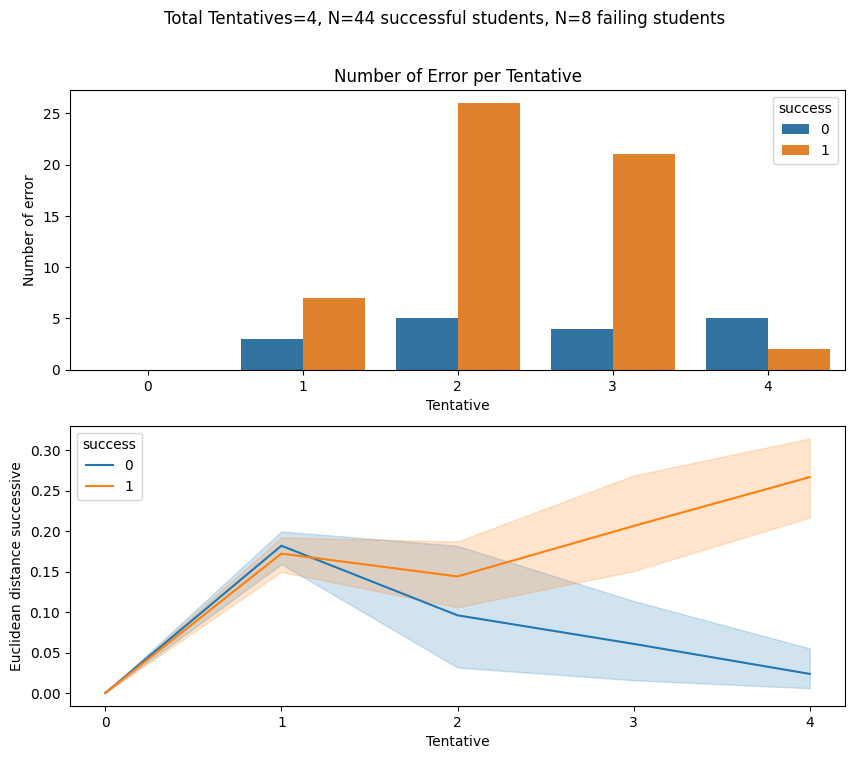

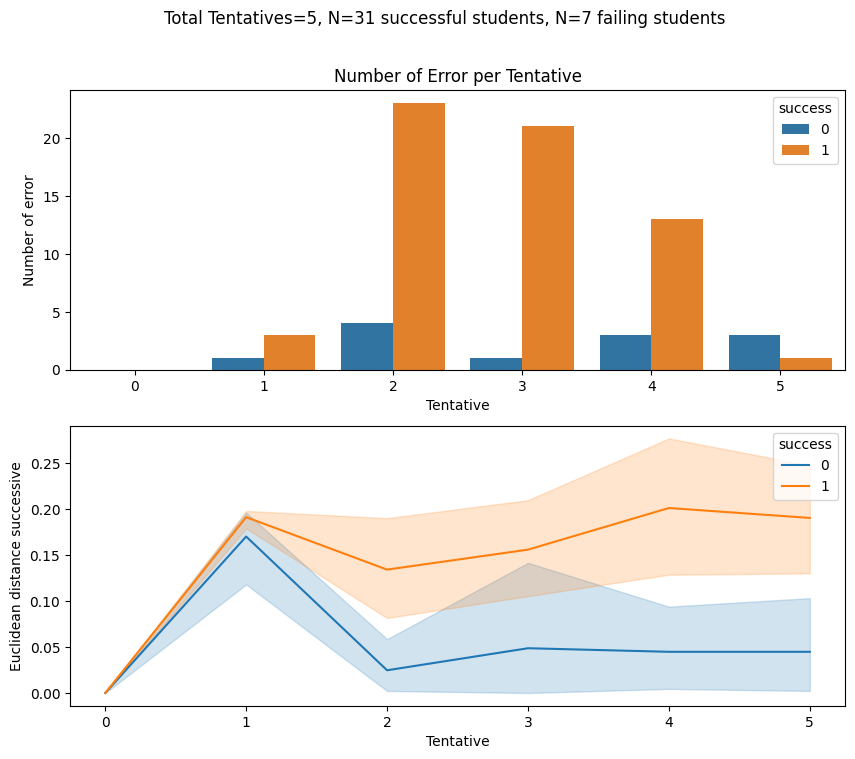

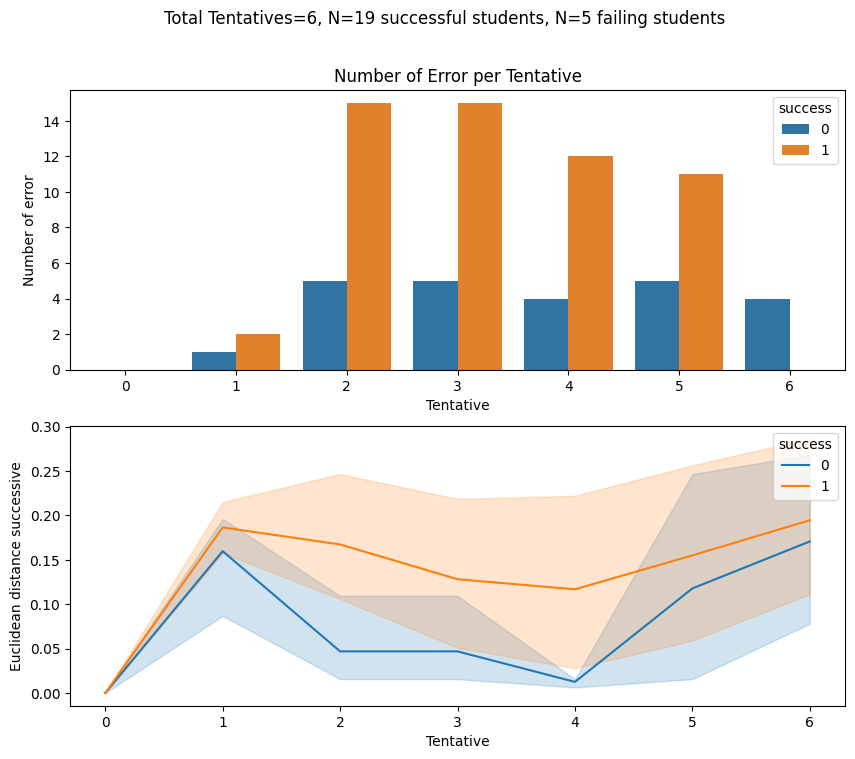

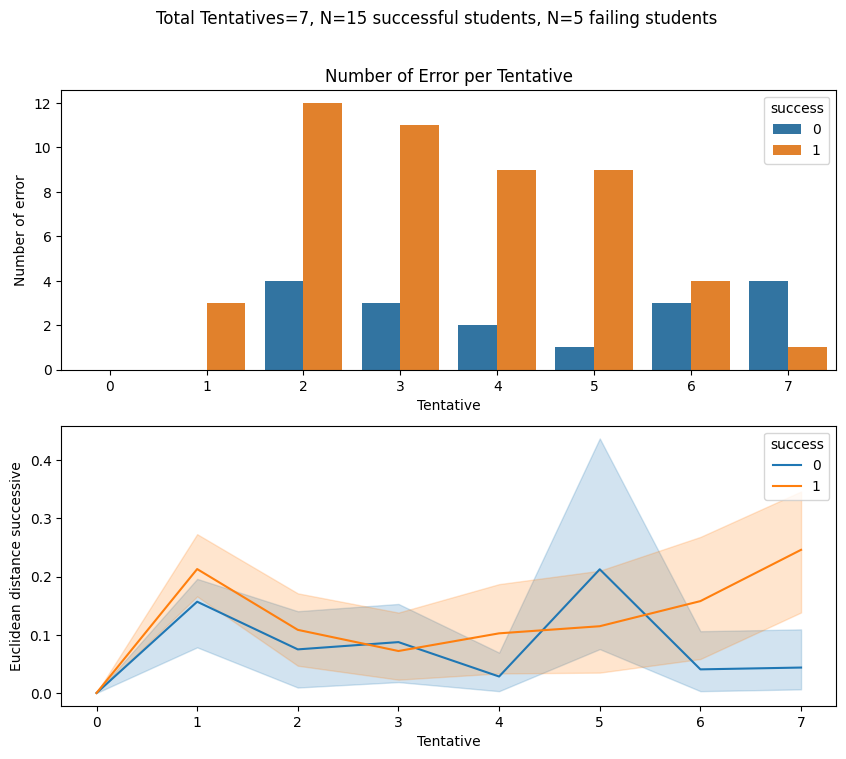

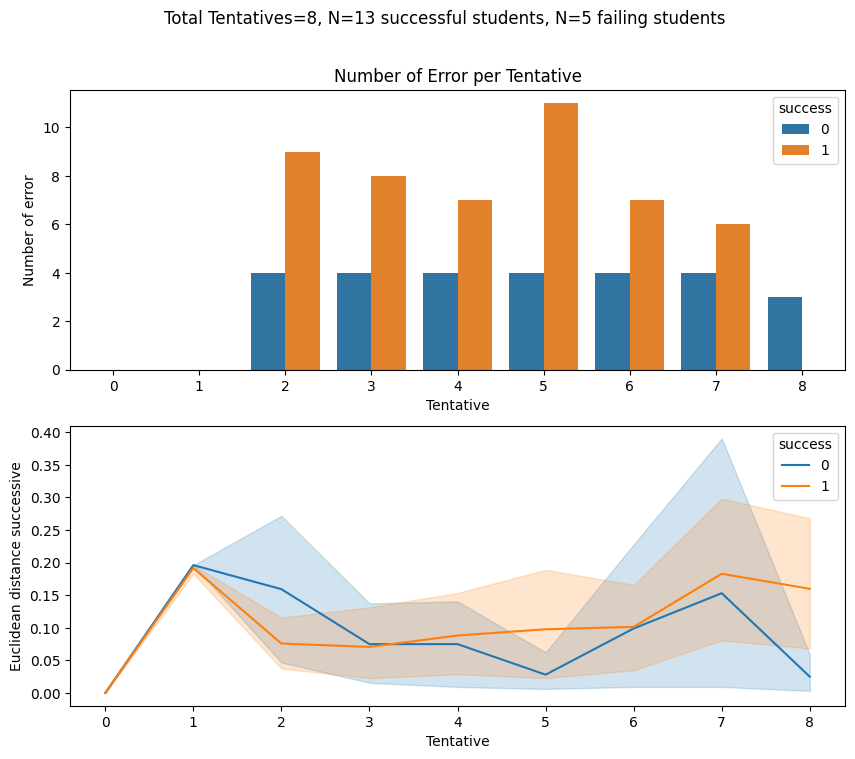

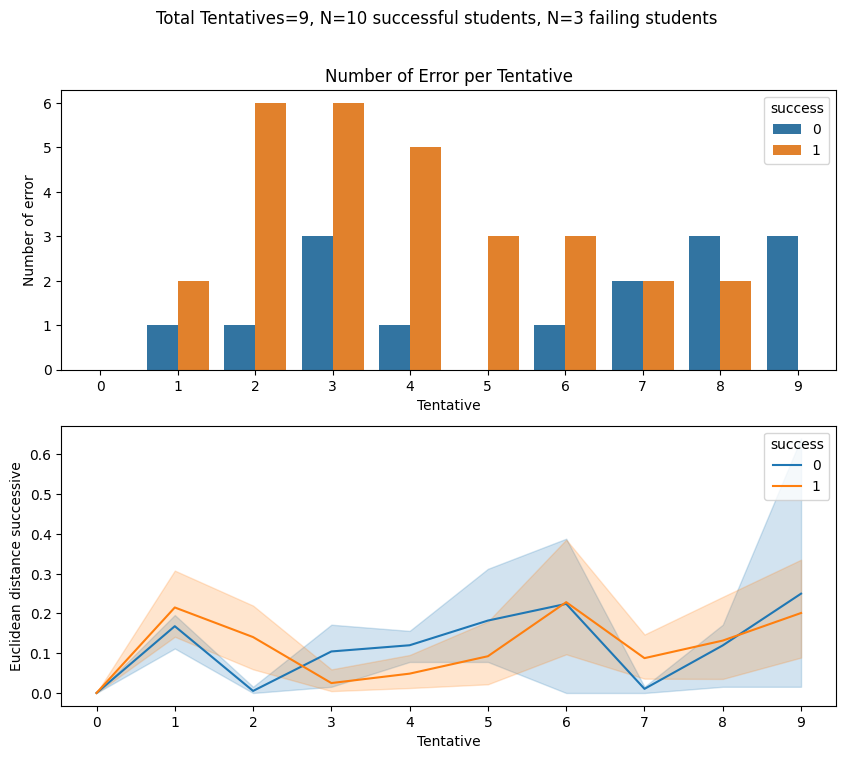

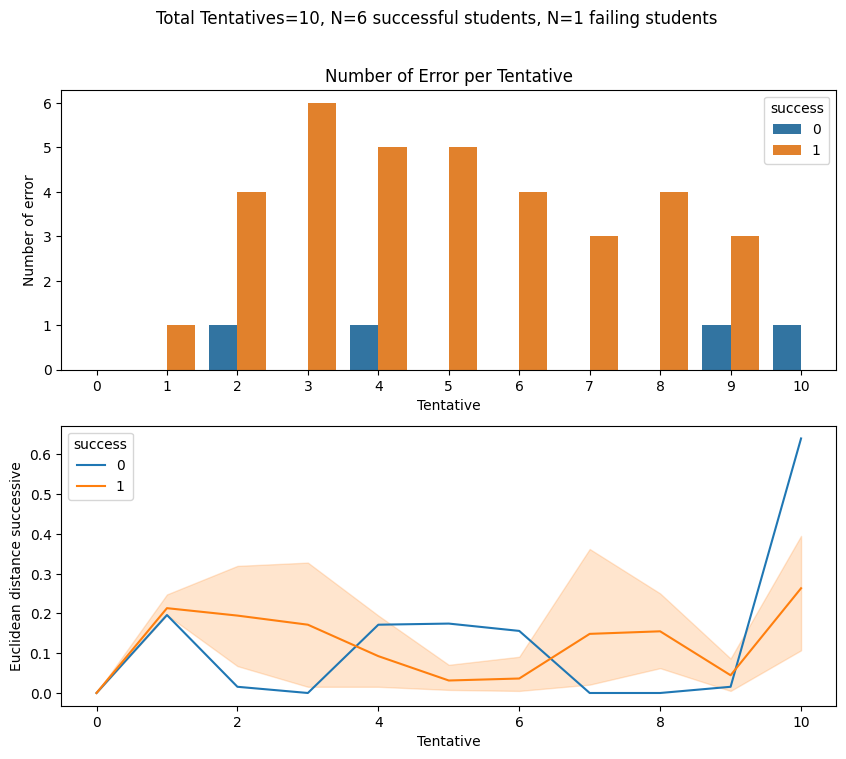

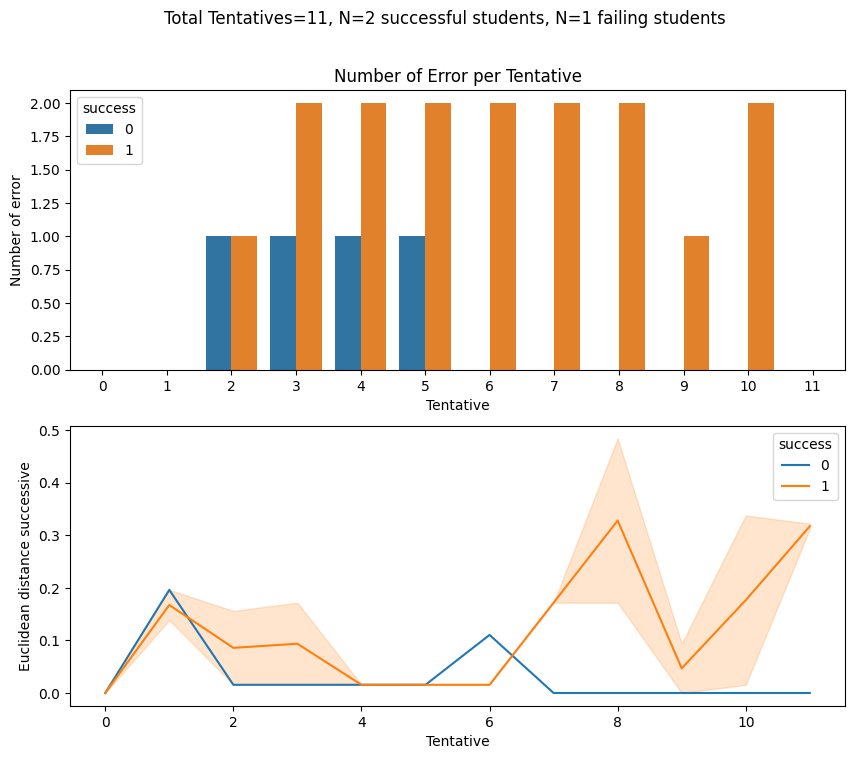

In [744]:
tot_tentatives = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

for i in range(len(tot_tentatives)):
    grouped_data = data[data['nb_tentative'] == tot_tentatives[i]]
    
    count_error_per_tentative_success = grouped_data[grouped_data['success'] == 1].groupby('index').agg({'error': 'sum'}).reset_index()
    count_error_per_tentative_fail = grouped_data[grouped_data['success'] == 0].groupby('index').agg({'error': 'sum'}).reset_index()

    count_error_per_tentative_success['success'] = 1
    count_error_per_tentative_fail['success'] = 0

    count_error_per_tentative = pd.concat([count_error_per_tentative_success, count_error_per_tentative_fail])
    
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))
    
    sns.barplot(x='index', y='error', hue='success', data=count_error_per_tentative, ax=axs[0])
    axs[0].set_xlabel('Tentative')
    axs[0].set_ylabel('Number of error')
    axs[0].set_title('Number of Error per Tentative')
    
    nb_success_student = len(grouped_data[grouped_data['success'] == 1]['Student ID'].unique())
    nb_failing_student = len(grouped_data[grouped_data['success'] == 0]['Student ID'].unique())

    sns.lineplot(data=grouped_data, y=f'delta_successive', x='index', hue="success",
                    err_style="band", errorbar ='ci', estimator=np.mean, ci=95, ax=axs[1], legend=True)
    
    #ax.set_ylim(0, 1)
    #axs[0].set_title(f"Total Tentatives: {tot_tentatives[i]}")
    axs[1].set_xlabel("Tentative")
    axs[1].set_ylabel("Euclidean distance successive")
    axs[1].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    
        
    plt.suptitle(f"Total Tentatives={tot_tentatives[i]}, N={nb_success_student} successful students, N={nb_failing_student} failing students")
    plt.savefig(f"{folder}/barplot_error_euclidean_successive_tentative_{tot_tentatives[i]}.png")
    plt.show()
    

In [745]:
data

Student ID                                         WorldSpace  index  \
17    AUS123397  ['ra-world-arm,E,E,E,E,', 'ra-world-arm,E,E,E,...      0   
18    AUS123397  ['ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E...      1   
19    AUS123397  ['E,ra-world-arm,E,E,E,', 'E,E,E,E,E,', 'E,E,E...      2   
20    AUS123397  ['ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E...      3   
21    AUS123397  ['E,ra-world-arm,E,E,E,', 'E,E,E,E,E,', 'E,E,E...      4   
...         ...                                                ...    ...   
2062   UK123010  ['ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E...      2   
2063   UK123019  ['ra-world-arm,E,E,E,E,', 'ra-world-arm,E,E,E,...      0   
2064   UK123019  ['ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E...      1   
2065   UK123019  ['ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E...      2   
2066   UK123019  ['E,E,E,E,ra-world-arm,', 'E,E,E,E,E,', 'E,E,E...      3   

      nb_tentative  pct_activity  error  missing  move1  move2  pickup1  ...  \
17              14      0.000000      0        0      0      0        0  ...   
18              14      0.071429      0        0      0      0        0  ...   
19              14      0.142857      1        0      0      0        0  ...   
20              14      0.214286      1        0      1      0        0  ...   
21              14      0.285714      1        0      0      0        0  ...   
...            ...           ...    ...      ...    ...    ...      ...  ...   
2062             2      1.000000      0        0      0      0        0  ...   
2063             3      0.000000      0        0      0      0        0  ...   
2064             3      0.333333      0        0      0      0        0  ...   
2065             3      0.666667      0        0      0      0        0  ...   
2066             3      1.000000      0        0      0      0        0  ...   

      pct_move2  pct_pickup1  pct_place1  euclidean_distance  success  \
17          0.0     0.071429    0.571429            0.643921        0   
18          0.0     0.071429    0.571429            0.468521        0   
19          0.0     0.071429    0.571429            0.484139        0   
20          0.0     0.071429    0.571429            0.484139        0   
21          0.0     0.071429    0.571429            0.484139        0   
...         ...          ...         ...                 ...      ...   
2062        0.0     0.000000    0.000000            0.000000        1   
2063        0.0     0.000000    0.000000            0.643921        1   
2064        0.0     0.000000    0.000000            0.468521        1   
2065        0.0     0.000000    0.000000            0.321960        1   
2066        0.0     0.000000    0.000000            0.000000        1   

      delta_successive  has_error  case1  case2  case3  
17            0.000000          1    0.0    0.0    0.0  
18            0.196116          1    0.0    0.0    0.0  
19            0.015617          1    0.0    1.0    0.0  
20            0.015617          1    0.0    1.0    0.0  
21            0.015617          1    0.0    1.0    0.0  
...                ...        ...    ...    ...    ...  
2062          0.312348          0    0.0    0.0    0.0  
2063          0.000000          0    0.0    0.0    0.0  
2064          0.196116          0    0.0    0.0    0.0  
2065          0.325019          0    0.0    0.0    0.0  
2066          0.321960          0    0.0    0.0    0.0  

[2079 rows x 30 columns]